# Epilepsy Data Processing Pipeline

## Libraries

In [1]:
# Epilepsy Data Processing Pipeline
import os
import re
import json
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
from tqdm import tqdm
import pywt
import warnings
import uuid
import base64
warnings.filterwarnings('ignore')

# MNE Libraries
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne_connectivity import spectral_connectivity_epochs
from mne.time_frequency import psd_array_multitaper

# Scipy and Scikit-learn
from scipy import signal, stats
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Torch
import torch
import torch.nn as nn

## Load Meta Data

In [2]:
def load_metadata_from_json(data_dir='data'):
    """Load patient and seizure metadata from JSON files using Polars"""
    data_dir = Path(data_dir)
    all_seizures = []
    all_patients = []
    all_non_seizures = []
    
    json_files = sorted(list(data_dir.glob('**/*.json')))
    print(f"Found {len(json_files)} JSON files")
    
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract patient-level information
            patient_info = {
                'patient_id': data['patient_id'],
                'age': data['age'],
                'gender': data['gender'],
                'sampling_rate_hz': data['sampling_rate_hz'],
                'num_channels': len(data['channels']),
                'json_file_path': str(json_file),
                'eeg_channel': data['eeg_channel'],
                'seizure_type': data['seizure_type'],
                'localization': data['localization'],
                'lateralization': data['lateralization'],
            }
            
            if 'file_name' in data:
                patient_info['file_name'] = data['file_name']
                patient_info['registration_start_time'] = data.get('registration_start_time')
                patient_info['registration_end_time'] = data.get('registration_end_time')
            
            all_patients.append(patient_info)
            
            # Process each seizure
            for seizure in data['seizures']:
                seizure_record = {
                    'seizure_index': str(uuid.uuid4())[:8],
                    'patient_id': data['patient_id'],
                    'seizure_bool': True,
                    'sampling_rate_hz': data['sampling_rate_hz'],
                    'seizure_number': seizure['seizure_number']
                }
                
                for key, value in seizure.items():
                    seizure_record[key] = value
                
                if 'file_name' in patient_info and 'file_name' not in seizure:
                    seizure_record['file_name'] = patient_info['file_name']
                    if 'registration_start_time' in patient_info:
                        seizure_record['registration_start_time'] = patient_info['registration_start_time']
                        seizure_record['registration_end_time'] = patient_info['registration_end_time']
                
                all_seizures.append(seizure_record)
                
            # Check if non_seizures exists before processing
            if 'non-seizures' in data:
                for non_seizure in data['non-seizures']:
                    non_seizure_record = {
                        'patient_id': data['patient_id'],
                        'seizure_bool': False,
                        'file_name': non_seizure['file_name'],
                        'registration_start_time': non_seizure['registration_start_time'],
                        'registration_end_time': non_seizure['registration_end_time']
                    }
                    
                    all_non_seizures.append(non_seizure_record)
                
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
            continue
    
    # Convert to Polars DataFrames
    seizures_df = pl.DataFrame(all_seizures)
    patients_df = pl.DataFrame(all_patients)
    non_seizures_df = pl.DataFrame(all_non_seizures)
    
    return seizures_df, patients_df, non_seizures_df

In [3]:
# Load metadata
print("Loading metadata from JSON files...")

# change to other folder for full set
seizures_df, patients_df, non_seizures_df = load_metadata_from_json(
    'data'
    )
print(f"Loaded {len(patients_df)} patients and {len(seizures_df)} seizures")

Loading metadata from JSON files...
Found 38 JSON files
Loaded 38 patients and 245 seizures


In [4]:
def fix_time_columns(df, time_cols):
    for col in time_cols:
        if col in df.columns:
            # First replace "N/A" with null
            df = df.with_columns(
                pl.when(pl.col(col) == "N/A")
                .then(None)
                .otherwise(pl.col(col))
                .alias(col)
            )
            
            # Replace literal '.' with ':' for non-null values
            df = df.with_columns(
                pl.when(pl.col(col).is_not_null())
                .then(pl.col(col).str.replace_all(".", ":", literal=True))
                .otherwise(None)
                .alias(col)
            )
            
            # Split time string and wrap hours > 24 for non-null values
            df = df.with_columns(
                pl.when(pl.col(col).is_not_null())
                .then(pl.col(col).str.split(":").list.to_struct()
                      .struct.rename_fields(["hour", "minute", "second"]))
                .otherwise(None)
                .alias(col + "_split")
            )
            
            # Reconstruct time with wrapped hours for non-null values
            df = df.with_columns(
                pl.when(pl.col(col + "_split").is_not_null())
                .then(
                    pl.concat_str(
                        [
                            (pl.col(col + "_split").struct.field("hour").cast(pl.Int32) % 24).cast(pl.Utf8).str.zfill(2),
                            pl.col(col + "_split").struct.field("minute").cast(pl.Utf8).str.zfill(2),
                            pl.col(col + "_split").struct.field("second").cast(pl.Utf8).str.zfill(2)
                        ],
                        separator=":"
                    )
                )
                .otherwise(None)
                .alias(col)
            ).drop(col + "_split")
            
            # Convert to time dtype for non-null values
            df = df.with_columns(
                pl.when(pl.col(col).is_not_null())
                .then(pl.col(col).str.to_time("%H:%M:%S"))
                .otherwise(None)
                .alias(col)
            )
    
    return df

In [5]:
time_cols = [
    'registration_start_time',
    'registration_end_time',
    'seizure_start_time',
    'seizure_end_time'
]

In [6]:
seizures_df = fix_time_columns(seizures_df, time_cols)

In [7]:
seizures_df.dtypes

[String, String, Boolean, Int64, Int64, String, Time, Time, Time, Time]

In [8]:
non_seizures_df = fix_time_columns(non_seizures_df, time_cols)

In [9]:
def save_to_csv(df, output_path='comprehensive_df.csv'):
    if isinstance(df, pl.DataFrame):
        df_pd = df.to_pandas()
    else:
        df_pd = df
    
    df_pd.to_csv(output_path, index=False)
    print(f"Dataset saved to: {output_path}")
    print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")

def save_to_parquet(df, output_path='comprehensive_eeg_features.parquet'):
    if isinstance(df, pl.DataFrame):
        df.write_parquet(output_path)
    else:
        df.to_parquet(output_path, index=False, engine='pyarrow')
    
    print(f"Dataset saved to: {output_path}")
    print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")

## Processing Functions

### PSD Features

In [10]:
def extract_psd_features(raw, fmin=0.1, fmax=100, prefix="seizure"):
    features = {}
    
    try:
        # Get data
        data = raw.get_data()
        sfreq = raw.info['sfreq']
        
        # Calculate PSD using multitaper
        psds, freqs = psd_array_multitaper(
            data, sfreq, fmin=fmin, fmax=fmax, 
            adaptive=True, normalization='full', verbose=False
        )
        
        # Extended frequency bands
        bands = {
            'infraslow': (0.1, 0.5),
            'delta': (0.5, 3.5),
            'theta': (3.5, 8),
            'alpha': (8, 13),
            'low_beta': (13, 20),
            'high_beta': (20, 30),
            'gamma': (30, 50),
            'high_gamma': (50, 80),
            'ripples': (80, 100)
        }
        
        band_powers = {}
        total_power = 0  # For relative power calculation
        
        for band_name, (low_freq, high_freq) in bands.items():
            freq_mask = (freqs >= low_freq) & (freqs < high_freq)
            if freq_mask.any():
                band_power = np.mean(psds[:, freq_mask], axis=1)
                band_powers[band_name] = band_power
                total_power += np.mean(band_power)
                
                # Store band power statistics
                features[f'{prefix}_psd_{band_name}_mean'] = float(np.mean(band_power) * 1e+8)
                features[f'{prefix}_psd_{band_name}_std'] = float(np.std(band_power) * 1e+8)
                features[f'{prefix}_psd_{band_name}_cv'] = float(np.std(band_power) / (np.mean(band_power) + 1e-8))
        
        # ADD: Relative band powers (crucial for development)
        for band_name, power in band_powers.items():
            features[f'{prefix}_psd_{band_name}_relative'] = float(np.mean(power) / (total_power + 1e-8))
        
        # ADD: Spectral slope (1/f) - KEY DEVELOPMENTAL MARKER
        mean_psd = np.mean(psds, axis=0)
        
        # Calculate slope in different frequency ranges
        def calculate_slope(psd, freqs, freq_range):
            freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
            if np.sum(freq_mask) > 2:
                log_freqs = np.log10(freqs[freq_mask])
                log_psd = np.log10(psd[freq_mask] + 1e-10)
                slope, intercept = np.polyfit(log_freqs, log_psd, 1)
                return slope, intercept
            return np.nan, np.nan
        
        # Broadband slope (2-45 Hz) - main developmental marker
        slope_broad, intercept_broad = calculate_slope(mean_psd, freqs, [2, 45])
        features[f'{prefix}_psd_slope_broadband'] = float(slope_broad)
        features[f'{prefix}_psd_slope_intercept'] = float(intercept_broad)
        
        # Low frequency slope (1-8 Hz) - changes dramatically in childhood
        slope_low, _ = calculate_slope(mean_psd, freqs, [1, 8])
        features[f'{prefix}_psd_slope_low'] = float(slope_low)
        
        # High frequency slope (30-45 Hz) - matures later
        slope_high, _ = calculate_slope(mean_psd, freqs, [30, 45])
        features[f'{prefix}_psd_slope_high'] = float(slope_high)
        
        # ADD: Find knee frequency (where spectrum bends)
        try:
            from scipy.optimize import curve_fit
            def broken_powerlaw(freqs, c, knee, b1, b2):
                return c - np.log10(1 + (freqs/knee)**b1) * b2
            
            freq_mask = (freqs >= 1) & (freqs <= 45)
            popt, _ = curve_fit(broken_powerlaw, freqs[freq_mask], 
                              np.log10(mean_psd[freq_mask] + 1e-10), 
                              p0=[1, 10, 1, 1], maxfev=2000)
            features[f'{prefix}_psd_knee_freq'] = float(popt[1])
        except:
            features[f'{prefix}_psd_knee_freq'] = np.nan
        
        # ADD: Spectral entropy (complexity measure)
        # Normalize PSD to probability distribution
        psd_norm = mean_psd / np.sum(mean_psd)
        spectral_entropy = -np.sum(psd_norm * np.log(psd_norm + 1e-10))
        features[f'{prefix}_psd_spectral_entropy'] = float(spectral_entropy)
        
        # ADD: Band-wise entropy (shows frequency-specific complexity)
        for band_name, power in band_powers.items():
            if np.sum(power) > 0:
                power_norm = power / np.sum(power)
                band_entropy = -np.sum(power_norm * np.log(power_norm + 1e-10))
                features[f'{prefix}_psd_{band_name}_entropy'] = float(band_entropy)
        
        # ADD: Alpha peak detection (crucial developmental marker)
        alpha_mask = (freqs >= 8) & (freqs <= 13)
        if alpha_mask.any():
            alpha_psd = mean_psd[alpha_mask]
            alpha_freqs = freqs[alpha_mask]
            peak_idx = np.argmax(alpha_psd)
            features[f'{prefix}_psd_alpha_peak_freq'] = float(alpha_freqs[peak_idx])
            features[f'{prefix}_psd_alpha_peak_power'] = float(alpha_psd[peak_idx] * 1e+8)
            
            # Alpha peak prominence (how much it stands out)
            surrounding_power = np.mean(np.concatenate([alpha_psd[:max(0, peak_idx-2)], 
                                                       alpha_psd[min(len(alpha_psd), peak_idx+3):]]))
            features[f'{prefix}_psd_alpha_peak_prominence'] = float(alpha_psd[peak_idx] / (surrounding_power + 1e-8))
        
        # ADD: Spectral flatness (geometric mean / arithmetic mean)
        geometric_mean = np.exp(np.mean(np.log(mean_psd + 1e-10)))
        arithmetic_mean = np.mean(mean_psd)
        features[f'{prefix}_psd_spectral_flatness'] = float(geometric_mean / (arithmetic_mean + 1e-10))
        
        # ADD: Aperiodic-adjusted band powers (remove 1/f to see true oscillations)
        if not np.isnan(slope_broad):
            # Remove 1/f component
            aperiodic = 10 ** (intercept_broad + slope_broad * np.log10(freqs))
            periodic_psd = mean_psd - aperiodic
            periodic_psd[periodic_psd < 0] = 0  # Can't have negative power
            
            # Recalculate band powers without 1/f
            for band_name, (low_freq, high_freq) in bands.items():
                freq_mask = (freqs >= low_freq) & (freqs < high_freq)
                if freq_mask.any():
                    periodic_power = np.mean(periodic_psd[freq_mask])
                    features[f'{prefix}_psd_{band_name}_periodic'] = float(periodic_power * 1e+8)
        
        # Original band power ratios
        if 'theta' in band_powers and 'alpha' in band_powers:
            features[f'{prefix}_psd_theta_alpha_ratio'] = float(np.mean(band_powers['theta']) / (np.mean(band_powers['alpha']) + 1e-8))
        
        if 'delta' in band_powers and 'alpha' in band_powers:
            features[f'{prefix}_psd_delta_alpha_ratio'] = float(np.mean(band_powers['delta']) / (np.mean(band_powers['alpha']) + 1e-8))
        
        if 'low_beta' in band_powers and 'high_beta' in band_powers:
            features[f'{prefix}_psd_beta_ratio'] = float(np.mean(band_powers['high_beta']) / (np.mean(band_powers['low_beta']) + 1e-8))
        
        # ADD: More developmental ratios
        if 'delta' in band_powers and 'theta' in band_powers:
            features[f'{prefix}_psd_delta_theta_ratio'] = float(np.mean(band_powers['delta']) / (np.mean(band_powers['theta']) + 1e-8))
        
        if 'alpha' in band_powers and 'beta' in band_powers.get('low_beta', []):
            features[f'{prefix}_psd_alpha_beta_ratio'] = float(np.mean(band_powers['alpha']) / (np.mean(band_powers['low_beta']) + 1e-8))
        
        # ADD: Low vs high frequency power ratio (key developmental shift)
        low_freq_power = np.mean(mean_psd[freqs < 8])
        high_freq_power = np.mean(mean_psd[freqs >= 8])
        features[f'{prefix}_psd_low_high_ratio'] = float(low_freq_power / (high_freq_power + 1e-8))
        
        # Spectral edge frequencies (keep your original)
        cumsum_psd = np.cumsum(mean_psd)
        cumsum_psd = cumsum_psd / cumsum_psd[-1]
        
        for percentile in [50, 75, 90, 95]:
            edge_idx = np.where(cumsum_psd >= percentile/100)[0]
            if len(edge_idx) > 0:
                features[f'{prefix}_psd_sef{percentile}'] = float(freqs[edge_idx[0]])
            else:
                features[f'{prefix}_psd_sef{percentile}'] = float(freqs[-1])
        
        # ADD: SEF spread (indicates spectral concentration)
        if f'{prefix}_psd_sef90' in features and f'{prefix}_psd_sef50' in features:
            features[f'{prefix}_psd_sef_spread'] = features[f'{prefix}_psd_sef90'] - features[f'{prefix}_psd_sef50']
        
        # Spectral centroid and spread (keep your original)
        freq_weights = freqs * mean_psd
        spectral_centroid = np.sum(freq_weights) / (np.sum(mean_psd) + 1e-8)
        features[f'{prefix}_psd_spectral_centroid'] = float(spectral_centroid)
        
        spectral_spread = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * mean_psd) / (np.sum(mean_psd) + 1e-8))
        features[f'{prefix}_psd_spectral_spread'] = float(spectral_spread)
        
        # Spectral skewness and kurtosis (keep your original)
        if spectral_spread > 0:
            spectral_skewness = np.sum(((freqs - spectral_centroid) ** 3) * mean_psd) / ((spectral_spread ** 3) * np.sum(mean_psd) + 1e-8)
            spectral_kurtosis = np.sum(((freqs - spectral_centroid) ** 4) * mean_psd) / ((spectral_spread ** 4) * np.sum(mean_psd) + 1e-8)
            features[f'{prefix}_psd_spectral_skewness'] = float(spectral_skewness)
            features[f'{prefix}_psd_spectral_kurtosis'] = float(spectral_kurtosis)
        else:
            features[f'{prefix}_psd_spectral_skewness'] = 0.0
            features[f'{prefix}_psd_spectral_kurtosis'] = 0.0
        
        # ADD: Channel-wise slope variability (developmental stability marker)
        channel_slopes = []
        for ch_idx in range(psds.shape[0]):
            ch_slope, _ = calculate_slope(psds[ch_idx], freqs, [2, 45])
            if not np.isnan(ch_slope):
                channel_slopes.append(ch_slope)
        
        if channel_slopes:
            features[f'{prefix}_psd_slope_variability'] = float(np.std(channel_slopes))
            features[f'{prefix}_psd_slope_min'] = float(np.min(channel_slopes))
            features[f'{prefix}_psd_slope_max'] = float(np.max(channel_slopes))
        
    except Exception as e:
        print(f"Error in enhanced PSD calculation: {e}")
    
    return features

In [11]:
def extract_psd_features_by_region(raw, fmin=0.1, fmax=100, prefix="seizure"):
    # Define channel groups for standard monopolar montage
    monopolar_channel_groups = {
        'frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz'],
        'central': ['C3', 'C4', 'Cz'],
        'parietal': ['P3', 'P4', 'Pz'],
        'occipital': ['O1', 'O2'],
        'temporal': ['T3', 'T4', 'T5', 'T6'],
        'left': ['Fp1', 'F3', 'F7', 'C3', 'P3', 'O1', 'T3', 'T5'],
        'right': ['Fp2', 'F4', 'F8', 'C4', 'P4', 'O2', 'T4', 'T6']
    }
    
    # Define channel groups for bipolar montage
    bipolar_channel_groups = {
        'frontal': ['FP1-F7', 'FP1-F3', 'FP2-F4', 'FP2-F8', 'F7-T7', 'F3-C3', 'F4-C4', 'F8-T8', 'FZ-CZ'],
        'temporal': ['F7-T7', 'F8-T8', 'T7-P7', 'T8-P8-0', 'T8-P8-1', 'P7-T7', 'T7-FT9', 'FT10-T8'],
        'frontotemporal': ['T7-FT9', 'FT9-FT10', 'FT10-T8'],
        'parietal': ['T7-P7', 'C3-P3', 'C4-P4', 'T8-P8-0', 'T8-P8-1', 'P7-O1', 'P3-O1', 'P4-O2', 'P8-O2', 'CZ-PZ', 'P7-T7'],
        'occipital': ['P7-O1', 'P3-O1', 'P4-O2', 'P8-O2'],
        'central': ['F3-C3', 'C3-P3', 'F4-C4', 'C4-P4', 'FZ-CZ', 'CZ-PZ'],
        'left': ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'P7-T7', 'T7-FT9'],
        'right': ['FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FT10-T8', 'T8-P8-1'],
        'midline': ['FZ-CZ', 'CZ-PZ'],
        'cross_hemisphere': ['FT9-FT10'],
        'left_lateral_chain': ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1'],
        'left_parasagittal_chain': ['FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1'],
        'right_parasagittal_chain': ['FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2'],
        'right_lateral_chain': ['FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2'],
        'midline_chain': ['FZ-CZ', 'CZ-PZ']
    }
    
    available_channels = raw.ch_names
    
    # Detect channel type based on presence of '-' in channel names
    def detect_channel_type(channels):
        bipolar_count = sum(1 for ch in channels if '-' in ch and not ch.startswith('EEG'))
        monopolar_count = sum(1 for ch in channels if '-' not in ch or ch.startswith('EEG'))
        
        # If majority of channels contain '-', it's likely bipolar montage
        if bipolar_count > monopolar_count * 0.5:
            return 'bipolar'
        else:
            return 'monopolar'
    
    # Determine which channel groups to use
    channel_type = detect_channel_type(available_channels)
    
    if channel_type == 'bipolar':
        channel_groups = bipolar_channel_groups
        
        # Function to find matching bipolar channels
        def find_matching_channels(available_channels, channel_list):
            region_channels = []
            for ch in available_channels:
                ch_clean = ch.upper().replace('EEG', '').replace(' ', '').strip()
                for target_ch in channel_list:
                    target_clean = target_ch.upper()
                    # Check for exact match after normalization
                    if ch_clean == target_clean:
                        region_channels.append(ch)
                        break
                    # Check for P8 variations (P8-O2 vs T8-P8-0/T8-P8-1)
                    elif 'P8' in target_clean and 'P8' in ch_clean:
                        # Handle the special case of P8 channels
                        if (target_clean in ch_clean) or (ch_clean in target_clean):
                            region_channels.append(ch)
                            break
            return region_channels
            
    else:
        channel_groups = monopolar_channel_groups
        
        # Function to find matching monopolar channels (your original logic)
        def find_matching_channels(available_channels, channel_list):
            region_channels = []
            for ch in available_channels:
                ch_clean = ch.upper().replace('EEG', '').replace('-', '').replace(' ', '').strip()
                for target_ch in channel_list:
                    if target_ch.upper() in ch_clean or ch_clean in target_ch.upper():
                        region_channels.append(ch)
                        break
            return region_channels
    
    # Process each region
    regional_features = {}
    
    for region, channel_list in channel_groups.items():
        # Find matching channels for this region
        region_channels = find_matching_channels(available_channels, channel_list)
        
        if region_channels:
            try:
                # Pick channels for this region
                raw_region = raw.copy().pick(region_channels)
                
                # Extract features for this region
                region_psd_features = extract_psd_features(raw_region, fmin, fmax, prefix)
                
                # Add region prefix to feature names
                for feature_name, value in region_psd_features.items():
                    regional_features[f'{region}_{feature_name}'] = value
                    
                #print(f"Processed {region} region with {len(region_channels)} channels")
                    
            except Exception as e:
                print(f"Could not process {region} region: {e}")
        else:
            print(f"No channels found for {region} region")
    
    return regional_features

In [12]:
def parse_seizure_time(time_str):
    if pd.isna(time_str) or time_str == '' or time_str is None:
        return None
    
    try:
        time_str = str(time_str).strip()
        
        # Handle HH:MM:SS or MM:SS format
        if '.' in time_str:
            parts = time_str.split('.')
            if len(parts) == 3:
                hours, minutes, seconds = map(float, parts)
                return hours * 3600 + minutes * 60 + seconds
            elif len(parts) == 2:
                minutes, seconds = map(float, parts)
                return minutes * 60 + seconds
        
        # Handle pure seconds
        return float(time_str)
        
    except Exception as e:
        print(f"Could not parse time '{time_str}': {e}")
        return None

### Differential Entropy

In [13]:
def calculate_differential_entropy(data, sfreq, bands=None, prefix="seizure"):
    if bands is None:
        bands = {
            'infraslow': (0.1, 0.5),
            'delta': (0.5, 3.5),
            'theta': (3.5, 8),
            'alpha': (8, 13),
            'low_beta': (13, 20),
            'high_beta': (20, 30),
            'gamma': (30, 50),
            'high_gamma': (50, 80),
            'ripples': (80, 100)
        }
    
    features = {}
    n_channels = data.shape[0]
    
    for band_name, (low_freq, high_freq) in bands.items():
        # Bandpass filter for each band
        try:
            filtered_data = mne.filter.filter_data(
                data, sfreq, l_freq=low_freq, h_freq=high_freq, 
                verbose=False, method='fir', fir_design='firwin'
            )
            
            # Calculate variance for each channel
            variances = np.var(filtered_data, axis=1)
            
            # Calculate DE: 0.5 * log(2 * pi * e * variance)
            # Adding small epsilon to avoid log(0)
            de_values = 0.5 * np.log(2 * np.pi * np.e * (variances + 1e-8))
            
            # Store statistics
            features[f'{prefix}_de_{band_name}_mean'] = float(np.mean(de_values))
            features[f'{prefix}_de_{band_name}_std'] = float(np.std(de_values))
            features[f'{prefix}_de_{band_name}_median'] = float(np.median(de_values))
            features[f'{prefix}_de_{band_name}_max'] = float(np.max(de_values))
            features[f'{prefix}_de_{band_name}_min'] = float(np.min(de_values))
            
            # Asymmetry features (frontal asymmetry is important for emotion/seizure)
            if n_channels >= 2:
                # Calculate hemispheric asymmetry
                left_channels = de_values[:n_channels//2]
                right_channels = de_values[n_channels//2:]
                min_len = min(len(left_channels), len(right_channels))
                if min_len > 0:
                    asymmetry = left_channels[:min_len] - right_channels[:min_len]
                    features[f'{prefix}_de_{band_name}_asymmetry_mean'] = float(np.mean(asymmetry))
                    features[f'{prefix}_de_{band_name}_asymmetry_std'] = float(np.std(asymmetry))
                
        except Exception as e:
            print(f"Error calculating DE for {band_name}: {e}")
    
    return features

### Propagation

In [14]:
# simple propagation
def calculate_simple_propagation_features(data, sfreq, prefix="seizure"):
    features = {}
    
    try:
        n_channels, n_samples = data.shape
        
        # Calculate onset time for each channel
        onset_times = []
        
        for ch_idx in range(n_channels):
            channel_data = data[ch_idx, :]
            
            # Calculate envelope
            analytic_signal = signal.hilbert(channel_data)
            envelope = np.abs(analytic_signal)
            
            # Simple smoothing
            window_samples = max(3, int(0.1 * sfreq))
            if window_samples % 2 == 0:
                window_samples += 1
            envelope_smooth = signal.savgol_filter(
                envelope, 
                window_samples, 
                min(1, window_samples-1)
            )
            
            # Find onset as first time envelope exceeds threshold
            baseline = np.median(envelope_smooth[:int(0.5 * sfreq)])  # Use first 0.5s as baseline
            threshold = baseline + 2 * np.std(envelope_smooth[:int(0.5 * sfreq)])
            
            # Find first crossing of threshold
            above_threshold = envelope_smooth > threshold
            if np.any(above_threshold):
                onset_idx = np.argmax(above_threshold)
                onset_times.append(onset_idx / sfreq)
        
        print(f'Detected {len(onset_times)} onset times')
        
        if len(onset_times) > 0:
            onset_times = np.array(onset_times)
            
            # Calculate propagation metrics
            sorted_onsets = np.sort(onset_times)
            delays = np.diff(sorted_onsets)
            
            # Propagation speed estimates
            avg_distance_mm = 10  # Distance between electrodes in mm
            speeds = []
            
            positive_delays = delays[delays > 0]
            if len(positive_delays) > 0:
                speeds = avg_distance_mm / positive_delays
                
                features[f'{prefix}_mean_propagation_speed'] = float(np.mean(speeds))
                features[f'{prefix}_median_propagation_speed'] = float(np.median(speeds))
                features[f'{prefix}_std_propagation_speed'] = float(np.std(speeds))
                features[f'{prefix}_max_propagation_speed'] = float(np.max(speeds))
                features[f'{prefix}_min_propagation_speed'] = float(np.min(speeds))
                features[f'{prefix}_num_propagation_events'] = len(speeds)
            
            # Onset timing features
            features[f'{prefix}_earliest_onset'] = float(np.min(onset_times))
            features[f'{prefix}_latest_onset'] = float(np.max(onset_times))
            features[f'{prefix}_onset_spread'] = float(np.max(onset_times) - np.min(onset_times))
            
            if len(delays) > 0:
                features[f'{prefix}_mean_onset_delay'] = float(np.mean(delays))
                features[f'{prefix}_max_onset_delay'] = float(np.max(delays))
                
    except Exception as e:
        print(f"Error in propagation calculation: {e}")
    
    return features

In [15]:
# peak based propagation
def calculate_propagation_features_peak_based(data, sfreq, prefix="seizure"):
    features = {}
    
    try:
        n_channels, n_samples = data.shape
        
        onset_times = []
        peak_times = []
        
        for ch_idx in range(n_channels):
            channel_data = data[ch_idx, :]
            
            # Calculate envelope
            analytic_signal = signal.hilbert(channel_data)
            envelope = np.abs(analytic_signal)
            
            # Smooth envelope
            window_samples = max(3, int(0.05 * sfreq))
            if window_samples % 2 == 0:
                window_samples += 1
            envelope_smooth = signal.savgol_filter(
                envelope, 
                window_samples, 
                min(1, window_samples-1)
            )
            
            # Find the time of maximum activity (peak)
            peak_idx = np.argmax(envelope_smooth)
            peak_times.append(peak_idx / sfreq)
            
            # Find onset using derivative
            envelope_diff = np.diff(envelope_smooth)
            threshold = np.std(envelope_diff[:int(0.5 * sfreq)]) * 2
            
            significant_rise = envelope_diff > threshold
            if np.any(significant_rise):
                onset_idx = np.argmax(significant_rise)
                onset_times.append(onset_idx / sfreq)
        
        print(f'Found {len(onset_times)} onsets and {len(peak_times)} peaks')
        
        # Calculate features from onset times
        if len(onset_times) > 0:
            onset_array = np.array(onset_times)
            sorted_onsets = np.sort(onset_array)
            delays = np.diff(sorted_onsets)
            
            # Speed calculations
            avg_distance_mm = 10
            positive_delays = delays[delays > 0]
            
            if len(positive_delays) > 0:
                speeds = avg_distance_mm / positive_delays
                
                features[f'{prefix}_mean_propagation_speed'] = float(np.mean(speeds))
                features[f'{prefix}_median_propagation_speed'] = float(np.median(speeds))
                features[f'{prefix}_std_propagation_speed'] = float(np.std(speeds))
                features[f'{prefix}_max_propagation_speed'] = float(np.max(speeds))
                features[f'{prefix}_min_propagation_speed'] = float(np.min(speeds))
            
            features[f'{prefix}_onset_spread'] = float(np.max(onset_array) - np.min(onset_array))
            features[f'{prefix}_mean_onset_time'] = float(np.mean(onset_array))
            
        # Calculate features from peak times
        if len(peak_times) > 0:
            peak_array = np.array(peak_times)
            features[f'{prefix}_peak_spread'] = float(np.max(peak_array) - np.min(peak_array))
            features[f'{prefix}_mean_peak_time'] = float(np.mean(peak_array))
            
    except Exception as e:
        print(f"Error: {e}")
    
    return features

### Wavelet

In [16]:
def calculate_wavelet_features(data, sfreq, wavelet='db4', levels=5, prefix="seizure"):
    features = {}
    n_channels = data.shape[0]
    
    # Store features for each decomposition level
    all_channel_features = []
    
    for ch_idx in range(n_channels):
        channel_data = data[ch_idx, :]
        
        try:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(channel_data, wavelet, level=levels)
            
            # Calculate features for each level
            channel_features = []
            for level, coeff in enumerate(coeffs):
                if len(coeff) > 0:
                    # Energy of coefficients
                    energy = np.sum(coeff ** 2)
                    # Entropy
                    entropy = stats.entropy(np.abs(coeff) + 1e-8)
                    # Statistical features
                    mean_coeff = np.mean(np.abs(coeff))
                    std_coeff = np.std(coeff)
                    max_coeff = np.max(np.abs(coeff))
                    
                    channel_features.extend([energy, entropy, mean_coeff, std_coeff, max_coeff])
                else:
                    channel_features.extend([0.0, 0.0, 0.0, 0.0, 0.0])
            
            all_channel_features.append(channel_features)
            
        except Exception as e:
            print(f"Error in wavelet transform for channel {ch_idx}: {e}")
            # Add zeros for failed channel
            all_channel_features.append([0.0] * (5 * (levels + 1)))
    
    # Aggregate across channels
    all_channel_features = np.array(all_channel_features)
    
    # Store aggregated features
    feature_names = ['energy', 'entropy', 'mean', 'std', 'max']
    for level in range(levels + 1):
        for feat_idx, feat_name in enumerate(feature_names):
            feat_values = all_channel_features[:, level * 5 + feat_idx]
            features[f'{prefix}_wt_level{level}_{feat_name}_mean'] = round(float(np.mean(feat_values)), 12)
            features[f'{prefix}_wt_level{level}_{feat_name}_std'] = round(float(np.std(feat_values)), 12)
    
    # Calculate wavelet packet energy distribution
    try:
        # Use first channel for packet decomposition (computationally expensive for all)
        wp = pywt.WaveletPacket(data[0, :], wavelet, maxlevel=3)
        packet_energies = []
        for node in wp.get_level(3):
            packet_energies.append(np.sum(node.data ** 2))
        
        if packet_energies:
            total_energy = sum(packet_energies)
            if total_energy > 0:
                normalized_energies = np.array([e/total_energy for e in packet_energies])
                features[f'{prefix}_wt_packet_entropy'] = float(stats.entropy(normalized_energies + 1e-8))
            else:
                features[f'{prefix}_wt_packet_entropy'] = 0.0
        else:
            features[f'{prefix}_wt_packet_entropy'] = 0.0
            
    except Exception as e:
        print(f"Error in wavelet packet decomposition: {e}")
    
    return features

### Time Domain

In [17]:
def calculate_time_domain_features(data, sfreq, prefix="seizure"):
    features = {}
    n_channels, n_samples = data.shape
    
    try:
        # Statistical features for each channel
        channel_features = {
            'mean': np.mean(data, axis=1),
            'std': np.std(data, axis=1),
            'var': np.var(data, axis=1),
            'skewness': stats.skew(data, axis=1),
            'kurtosis': stats.kurtosis(data, axis=1),
            'rms': np.sqrt(np.mean(data ** 2, axis=1)),
            'peak_to_peak': np.ptp(data, axis=1),
            'zero_crossings': np.sum(np.diff(np.sign(data), axis=1) != 0, axis=1) / (n_samples / sfreq),  # Rate per second
        }
        
        # Hjorth parameters
        # Activity (variance of signal)
        activity = (np.var(data, axis=1) * 1e+8)
        
        # Mobility (standard deviation of first derivative / standard deviation of signal)
        first_deriv = np.diff(data, axis=1)
        mobility = np.std(first_deriv, axis=1) / (np.std(data, axis=1) + 1e-8)
        
        # Complexity (mobility of first derivative / mobility of signal)
        second_deriv = np.diff(first_deriv, axis=1)
        mobility_deriv = np.std(second_deriv, axis=1) / (np.std(first_deriv, axis=1) + 1e-8)
        complexity = mobility_deriv / (mobility + 1e-8)
        
        channel_features['hjorth_activity'] = activity
        channel_features['hjorth_mobility'] = mobility
        channel_features['hjorth_complexity'] = complexity
        
        # Line length (sum of absolute differences)
        line_length = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / n_samples
        channel_features['line_length'] = line_length
        
        # Non-linear energy
        nonlinear_energy = []
        for ch in range(n_channels):
            if n_samples >= 3:
                nle = np.mean(data[ch, 1:-1]**2 - data[ch, :-2] * data[ch, 2:])
                nonlinear_energy.append(nle)
            else:
                nonlinear_energy.append(0.0)
        channel_features['nonlinear_energy'] = np.array(nonlinear_energy)
        
        # Aggregate features across channels
        for feat_name, feat_values in channel_features.items():
            features[f'{prefix}_time_{feat_name}_mean'] = round(float(np.mean(feat_values)), 12)
            features[f'{prefix}_time_{feat_name}_std'] = round(float(np.std(feat_values)), 12)
            features[f'{prefix}_time_{feat_name}_max'] = round(float(np.max(feat_values)), 12)
            features[f'{prefix}_time_{feat_name}_min'] = round(float(np.min(feat_values)), 12)
        
    except Exception as e:
        print(f"Error in time-domain feature calculation: {e}")
    
    return features

### Connectivity

In [18]:
def calculate_connectivity_features(raw, fmin=0.1, fmax=250, prefix="seizure"):
    features = {}
    
    try:
        data = raw.get_data()
        n_channels, n_samples = data.shape
        sfreq = raw.info['sfreq']
        
        # Only calculate if we have multiple channels
        if n_channels < 2:
            raise ValueError("Need at least 2 channels for connectivity")
        
        # Reshape data for connectivity calculation (n_epochs, n_channels, n_times)
        # Create pseudo-epochs by segmenting the data
        epoch_length = int(2 * sfreq)  # 2-second epochs
        n_epochs = n_samples // epoch_length
        
        if n_epochs > 0:
            epochs_data = []
            for i in range(n_epochs):
                start = i * epoch_length
                end = start + epoch_length
                epochs_data.append(data[:, start:end])
            epochs_data = np.array(epochs_data)
            
            # Calculate spectral connectivity
            # Using coherence as the connectivity measure
            con = spectral_connectivity_epochs(
                epochs_data, method='coh', mode='multitaper',
                sfreq=sfreq, fmin=fmin, fmax=fmax,
                verbose=False
            )
            
            # Get connectivity matrix (n_channels x n_channels x n_freqs)
            con_matrix = con.get_data(output='dense')
            
            # Average across frequencies
            mean_connectivity = np.mean(con_matrix, axis=2)
            
            # Extract upper triangle (excluding diagonal)
            upper_tri = np.triu_indices_from(mean_connectivity, k=1)
            connectivity_values = mean_connectivity[upper_tri]
            
            # Store connectivity statistics - these aren't working
            #features[f'{prefix}_connectivity_mean'] = np.mean(connectivity_values)
            #features[f'{prefix}_connectivity_std'] = np.std(connectivity_values)
            #features[f'{prefix}_connectivity_max'] = np.max(connectivity_values)
            #features[f'{prefix}_connectivity_min'] = np.min(connectivity_values)
            
            # Global efficiency (mean of connectivity)
            #features[f'{prefix}_global_efficiency'] = np.mean(connectivity_values)
            
            # Node strength (sum of connections for each node)
            node_strengths = np.sum(mean_connectivity, axis=0) - 1  # Subtract diagonal
            features[f'{prefix}_node_strength_mean'] = float(np.mean(node_strengths))
            features[f'{prefix}_node_strength_std'] = float(np.std(node_strengths))
            features[f'{prefix}_node_strength_max'] = float(np.max(node_strengths))
            
            # Clustering coefficient (simplified version) - doesn't work
            #clustering_coeffs = []
            #for i in range(n_channels):
            #    neighbors = mean_connectivity[i, :] > 0.01  # Threshold for connection
            #    n_neighbors = np.sum(neighbors) - 1  # Exclude self
            #    if n_neighbors > 1:
            #        # Count connections between neighbors
            #        neighbor_indices = np.where(neighbors)[0]
            #        neighbor_connections = 0
            #        for j in range(len(neighbor_indices)):
            #            for k in range(j+1, len(neighbor_indices)):
            #                if mean_connectivity[neighbor_indices[j], neighbor_indices[k]] > 0.3:
            #                    neighbor_connections += 1
            #        max_connections = n_neighbors * (n_neighbors - 1) / 2
            #        if max_connections > 0:
            #            clustering = neighbor_connections / max_connections
            #            clustering_coeffs.append(clustering)
            
            #features[f'{prefix}_clustering_coefficient'] = float(np.mean(clustering_coeffs))
  
        else:
            raise ValueError("Not enough data for connectivity analysis")
            
    except Exception as e:
        print(f"Error in connectivity calculation: {e}")
    
    return features

### PAC

In [19]:
def calculate_pac_features(data, sfreq, prefix="seizure"):
    features = {}
    
    try:
        n_channels = data.shape[0]
        
        # Define phase and amplitude frequency bands
        phase_bands = {
            'theta': (3.5, 8),
            'alpha': (8, 13)
        }
        
        amplitude_bands = {
            'gamma': (30, 50),
            'high_gamma': (50, 80)
        }
        
        pac_values = []
        
        for phase_name, (phase_low, phase_high) in phase_bands.items():
            for amp_name, (amp_low, amp_high) in amplitude_bands.items():
                
                channel_pac = []
                for ch in range(min(n_channels, 10)):  # Limit to first 10 channels for speed
                    # Extract phase
                    phase_filtered = mne.filter.filter_data(
                        data[ch:ch+1, :], sfreq, 
                        l_freq=phase_low, h_freq=phase_high,
                        verbose=False
                    )
                    phase = np.angle(signal.hilbert(phase_filtered[0]))
                    
                    # Extract amplitude
                    amp_filtered = mne.filter.filter_data(
                        data[ch:ch+1, :], sfreq,
                        l_freq=amp_low, h_freq=amp_high,
                        verbose=False
                    )
                    amplitude = np.abs(signal.hilbert(amp_filtered[0]))
                    
                    # Calculate PAC using Modulation Index
                    n_bins = 18
                    phase_bins = np.linspace(-np.pi, np.pi, n_bins + 1)
                    amp_by_phase = []
                    
                    for i in range(n_bins):
                        mask = (phase >= phase_bins[i]) & (phase < phase_bins[i+1])
                        if np.sum(mask) > 0:
                            amp_by_phase.append(np.mean(amplitude[mask]))
                        else:
                            amp_by_phase.append(0)
                    
                    # Normalize and calculate entropy
                    amp_by_phase = np.array(amp_by_phase)
                    if np.sum(amp_by_phase) > 0:
                        amp_by_phase = amp_by_phase / np.sum(amp_by_phase)
                        # Kullback-Leibler divergence from uniform distribution
                        uniform = np.ones(n_bins) / n_bins
                        kl_div = np.sum(amp_by_phase * np.log((amp_by_phase + 1e-10) / uniform))
                        mi = kl_div / np.log(n_bins)  # Normalized MI
                        channel_pac.append(mi)
                    else:
                        channel_pac.append(0.0)
                
                if channel_pac:
                    pac_value = np.mean(channel_pac)
                    features[f'{prefix}_pac_{phase_name}_{amp_name}'] = float(pac_value)
                    pac_values.append(pac_value)
                else:
                    features[f'{prefix}_pac_{phase_name}_{amp_name}'] = 0.0
        
        # Overall PAC statistics
        features[f'{prefix}_pac_mean'] = float(np.mean(pac_values))
        features[f'{prefix}_pac_max'] = float(np.max(pac_values))
            
    except Exception as e:
        print(f"Error in PAC calculation: {e}")
    
    return features

### Sample, Permutation, and Approximate Entropy

In [20]:
def calculate_entropy_features(data, sfreq, prefix="seizures"):
    features = {}
    
    try:
        n_channels = data.shape[0]
        
        # Sample Entropy
        sample_entropies = []
        for ch in range(min(n_channels, 16)): 
            # Downsample for faster computation
            downsampled = signal.resample(data[ch, :], min(1000, len(data[ch, :])))
            # Simple sample entropy approximation
            se = calculate_sample_entropy(downsampled, m=2, r=0.2*np.std(downsampled))
            sample_entropies.append(se)
        
        features[f'{prefix}_sample_entropy_mean'] = float(np.mean(sample_entropies))
        features[f'{prefix}_sample_entropy_std'] = float(np.std(sample_entropies))
        
        # Permutation Entropy
        perm_entropies = []
        for ch in range(min(n_channels, 16)):
            pe = calculate_permutation_entropy(data[ch, :], order=3, delay=1)
            perm_entropies.append(pe)
        
        features[f'{prefix}_permutation_entropy_mean'] = float(np.mean(perm_entropies))
        features[f'{prefix}_permutation_entropy_std'] = float(np.std(perm_entropies))
        
        # Approximate Entropy (simplified)
        approx_entropies = []
        for ch in range(min(n_channels, 16)):
            downsampled = signal.resample(data[ch, :], min(1000, len(data[ch, :])))
            ae = calculate_approx_entropy(downsampled, m=2, r=0.2*np.std(downsampled))
            approx_entropies.append(ae)
        
        features[f'{prefix}_approx_entropy_mean'] = float(np.mean(approx_entropies))
        features[f'{prefix}_approx_entropy_std'] = float(np.std(approx_entropies))
        
    except Exception as e:
        print(f"Error in entropy calculation: {e}")
    
    return features

def calculate_sample_entropy(signal_data, m=2, r=0.2):
    """Calculate sample entropy"""
    N = len(signal_data)
    
    def _maxdist(x_i, x_j, m):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    
    def _phi(m):
        patterns = np.array([signal_data[i:i+m] for i in range(N - m + 1)])
        C = 0
        for i in range(len(patterns)):
            for j in range(i+1, len(patterns)):
                if _maxdist(patterns[i], patterns[j], m) <= r:
                    C += 1
        return C
    
    try:
        phi_m = _phi(m)
        phi_m1 = _phi(m + 1)
        
        if phi_m == 0:
            return 0
        return -np.log(phi_m1 / phi_m) if phi_m1 > 0 else 0
    except:
        return 0

def calculate_permutation_entropy(signal_data, order=3, delay=1):
    """Calculate permutation entropy"""
    try:
        n = len(signal_data)
        permutations = []
        
        for i in range(n - delay * (order - 1)):
            indices = [i + j * delay for j in range(order)]
            sorted_indices = np.argsort(signal_data[indices])
            permutations.append(tuple(sorted_indices))
        
        # Count occurrences
        unique, counts = np.unique(permutations, axis=0, return_counts=True)
        probs = counts / len(permutations)
        
        # Calculate entropy
        return -np.sum(probs * np.log(probs + 1e-8))
    except:
        return 0

def calculate_approx_entropy(signal_data, m=2, r=0.2):
    """Calculate approximate entropy"""
    try:
        N = len(signal_data)
        
        def _maxdist(x_i, x_j, m):
            return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
        
        def _phi(m):
            patterns = np.array([signal_data[i:i+m] for i in range(N - m + 1)])
            C = np.zeros(N - m + 1)
            
            for i in range(N - m + 1):
                matches = 0
                for j in range(N - m + 1):
                    if _maxdist(patterns[i], patterns[j], m) <= r:
                        matches += 1
                C[i] = matches / (N - m + 1)
            
            return np.mean(np.log(C + 1e-8))
        
        return _phi(m) - _phi(m + 1)
    except:
        return 0

### Rhythmic Features

In [21]:
def calculate_rhythmic_features(data, sfreq, prefix="seizure"):
    features = {}
    
    def bandpass_filter(channel_data, lowcut, highcut, fs):
        nyquist = fs / 2
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(4, [low, high], btype='band')
        return filtfilt(b, a, channel_data)
    
    n_channels = data.shape[0]
    
    # Initialize arrays for each feature
    theta_powers = []
    delta_slow_powers = []
    fast_powers = []
    spike_rates = []
    
    for channel_idx in range(n_channels):
        channel = data[channel_idx, :]
        
        # Theta rhythm 
        theta_filtered = bandpass_filter(channel, 3.5, 8, sfreq)
        theta_power = np.mean(theta_filtered**2)
        theta_powers.append(theta_power)
        
        # Delta slow rhythm 
        delta_slow_filtered = bandpass_filter(channel, 0.5, 3.5, sfreq)
        delta_slow_power = np.mean(delta_slow_filtered**2)
        delta_slow_powers.append(delta_slow_power)
        
        # Beta rhythm
        fast_filtered = bandpass_filter(channel, 13, 30, sfreq)
        fast_power = np.mean(fast_filtered**2)
        fast_powers.append(fast_power)
        
        # Spike detection
        threshold = 3 * np.std(channel)
        spikes = np.where(np.abs(channel) > threshold)[0]
        spike_rate = len(spikes) / (len(channel) / sfreq)
        spike_rates.append(spike_rate)
    
    # Store features
    features[f'{prefix}_rhythmic_theta_power_mean'] = float(np.mean(theta_powers) * 1e+8)
    features[f'{prefix}_rhythmic_theta_power_std'] = float(np.std(theta_powers) * 1e+8)
    features[f'{prefix}_rhythmic_delta_slow_power_mean'] = float(np.mean(delta_slow_powers) * 1e+8)
    features[f'{prefix}_rhythmic_delta_slow_power_std'] = float(np.std(delta_slow_powers) * 1e+8)
    features[f'{prefix}_rhythmic_fast_power_mean'] = float(np.mean(fast_powers) * 1e+8)
    features[f'{prefix}_rhythmic_fast_power_std'] = float(np.std(fast_powers) * 1e+8)
    features[f'{prefix}_rhythmic_spike_rate_mean'] = float(np.mean(spike_rates))
    features[f'{prefix}_rhythmic_spike_rate_std'] = float(np.std(spike_rates))
    
    # Ratios
    features[f'{prefix}_rhythmic_theta_delta_ratio'] = float(np.mean(theta_powers) / (np.mean(delta_slow_powers) + 1e-8))
    features[f'{prefix}_rhythmic_fast_theta_ratio'] = float(np.mean(fast_powers) / (np.mean(theta_powers) + 1e-8))
    
    return features

### LSTM Features

In [22]:
class BiLSTMFeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=6, dropout=0.2):
        super(BiLSTMFeatureExtractor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_features)
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_size * 2) for bidirectional
        # hidden shape: (num_layers * 2, batch_size, hidden_size) for bidirectional
        return lstm_out, hidden, cell

In [23]:
def extract_lstm_features(seizure_data, sfreq, window_size=1.0, batch_size=64, num_layers=6, prefix='one_second'):
    features = {}
    
    try:
        n_channels, n_samples = seizure_data.shape
        window_samples = int(window_size * sfreq)
        
        # Calculate number of windows
        n_windows = n_samples // window_samples
        
        if n_windows < 1:
            print("Seizure too short for 1-second windows")
            return features
        
        # Reshape data into windows
        # Shape will be (n_windows, n_channels, window_samples)
        windowed_data = []
        for i in range(n_windows):
            start_idx = i * window_samples
            end_idx = start_idx + window_samples
            window = seizure_data[:, start_idx:end_idx]
            windowed_data.append(window)
        
        windowed_data = np.array(windowed_data)
        
        # For LSTM input, we want (batch_size, sequence_length, features)
        # Treat each window as a sequence element, channels as features
        # Average or aggregate samples within each window
        lstm_input = []
        for window in windowed_data:
            # Option 1: Use mean of samples in window for each channel
            window_features = np.mean(window, axis=1)
            # Option 2: Use all samples (flattened) - uncomment if preferred
            # window_features = window.flatten()
            lstm_input.append(window_features)
        
        lstm_input = np.array(lstm_input)
        
        # Create sequences for LSTM
        # Each sequence will be multiple consecutive windows
        sequence_length = min(8, n_windows)  # Use 10 seconds or available windows
        sequences = []
        
        for i in range(n_windows - sequence_length + 1):
            seq = lstm_input[i:i+sequence_length]
            sequences.append(seq)
        
        if len(sequences) == 0:
            print("Not enough windows to create sequences")
            return features
        
        sequences = np.array(sequences)
        
        # Initialize LSTM model
        input_size = n_channels  # Number of EEG channels
        hidden_size = 128  # Hidden layer size
        lstm_model = BiLSTMFeatureExtractor(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        
        # Convert to PyTorch tensor
        sequences_tensor = torch.FloatTensor(sequences)
        
        # Process in batches
        lstm_model.eval()
        all_outputs = []
        all_hidden = []
        
        with torch.no_grad():
            for i in range(0, len(sequences_tensor), batch_size):
                batch = sequences_tensor[i:i+batch_size]
                lstm_out, hidden, cell = lstm_model(batch)
                
                # Collect outputs
                all_outputs.append(lstm_out.numpy())
                all_hidden.append(hidden.numpy())
        
        # Concatenate all batches
        if all_outputs:
            all_outputs = np.concatenate(all_outputs, axis=0)
            all_hidden = np.concatenate(all_hidden, axis=1)
            
            # Extract features from LSTM outputs
            # Mean and std of final outputs
            features[f'lstm_{prefix}_output_mean'] = np.mean(all_outputs[:, -1, :])
            features[f'lstm_{prefix}_output_std'] = np.std(all_outputs[:, -1, :])
            features[f'lstm_{prefix}_output_max'] = np.max(all_outputs[:, -1, :])
            features[f'lstm_{prefix}_output_min'] = np.min(all_outputs[:, -1, :])
            features[f'lstm_{prefix}_output_var'] = np.var(all_outputs[:, -1, :])
            
            # Features from hidden states (last layer)
            final_hidden = all_hidden[-2:, :, :]  # Last bidirectional layer
            features[f'lstm_{prefix}_hidden_mean'] = np.mean(final_hidden)
            features[f'lstm_{prefix}_hidden_std'] = np.std(final_hidden)
            
            # Temporal evolution features
            temporal_means = np.mean(all_outputs, axis=(0, 2))  # Mean across batch and features
            features[f'lstm_{prefix}_temporal_trend'] = np.polyfit(range(len(temporal_means)), temporal_means, 1)[0]
            
            # Forward vs backward differences (bidirectional specific)
            output_forward = all_outputs[:, :, :hidden_size]
            output_backward = all_outputs[:, :, hidden_size:]
            features[f'lstm_{prefix}_forward_backward_diff'] = np.mean(np.abs(output_forward - output_backward))
            
            # Energy in different parts of sequence
            features[f'lstm_{prefix}_early_energy'] = np.mean(np.square(all_outputs[:, :sequence_length//3, :]))
            features[f'lstm_{prefix}_middle_energy'] = np.mean(np.square(all_outputs[:, sequence_length//3:2*sequence_length//3, :]))
            features[f'lstm_{prefix}_late_energy'] = np.mean(np.square(all_outputs[:, 2*sequence_length//3:, :]))
            
    except Exception as e:
        print(f"Error in LSTM feature extraction: {e}")
        features['lstm_processing_error'] = str(e)
    
    return features

## Process Single EDF File Function

In [24]:
def process_single_edf(
                    edf_path, 
                    seizure_info, 
                    registration_start,
                    registration_end,
                    seizure_start,
                    seizure_end,
                    seizure_start_seconds,
                    seizure_end_seconds,
                    onset_sec,
                    postictal_onset_sec,
                    registration_end_seconds,
                    postictal_end_sec):
    
    features = {}
    
    try:
        # Load EDF file
        raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)
        
        # Basic file info
        features['file_path'] = str(edf_path)
        features['num_channels'] = len(raw.ch_names)
        features['sampling_rate'] = raw.info['sfreq']
        features['duration_seconds'] = raw.n_times / raw.info['sfreq']

        # Add seizure timing info
        features['seizure_start_seconds'] = seizure_start_seconds
        features['seizure_end_seconds'] = seizure_end_seconds
        
        # channels available
        available_channels = raw.ch_names
        
        # Apply bandpass filter
        raw.filter(0.1, 100, fir_design='firwin', verbose=False)

        # Get data
        sfreq = raw.info['sfreq']
        
        # Create raw seizure section
        seizure_raw = raw.copy().crop(tmin=onset_sec, tmax=postictal_onset_sec)
        seizure_data = seizure_raw.get_data()
        
        # Process EDF and extract features - pass the entire row as dict
        lstm_one_second_features = extract_lstm_features(
                                seizure_data, 
                                sfreq, 
                                window_size=1.0, 
                                batch_size=64,
                                num_layers=4,
                                prefix='one_second')
        features.update(lstm_one_second_features)
        
        lstm_one_decisecond_features = extract_lstm_features(
                                seizure_data, 
                                sfreq, 
                                window_size=0.1, 
                                batch_size=64,
                                num_layers=4,
                                prefix='one_decisecond')
        features.update(lstm_one_decisecond_features)

        # Feature extraction functions
        de_features = calculate_differential_entropy(seizure_data, sfreq)
        features.update(de_features)

        entropy_features = calculate_entropy_features(seizure_data, sfreq)
        features.update(entropy_features)
        
        psd_features = extract_psd_features(seizure_raw)
        features.update(psd_features)
        
        psd_regional_features = extract_psd_features_by_region(seizure_raw)
        features.update(psd_regional_features)
        
        wt_features = calculate_wavelet_features(seizure_data, sfreq)
        features.update(wt_features)
        
        time_features = calculate_time_domain_features(seizure_data, sfreq)
        features.update(time_features)
        
        connectivity_features = calculate_connectivity_features(seizure_raw)
        features.update(connectivity_features)
        
        pac_features = calculate_pac_features(seizure_data, sfreq)
        features.update(pac_features)
    
        rhythmic_features = calculate_rhythmic_features(seizure_data, sfreq)
        features.update(rhythmic_features)

        # Propagation features
        propagation_features = calculate_simple_propagation_features(seizure_data, sfreq)
        features.update(propagation_features)
        
        peak_propagation_features = calculate_propagation_features_peak_based(seizure_data, sfreq) 
        features.update(peak_propagation_features)

        # Create raw post-ictal section
        post_ictal_raw = raw.copy().crop(tmin=postictal_onset_sec, tmax=postictal_end_sec)
        post_ictal_data = post_ictal_raw.get_data()

        post_ictal_psd_features = extract_psd_features(post_ictal_raw, prefix="post_ictal")
        features.update(post_ictal_psd_features)
        
        post_ictal_psd_regional_features = extract_psd_features_by_region(post_ictal_raw, prefix="post_ictal")
        features.update(post_ictal_psd_regional_features)
        
        post_ictal_wt_features = calculate_wavelet_features(post_ictal_data, sfreq, prefix="post_ictal")
        features.update(post_ictal_wt_features)
        
        features['processing_success'] = True
        features['error_message'] = ''
        
    except Exception as e:
        print(f"Error processing {edf_path}: {e}")
        features['processing_success'] = False
        features['error_message'] = str(e)
    
    return features

## Build Comprehensive Dataset

In [25]:
def build_comprehensive_dataset(seizures_df, patients_df, non_seizures_df, 
                              data_root_paths=['data/siena_scalp', 'data/chb-mit']):
    all_records = []
    
    # Convert Polars to pandas for iteration (if needed)
    if isinstance(seizures_df, pl.DataFrame):
        seizures_pd = seizures_df.to_pandas()
        patients_pd = patients_df.to_pandas()
        non_seizures_pd = non_seizures_df.to_pandas()
    else:
        seizures_pd = seizures_df
        patients_pd = patients_df
        non_seizures_pd = non_seizures_df
    
    print(f"Processing {len(seizures_pd)} seizure records...")
    print("="*60)
    
    # options for testing
    # for idx, seizure_row in tqdm(seizures_pd.iloc[:5].iterrows(), total=5):
    # for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)): 
    
    for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)):
        record = {}
        
        # Add all seizure metadata
        for col in seizure_row.index:
            record[f'{col}'] = seizure_row[col]
        
        # Find corresponding patient and seizure info
        patient_id = seizure_row['patient_id']
        patient_info = patients_pd[patients_pd['patient_id'] == patient_id]
        registration_start = seizure_row['registration_start_time']
        registration_end = seizure_row['registration_end_time']
        seizure_start = seizure_row['seizure_start_time']
        seizure_end = seizure_row['seizure_end_time']

        # Calculate registration and seizure total seconds
        registration_start_seconds = registration_start.hour * 3600 + registration_start.minute * 60 + registration_start.second
        registration_end_seconds = registration_end.hour * 3600 + registration_end.minute * 60 + registration_end.second
        seizure_start_seconds = seizure_start.hour * 3600 + seizure_start.minute * 60 + seizure_start.second
        seizure_end_seconds = seizure_end.hour * 3600 + seizure_end.minute * 60 + seizure_end.second
        seizure_duration = (seizure_end_seconds - seizure_start_seconds)

        if seizure_start_seconds < registration_start_seconds:
            reg_adjusted = (86400 - registration_start_seconds)
            onset_sec = (seizure_start_seconds + reg_adjusted)
            postictal_onset_sec = (seizure_end_seconds + reg_adjusted)
        else:
            onset_sec = (seizure_start_seconds - registration_start_seconds)
            postictal_onset_sec = (seizure_end_seconds - registration_start_seconds)
        
        if registration_start_seconds > registration_end_seconds:
            edf_file_duration = ((registration_end_seconds + 86400) - registration_start_seconds)
        else:
            edf_file_duration = (registration_end_seconds - registration_start_seconds)
            
        postictal_end_sec = (edf_file_duration - 1)

        # Find EDF file
        file_name = seizure_row['file_name']
        edf_path = None
        
        print(f'Patient id: {patient_id}')
        print(f'Edf file: {file_name}')
        print(f'Registration start: {registration_start}')
        print(f'Registration end: {registration_end}')
        print(f'Registration start seconds: {registration_start_seconds}')
        print(f'Registration end seconds: {registration_end_seconds}')
        print(f'EDF file duration: {edf_file_duration}')
        print(f'Seizure start: {seizure_start}')
        print(f'Seizure end: {seizure_end}')
        print(f'Seizure start seconds: {seizure_start_seconds}')
        print(f'Seizure end seconds: {seizure_end_seconds}')
        print(f'Seizure duration: {seizure_duration}')
        print(f'Seizure onset seconds: {onset_sec}')
        print(f'Post-ictal onset seconds: {postictal_onset_sec}')
        print(f'Post-ictal end seconds: {postictal_end_sec}')
        
        if not patient_info.empty:
            for col in patient_info.columns:
                if col != 'patient_id':  # Avoid duplication
                    record[f'{col}'] = patient_info.iloc[0][col]
        
        for root_path in data_root_paths:
            possible_paths = [
                os.path.join(root_path, patient_id, file_name),
                os.path.join(root_path, patient_id.lower(), file_name),
                os.path.join(root_path, patient_id.upper(), file_name),
            ]
            
            for path in possible_paths:
                if os.path.exists(path):
                    edf_path = path
                    break
            
            if edf_path:
                break
        
        if edf_path:
            # Process EDF and extract features - pass the entire row as dict
            edf_features = process_single_edf(
                                    edf_path, 
                                    seizure_row.to_dict(),
                                    registration_start,
                                    registration_end,
                                    seizure_start,
                                    seizure_end,
                                    seizure_start_seconds,
                                    seizure_end_seconds,
                                    onset_sec,
                                    postictal_onset_sec,
                                    registration_end_seconds,
                                    postictal_end_sec
                                    )
            record.update(edf_features)
        else:
            record['processing_success'] = False
            record['error_message'] = 'EDF file not found'
        
        all_records.append(record)
    
    # Create comprehensive dataframe using Polars
    comprehensive_df = pl.DataFrame(all_records)
    
    # Print summary
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total records: {len(comprehensive_df)}")
    
    if 'processing_success' in comprehensive_df.columns:
        success_count = comprehensive_df.filter(pl.col('processing_success')).height
        print(f"Successfully processed: {success_count}")
        print(f"Failed: {len(comprehensive_df) - success_count}")
    
    return comprehensive_df

## Fill in Missing Values

In [26]:
def fill_missing_values_polars(df):
    # Get column types
    str_cols = [col for col in df.columns if df[col].dtype == pl.Utf8]
    num_cols = [col for col in df.columns if df[col].dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64]]
    
    # Fill string columns with "N/A"
    for col in str_cols:
        df = df.with_columns(pl.col(col).fill_null("N/A"))
    
    # Fill numeric columns with 0
    for col in num_cols:
        df = df.with_columns(
            pl.col(col).fill_null(0).fill_nan(0)
        )
    
    return df

## Main Usage Function

In [27]:
# Build comprehensive dataset
comprehensive_df = build_comprehensive_dataset(
    seizures_df, 
    patients_df,
    non_seizures_df,
    data_root_paths=[
        'data/siena_scalp', 
        'data/chb-mit',
        ]
)

Processing 245 seizure records...


  0%|          | 0/245 [00:00<?, ?it/s]

Patient id: chb01
Edf file: chb01_03.edf
Registration start: 13:43:04
Registration end: 14:43:04
Registration start seconds: 49384
Registration end seconds: 52984
EDF file duration: 3600
Seizure start: 14:33:00
Seizure end: 14:33:40
Seizure start seconds: 52380
Seizure end seconds: 52420
Seizure duration: 40
Seizure onset seconds: 2996
Post-ictal onset seconds: 3036
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  0%|          | 1/245 [01:19<5:23:41, 79.60s/it]

Patient id: chb01
Edf file: chb01_04.edf
Registration start: 14:43:12
Registration end: 15:43:12
Registration start seconds: 52992
Registration end seconds: 56592
EDF file duration: 3600
Seizure start: 15:07:39
Seizure end: 15:08:06
Seizure start seconds: 54459
Seizure end seconds: 54486
Seizure duration: 27
Seizure onset seconds: 1467
Post-ictal onset seconds: 1494
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  1%|          | 2/245 [04:04<8:45:35, 129.78s/it]

Patient id: chb01
Edf file: chb01_15.edf
Registration start: 01:44:44
Registration end: 02:44:44
Registration start seconds: 6284
Registration end seconds: 9884
EDF file duration: 3600
Seizure start: 02:13:36
Seizure end: 02:14:16
Seizure start seconds: 8016
Seizure end seconds: 8056
Seizure duration: 40
Seizure onset seconds: 1732
Post-ictal onset seconds: 1772
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  1%|          | 3/245 [06:51<9:52:02, 146.79s/it]

Patient id: chb01
Edf file: chb01_16.edf
Registration start: 02:44:51
Registration end: 03:44:51
Registration start seconds: 9891
Registration end seconds: 13491
EDF file duration: 3600
Seizure start: 03:01:46
Seizure end: 03:02:37
Seizure start seconds: 10906
Seizure end seconds: 10957
Seizure duration: 51
Seizure onset seconds: 1015
Post-ictal onset seconds: 1066
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  2%|▏         | 4/245 [13:04<15:48:07, 236.05s/it]

Patient id: chb01
Edf file: chb01_18.edf
Registration start: 04:45:06
Registration end: 05:45:06
Registration start seconds: 17106
Registration end seconds: 20706
EDF file duration: 3600
Seizure start: 05:13:46
Seizure end: 05:15:16
Seizure start seconds: 18826
Seizure end seconds: 18916
Seizure duration: 90
Seizure onset seconds: 1720
Post-ictal onset seconds: 1810
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  2%|▏         | 5/245 [15:44<13:55:20, 208.84s/it]

Patient id: chb01
Edf file: chb01_21.edf
Registration start: 07:33:46
Registration end: 08:33:46
Registration start seconds: 27226
Registration end seconds: 30826
EDF file duration: 3600
Seizure start: 07:39:13
Seizure end: 07:40:46
Seizure start seconds: 27553
Seizure end seconds: 27646
Seizure duration: 93
Seizure onset seconds: 327
Post-ictal onset seconds: 420
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  2%|▏         | 6/245 [20:29<15:34:53, 234.70s/it]

Patient id: chb01
Edf file: chb01_26.edf
Registration start: 12:34:22
Registration end: 13:13:07
Registration start seconds: 45262
Registration end seconds: 47587
EDF file duration: 2325
Seizure start: 13:05:24
Seizure end: 13:07:05
Seizure start seconds: 47124
Seizure end seconds: 47225
Seizure duration: 101
Seizure onset seconds: 1862
Post-ictal onset seconds: 1963
Post-ictal end seconds: 2324
Detected 23 onset times
Found 23 onsets and 23 peaks


  3%|▎         | 7/245 [21:39<11:57:25, 180.86s/it]

Patient id: chb02
Edf file: chb02_16.edf
Registration start: 09:31:46
Registration end: 09:47:45
Registration start seconds: 34306
Registration end seconds: 35265
EDF file duration: 959
Seizure start: 09:33:56
Seizure end: 09:35:18
Seizure start seconds: 34436
Seizure end seconds: 34518
Seizure duration: 82
Seizure onset seconds: 130
Post-ictal onset seconds: 212
Post-ictal end seconds: 958
Detected 23 onset times
Found 23 onsets and 23 peaks


  3%|▎         | 8/245 [23:10<10:00:27, 152.01s/it]

Patient id: chb02
Edf file: chb02_16.1.edf
Registration start: 10:50:23
Registration end: 11:50:23
Registration start seconds: 39023
Registration end seconds: 42623
EDF file duration: 3600
Seizure start: 11:39:55
Seizure end: 11:41:16
Seizure start seconds: 41995
Seizure end seconds: 42076
Seizure duration: 81
Seizure onset seconds: 2972
Post-ictal onset seconds: 3053
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  4%|▎         | 9/245 [24:23<8:21:31, 127.51s/it] 

Patient id: chb02
Edf file: chb02_19.edf
Registration start: 13:50:45
Registration end: 14:50:45
Registration start seconds: 49845
Registration end seconds: 53445
EDF file duration: 3600
Seizure start: 14:46:54
Seizure end: 14:47:03
Seizure start seconds: 53214
Seizure end seconds: 53223
Seizure duration: 9
Seizure onset seconds: 3369
Post-ictal onset seconds: 3378
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  4%|▍         | 10/245 [25:14<6:46:50, 103.87s/it]

Patient id: chb03
Edf file: chb03_01.edf
Registration start: 13:23:36
Registration end: 14:23:36
Registration start seconds: 48216
Registration end seconds: 51816
EDF file duration: 3600
Seizure start: 13:29:38
Seizure end: 13:30:30
Seizure start seconds: 48578
Seizure end seconds: 48630
Seizure duration: 52
Seizure onset seconds: 362
Post-ictal onset seconds: 414
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  4%|▍         | 11/245 [29:43<10:01:40, 154.27s/it]

Patient id: chb03
Edf file: chb03_02.edf
Registration start: 14:23:39
Registration end: 15:23:39
Registration start seconds: 51819
Registration end seconds: 55419
EDF file duration: 3600
Seizure start: 14:35:50
Seizure end: 14:36:55
Seizure start seconds: 52550
Seizure end seconds: 52615
Seizure duration: 65
Seizure onset seconds: 731
Post-ictal onset seconds: 796
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  5%|▍         | 12/245 [33:53<11:52:47, 183.55s/it]

Patient id: chb03
Edf file: chb03_03.edf
Registration start: 15:23:47
Registration end: 16:23:47
Registration start seconds: 55427
Registration end seconds: 59027
EDF file duration: 3600
Seizure start: 15:30:59
Seizure end: 15:32:08
Seizure start seconds: 55859
Seizure end seconds: 55928
Seizure duration: 69
Seizure onset seconds: 432
Post-ictal onset seconds: 501
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  5%|▌         | 13/245 [37:33<12:31:57, 194.47s/it]

Patient id: chb03
Edf file: chb03_04.edf
Registration start: 16:23:54
Registration end: 17:23:54
Registration start seconds: 59034
Registration end seconds: 62634
EDF file duration: 3600
Seizure start: 17:00:16
Seizure end: 17:01:08
Seizure start seconds: 61216
Seizure end seconds: 61268
Seizure duration: 52
Seizure onset seconds: 2182
Post-ictal onset seconds: 2234
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  6%|▌         | 14/245 [39:38<11:07:40, 173.42s/it]

Patient id: chb03
Edf file: chb03_34.edf
Registration start: 01:51:23
Registration end: 02:51:23
Registration start seconds: 6683
Registration end seconds: 10283
EDF file duration: 3600
Seizure start: 02:24:25
Seizure end: 02:25:12
Seizure start seconds: 8665
Seizure end seconds: 8712
Seizure duration: 47
Seizure onset seconds: 1982
Post-ictal onset seconds: 2029
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  6%|▌         | 15/245 [42:57<11:35:07, 181.34s/it]

Patient id: chb03
Edf file: chb03_35.edf
Registration start: 02:51:30
Registration end: 03:51:30
Registration start seconds: 10290
Registration end seconds: 13890
EDF file duration: 3600
Seizure start: 03:34:42
Seizure end: 03:35:46
Seizure start seconds: 12882
Seizure end seconds: 12946
Seizure duration: 64
Seizure onset seconds: 2592
Post-ictal onset seconds: 2656
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  7%|▋         | 16/245 [45:05<10:29:54, 165.04s/it]

Patient id: chb03
Edf file: chb03_36.edf
Registration start: 04:51:45
Registration end: 05:51:45
Registration start seconds: 17505
Registration end seconds: 21105
EDF file duration: 3600
Seizure start: 05:20:30
Seizure end: 05:21:23
Seizure start seconds: 19230
Seizure end seconds: 19283
Seizure duration: 53
Seizure onset seconds: 1725
Post-ictal onset seconds: 1778
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  7%|▋         | 17/245 [47:32<10:07:14, 159.80s/it]

Patient id: chb04
Edf file: chb04_05.edf
Registration start: 10:02:37
Registration end: 12:41:33
Registration start seconds: 36157
Registration end seconds: 45693
EDF file duration: 9536
Seizure start: 12:12:41
Seizure end: 12:13:30
Seizure start seconds: 43961
Seizure end seconds: 44010
Seizure duration: 49
Seizure onset seconds: 7804
Post-ictal onset seconds: 7853
Post-ictal end seconds: 9535
Detected 22 onset times
Found 23 onsets and 23 peaks


  7%|▋         | 18/245 [49:59<9:50:05, 155.97s/it] 

Patient id: chb04
Edf file: chb04_08.edf
Registration start: 18:53:30
Registration end: 22:53:30
Registration start seconds: 68010
Registration end seconds: 82410
EDF file duration: 14400
Seizure start: 20:40:56
Seizure end: 20:42:47
Seizure start seconds: 74456
Seizure end seconds: 74567
Seizure duration: 111
Seizure onset seconds: 6446
Post-ictal onset seconds: 6557
Post-ictal end seconds: 14399
Detected 24 onset times
Found 24 onsets and 24 peaks


  8%|▊         | 19/245 [1:00:23<18:36:49, 296.50s/it]

Patient id: chb04
Edf file: chb04_28.edf
Registration start: 00:04:47
Registration end: 04:05:10
Registration start seconds: 287
Registration end seconds: 14710
EDF file duration: 14423
Seizure start: 00:32:46
Seizure end: 00:34:28
Seizure start seconds: 1966
Seizure end seconds: 2068
Seizure duration: 102
Seizure onset seconds: 1679
Post-ictal onset seconds: 1781
Post-ictal end seconds: 14422
Detected 24 onset times
Found 24 onsets and 24 peaks


  8%|▊         | 20/245 [1:23:53<39:24:56, 630.65s/it]

Patient id: chb04
Edf file: chb04_28.edf
Registration start: 00:04:47
Registration end: 04:05:10
Registration start seconds: 287
Registration end seconds: 14710
EDF file duration: 14423
Seizure start: 01:07:49
Seizure end: 01:09:45
Seizure start seconds: 4069
Seizure end seconds: 4185
Seizure duration: 116
Seizure onset seconds: 3782
Post-ictal onset seconds: 3898
Post-ictal end seconds: 14422
Detected 24 onset times
Found 24 onsets and 24 peaks


  9%|▊         | 21/245 [1:48:33<55:06:50, 885.76s/it]

Patient id: chb05
Edf file: chb05_06.edf
Registration start: 22:21:25
Registration end: 23:21:25
Registration start seconds: 80485
Registration end seconds: 84085
EDF file duration: 3600
Seizure start: 22:28:22
Seizure end: 22:30:17
Seizure start seconds: 80902
Seizure end seconds: 81017
Seizure duration: 115
Seizure onset seconds: 417
Post-ictal onset seconds: 532
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  9%|▉         | 22/245 [1:53:23<43:47:03, 706.83s/it]

Patient id: chb05
Edf file: chb05_13.edf
Registration start: 05:22:15
Registration end: 06:22:15
Registration start seconds: 19335
Registration end seconds: 22935
EDF file duration: 3600
Seizure start: 05:40:21
Seizure end: 05:42:11
Seizure start seconds: 20421
Seizure end seconds: 20531
Seizure duration: 110
Seizure onset seconds: 1086
Post-ictal onset seconds: 1196
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


  9%|▉         | 23/245 [1:58:16<35:55:46, 582.64s/it]

Patient id: chb05
Edf file: chb05_16.edf
Registration start: 08:22:35
Registration end: 09:22:35
Registration start seconds: 30155
Registration end seconds: 33755
EDF file duration: 3600
Seizure start: 09:01:12
Seizure end: 09:02:48
Seizure start seconds: 32472
Seizure end seconds: 32568
Seizure duration: 96
Seizure onset seconds: 2317
Post-ictal onset seconds: 2413
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 10%|▉         | 24/245 [2:00:17<27:16:46, 444.37s/it]

Patient id: chb05
Edf file: chb05_17.edf
Registration start: 09:22:42
Registration end: 10:22:42
Registration start seconds: 33762
Registration end seconds: 37362
EDF file duration: 3600
Seizure start: 10:03:33
Seizure end: 10:05:33
Seizure start seconds: 36213
Seizure end seconds: 36333
Seizure duration: 120
Seizure onset seconds: 2451
Post-ictal onset seconds: 2571
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 10%|█         | 25/245 [2:02:35<21:32:00, 352.36s/it]

Patient id: chb05
Edf file: chb05_22.edf
Registration start: 14:23:17
Registration end: 15:23:17
Registration start seconds: 51797
Registration end seconds: 55397
EDF file duration: 3600
Seizure start: 15:02:25
Seizure end: 15:04:22
Seizure start seconds: 54145
Seizure end seconds: 54262
Seizure duration: 117
Seizure onset seconds: 2348
Post-ictal onset seconds: 2465
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 11%|█         | 26/245 [2:05:00<17:38:18, 289.95s/it]

Patient id: chb06
Edf file: chb06_01.edf
Registration start: 19:08:32
Registration end: 23:08:59
Registration start seconds: 68912
Registration end seconds: 83339
EDF file duration: 14427
Seizure start: 19:37:16
Seizure end: 19:37:30
Seizure start seconds: 70636
Seizure end seconds: 70650
Seizure duration: 14
Seizure onset seconds: 1724
Post-ictal onset seconds: 1738
Post-ictal end seconds: 14426
Detected 18 onset times
Found 23 onsets and 23 peaks


 11%|█         | 27/245 [2:26:06<35:18:23, 583.04s/it]

Patient id: chb06
Edf file: chb06_01.edf
Registration start: 19:08:32
Registration end: 23:08:59
Registration start seconds: 68912
Registration end seconds: 83339
EDF file duration: 14427
Seizure start: 21:12:53
Seizure end: 21:13:08
Seizure start seconds: 76373
Seizure end seconds: 76388
Seizure duration: 15
Seizure onset seconds: 7461
Post-ictal onset seconds: 7476
Post-ictal end seconds: 14426
Detected 16 onset times
Found 23 onsets and 23 peaks


 11%|█▏        | 28/245 [2:36:45<36:09:16, 599.80s/it]

Patient id: chb06
Edf file: chb06_01.edf
Registration start: 19:08:32
Registration end: 23:08:59
Registration start seconds: 68912
Registration end seconds: 83339
EDF file duration: 14427
Seizure start: 22:53:37
Seizure end: 22:53:52
Seizure start seconds: 82417
Seizure end seconds: 82432
Seizure duration: 15
Seizure onset seconds: 13505
Post-ictal onset seconds: 13520
Post-ictal end seconds: 14426
Detected 23 onset times
Found 23 onsets and 23 peaks


 12%|█▏        | 29/245 [2:38:23<26:56:54, 449.14s/it]

Patient id: chb06
Edf file: chb06_04.edf
Registration start: 07:09:51
Registration end: 10:50:52
Registration start seconds: 25791
Registration end seconds: 39052
EDF file duration: 13261
Seizure start: 07:15:18
Seizure end: 07:15:38
Seizure start seconds: 26118
Seizure end seconds: 26138
Seizure duration: 20
Seizure onset seconds: 327
Post-ictal onset seconds: 347
Post-ictal end seconds: 13260
Detected 12 onset times
Found 23 onsets and 23 peaks


 12%|█▏        | 30/245 [2:59:26<41:24:13, 693.27s/it]

Patient id: chb06
Edf file: chb06_04.edf
Registration start: 07:09:51
Registration end: 10:50:52
Registration start seconds: 25791
Registration end seconds: 39052
EDF file duration: 13261
Seizure start: 08:53:22
Seizure end: 08:53:42
Seizure start seconds: 32002
Seizure end seconds: 32022
Seizure duration: 20
Seizure onset seconds: 6211
Post-ictal onset seconds: 6231
Post-ictal end seconds: 13260
Detected 23 onset times
Found 23 onsets and 23 peaks


 13%|█▎        | 31/245 [3:09:07<39:12:26, 659.56s/it]

Patient id: chb06
Edf file: chb06_09.edf
Registration start: 02:51:47
Registration end: 06:51:47
Registration start seconds: 10307
Registration end seconds: 24707
EDF file duration: 14400
Seizure start: 06:20:07
Seizure end: 06:20:23
Seizure start seconds: 22807
Seizure end seconds: 22823
Seizure duration: 16
Seizure onset seconds: 12500
Post-ictal onset seconds: 12516
Post-ictal end seconds: 14399
Detected 22 onset times
Found 23 onsets and 23 peaks


 13%|█▎        | 32/245 [3:12:50<31:16:25, 528.57s/it]

Patient id: chb06
Edf file: chb06_10.edf
Registration start: 06:51:54
Registration end: 10:51:54
Registration start seconds: 24714
Registration end seconds: 39114
EDF file duration: 14400
Seizure start: 09:52:27
Seizure end: 09:52:39
Seizure start seconds: 35547
Seizure end seconds: 35559
Seizure duration: 12
Seizure onset seconds: 10833
Post-ictal onset seconds: 10845
Post-ictal end seconds: 14399
Detected 23 onset times
Found 23 onsets and 23 peaks


 13%|█▎        | 33/245 [3:17:10<26:23:03, 448.04s/it]

Patient id: chb06
Edf file: chb06_13.edf
Registration start: 18:52:20
Registration end: 22:52:20
Registration start seconds: 67940
Registration end seconds: 82340
EDF file duration: 14400
Seizure start: 19:00:46
Seizure end: 19:00:59
Seizure start seconds: 68446
Seizure end seconds: 68459
Seizure duration: 13
Seizure onset seconds: 506
Post-ictal onset seconds: 519
Post-ictal end seconds: 14399
Detected 22 onset times
Found 23 onsets and 23 peaks


 14%|█▍        | 34/245 [3:45:35<48:22:06, 825.24s/it]

Patient id: chb06
Edf file: chb06_18.edf
Registration start: 11:45:55
Registration end: 13:58:03
Registration start seconds: 42355
Registration end seconds: 50283
EDF file duration: 7928
Seizure start: 13:55:54
Seizure end: 13:56:06
Seizure start seconds: 50154
Seizure end seconds: 50166
Seizure duration: 12
Seizure onset seconds: 7799
Post-ictal onset seconds: 7811
Post-ictal end seconds: 7927
Detected 19 onset times
Found 22 onsets and 23 peaks


 14%|█▍        | 35/245 [3:46:23<34:31:49, 591.95s/it]

Patient id: chb06
Edf file: chb06_24.edf
Registration start: 08:23:24
Registration end: 12:23:24
Registration start seconds: 30204
Registration end seconds: 44604
EDF file duration: 14400
Seizure start: 11:00:11
Seizure end: 11:00:27
Seizure start seconds: 39611
Seizure end seconds: 39627
Seizure duration: 16
Seizure onset seconds: 9407
Post-ictal onset seconds: 9423
Post-ictal end seconds: 14399
Detected 23 onset times
Found 23 onsets and 23 peaks


 15%|█▍        | 36/245 [3:53:58<31:59:00, 550.91s/it]

Patient id: chb07
Edf file: chb07_12.edf
Registration start: 07:46:22
Registration end: 11:46:22
Registration start seconds: 27982
Registration end seconds: 42382
EDF file duration: 14400
Seizure start: 09:08:22
Seizure end: 09:09:48
Seizure start seconds: 32902
Seizure end seconds: 32988
Seizure duration: 86
Seizure onset seconds: 4920
Post-ictal onset seconds: 5006
Post-ictal end seconds: 14399
Detected 23 onset times
Found 23 onsets and 23 peaks


 15%|█▌        | 37/245 [4:07:52<36:44:10, 635.82s/it]

Patient id: chb07
Edf file: chb07_13.edf
Registration start: 11:46:29
Registration end: 12:48:35
Registration start seconds: 42389
Registration end seconds: 46115
EDF file duration: 3726
Seizure start: 12:41:14
Seizure end: 12:42:50
Seizure start seconds: 45674
Seizure end seconds: 45770
Seizure duration: 96
Seizure onset seconds: 3285
Post-ictal onset seconds: 3381
Post-ictal end seconds: 3725
Detected 23 onset times
Found 23 onsets and 23 peaks


 16%|█▌        | 38/245 [4:08:58<26:44:24, 465.05s/it]

Patient id: chb07
Edf file: chb07_19.edf
Registration start: 08:12:32
Registration end: 12:12:43
Registration start seconds: 29552
Registration end seconds: 43963
EDF file duration: 14411
Seizure start: 12:00:20
Seizure end: 12:02:43
Seizure start seconds: 43220
Seizure end seconds: 43363
Seizure duration: 143
Seizure onset seconds: 13668
Post-ictal onset seconds: 13811
Post-ictal end seconds: 14410
Detected 23 onset times
Found 23 onsets and 23 peaks


 16%|█▌        | 39/245 [4:10:40<20:22:47, 356.15s/it]

Patient id: chb08
Edf file: chb08_02.edf
Registration start: 12:28:57
Registration end: 13:28:57
Registration start seconds: 44937
Registration end seconds: 48537
EDF file duration: 3600
Seizure start: 13:13:27
Seizure end: 13:16:18
Seizure start seconds: 47607
Seizure end seconds: 47778
Seizure duration: 171
Seizure onset seconds: 2670
Post-ictal onset seconds: 2841
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 16%|█▋        | 40/245 [4:12:20<15:53:48, 279.16s/it]

Patient id: chb08
Edf file: chb08_05.edf
Registration start: 15:29:14
Registration end: 16:29:14
Registration start seconds: 55754
Registration end seconds: 59354
EDF file duration: 3600
Seizure start: 16:16:50
Seizure end: 16:20:00
Seizure start seconds: 58610
Seizure end seconds: 58800
Seizure duration: 190
Seizure onset seconds: 2856
Post-ictal onset seconds: 3046
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 17%|█▋        | 41/245 [4:13:40<12:26:08, 219.45s/it]

Patient id: chb08
Edf file: chb08_11.edf
Registration start: 20:37:01
Registration end: 21:37:01
Registration start seconds: 74221
Registration end seconds: 77821
EDF file duration: 3600
Seizure start: 21:26:49
Seizure end: 21:29:03
Seizure start seconds: 77209
Seizure end seconds: 77343
Seizure duration: 134
Seizure onset seconds: 2988
Post-ictal onset seconds: 3122
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 17%|█▋        | 42/245 [4:14:56<9:56:38, 176.35s/it] 

Patient id: chb08
Edf file: chb08_13.edf
Registration start: 22:37:16
Registration end: 23:37:16
Registration start seconds: 81436
Registration end seconds: 85036
EDF file duration: 3600
Seizure start: 23:17:33
Seizure end: 23:20:12
Seizure start seconds: 83853
Seizure end seconds: 84012
Seizure duration: 159
Seizure onset seconds: 2417
Post-ictal onset seconds: 2576
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 18%|█▊        | 43/245 [4:16:52<8:52:29, 158.17s/it]

Patient id: chb08
Edf file: chb08_21.edf
Registration start: 06:38:16
Registration end: 07:38:16
Registration start seconds: 23896
Registration end seconds: 27496
EDF file duration: 3600
Seizure start: 07:13:03
Seizure end: 07:17:27
Seizure start seconds: 25983
Seizure end seconds: 26247
Seizure duration: 264
Seizure onset seconds: 2087
Post-ictal onset seconds: 2351
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 18%|█▊        | 44/245 [4:19:04<8:23:39, 150.35s/it]

Patient id: chb09
Edf file: chb09_06.edf
Registration start: 12:21:42
Registration end: 16:21:41
Registration start seconds: 44502
Registration end seconds: 58901
EDF file duration: 14399
Seizure start: 15:45:33
Seizure end: 15:46:37
Seizure start seconds: 56733
Seizure end seconds: 56797
Seizure duration: 64
Seizure onset seconds: 12231
Post-ictal onset seconds: 12295
Post-ictal end seconds: 14398
Detected 24 onset times
Found 24 onsets and 24 peaks


 18%|█▊        | 45/245 [4:23:34<10:21:08, 186.34s/it]

Patient id: chb09
Edf file: chb09_08.edf
Registration start: 20:22:17
Registration end: 00:22:17
Registration start seconds: 73337
Registration end seconds: 1337
EDF file duration: 14400
Seizure start: 21:11:28
Seizure end: 21:12:47
Seizure start seconds: 76288
Seizure end seconds: 76367
Seizure duration: 79
Seizure onset seconds: 2951
Post-ictal onset seconds: 3030
Post-ictal end seconds: 14399
Detected 24 onset times
Found 24 onsets and 24 peaks


 19%|█▉        | 46/245 [4:38:53<22:27:06, 406.16s/it]

Patient id: chb09
Edf file: chb09_08.edf
Registration start: 20:22:17
Registration end: 00:22:17
Registration start seconds: 73337
Registration end seconds: 1337
EDF file duration: 14400
Seizure start: 22:55:33
Seizure end: 22:56:44
Seizure start seconds: 82533
Seizure end seconds: 82604
Seizure duration: 71
Seizure onset seconds: 9196
Post-ictal onset seconds: 9267
Post-ictal end seconds: 14399
Detected 24 onset times
Found 24 onsets and 24 peaks


 19%|█▉        | 47/245 [4:47:41<24:20:36, 442.61s/it]

Patient id: chb09
Edf file: chb09_19.edf
Registration start: 12:34:46
Registration end: 14:09:46
Registration start seconds: 45286
Registration end seconds: 50986
EDF file duration: 5700
Seizure start: 14:03:05
Seizure end: 14:04:07
Seizure start seconds: 50585
Seizure end seconds: 50647
Seizure duration: 62
Seizure onset seconds: 5299
Post-ictal onset seconds: 5361
Post-ictal end seconds: 5699
Detected 24 onset times
Found 24 onsets and 24 peaks


 20%|█▉        | 48/245 [4:48:46<18:01:00, 329.24s/it]

Patient id: chb10
Edf file: chb10_12.edf
Registration start: 15:55:00
Registration end: 17:55:00
Registration start seconds: 57300
Registration end seconds: 64500
EDF file duration: 7200
Seizure start: 17:40:13
Seizure end: 17:40:48
Seizure start seconds: 63613
Seizure end seconds: 63648
Seizure duration: 35
Seizure onset seconds: 6313
Post-ictal onset seconds: 6348
Post-ictal end seconds: 7199
Detected 23 onset times
Found 23 onsets and 23 peaks


 20%|██        | 49/245 [4:50:22<14:07:43, 259.51s/it]

Patient id: chb10
Edf file: chb10_20.edf
Registration start: 07:56:00
Registration end: 09:56:12
Registration start seconds: 28560
Registration end seconds: 35772
EDF file duration: 7212
Seizure start: 09:50:48
Seizure end: 09:51:58
Seizure start seconds: 35448
Seizure end seconds: 35518
Seizure duration: 70
Seizure onset seconds: 6888
Post-ictal onset seconds: 6958
Post-ictal end seconds: 7211
Detected 23 onset times
Found 23 onsets and 23 peaks


 20%|██        | 50/245 [4:51:22<10:48:20, 199.49s/it]

Patient id: chb10
Edf file: chb10_27.edf
Registration start: 22:02:08
Registration end: 00:02:26
Registration start seconds: 79328
Registration end seconds: 146
EDF file duration: 7218
Seizure start: 22:41:50
Seizure end: 22:42:55
Seizure start seconds: 81710
Seizure end seconds: 81775
Seizure duration: 65
Seizure onset seconds: 2382
Post-ictal onset seconds: 2447
Post-ictal end seconds: 7217
Detected 23 onset times
Found 23 onsets and 23 peaks


 21%|██        | 51/245 [5:00:51<16:43:41, 310.42s/it]

Patient id: chb10
Edf file: chb10_30.edf
Registration start: 04:03:19
Registration end: 06:03:32
Registration start seconds: 14599
Registration end seconds: 21812
EDF file duration: 7213
Seizure start: 04:53:40
Seizure end: 04:54:38
Seizure start seconds: 17620
Seizure end seconds: 17678
Seizure duration: 58
Seizure onset seconds: 3021
Post-ictal onset seconds: 3079
Post-ictal end seconds: 7212
Detected 23 onset times
Found 23 onsets and 23 peaks


 21%|██        | 52/245 [5:07:21<17:55:28, 334.34s/it]

Patient id: chb10
Edf file: chb10_31.edf
Registration start: 06:04:00
Registration end: 08:04:21
Registration start seconds: 21840
Registration end seconds: 29061
EDF file duration: 7221
Seizure start: 07:07:21
Seizure end: 07:08:37
Seizure start seconds: 25641
Seizure end seconds: 25717
Seizure duration: 76
Seizure onset seconds: 3801
Post-ictal onset seconds: 3877
Post-ictal end seconds: 7220
Detected 23 onset times
Found 23 onsets and 23 peaks


 22%|██▏       | 53/245 [5:12:53<17:47:00, 333.44s/it]

Patient id: chb10
Edf file: chb10_38.edf
Registration start: 14:33:05
Registration end: 16:33:05
Registration start seconds: 52385
Registration end seconds: 59585
EDF file duration: 7200
Seizure start: 15:50:03
Seizure end: 15:51:32
Seizure start seconds: 57003
Seizure end seconds: 57092
Seizure duration: 89
Seizure onset seconds: 4618
Post-ictal onset seconds: 4707
Post-ictal end seconds: 7199
Detected 23 onset times
Found 23 onsets and 23 peaks


 22%|██▏       | 54/245 [5:18:22<17:37:27, 332.19s/it]

Patient id: chb10
Edf file: chb10_89.edf
Registration start: 16:21:55
Registration end: 18:21:55
Registration start seconds: 58915
Registration end seconds: 66115
EDF file duration: 7200
Seizure start: 16:45:58
Seizure end: 16:46:52
Seizure start seconds: 60358
Seizure end seconds: 60412
Seizure duration: 54
Seizure onset seconds: 1443
Post-ictal onset seconds: 1497
Post-ictal end seconds: 7199
Detected 19 onset times
Found 23 onsets and 23 peaks


 22%|██▏       | 55/245 [5:32:59<26:09:20, 495.58s/it]

Patient id: chb11
Edf file: chb11_82.edf
Registration start: 21:47:24
Registration end: 22:47:24
Registration start seconds: 78444
Registration end seconds: 82044
EDF file duration: 3600
Seizure start: 21:52:22
Seizure end: 21:52:44
Seizure start seconds: 78742
Seizure end seconds: 78764
Seizure duration: 22
Seizure onset seconds: 298
Post-ictal onset seconds: 320
Post-ictal end seconds: 3599
Detected 27 onset times
Found 28 onsets and 28 peaks


 23%|██▎       | 56/245 [5:39:12<24:05:18, 458.83s/it]

Patient id: chb11
Edf file: chb11_92.edf
Registration start: 07:48:31
Registration end: 08:48:31
Registration start seconds: 28111
Registration end seconds: 31711
EDF file duration: 3600
Seizure start: 08:33:26
Seizure end: 08:33:58
Seizure start seconds: 30806
Seizure end seconds: 30838
Seizure duration: 32
Seizure onset seconds: 2695
Post-ictal onset seconds: 2727
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 23%|██▎       | 57/245 [5:40:43<18:12:30, 348.67s/it]

Patient id: chb11
Edf file: chb11_99.edf
Registration start: 14:49:19
Registration end: 15:36:58
Registration start seconds: 53359
Registration end seconds: 56218
EDF file duration: 2859
Seizure start: 15:13:33
Seizure end: 15:26:05
Seizure start seconds: 54813
Seizure end seconds: 55565
Seizure duration: 752
Seizure onset seconds: 1454
Post-ictal onset seconds: 2206
Post-ictal end seconds: 2858
Detected 28 onset times
Found 28 onsets and 28 peaks


 24%|██▎       | 58/245 [5:43:30<15:16:40, 294.12s/it]

Patient id: chb12
Edf file: chb12_06.edf
Registration start: 22:44:34
Registration end: 23:44:40
Registration start seconds: 81874
Registration end seconds: 85480
EDF file duration: 3606
Seizure start: 23:12:19
Seizure end: 23:13:20
Seizure start seconds: 83539
Seizure end seconds: 83600
Seizure duration: 61
Seizure onset seconds: 1665
Post-ictal onset seconds: 1726
Post-ictal end seconds: 3605
Detected 28 onset times
Found 28 onsets and 28 peaks


 24%|██▍       | 59/245 [5:48:12<15:00:33, 290.50s/it]

Patient id: chb12
Edf file: chb12_06.edf
Registration start: 22:44:34
Registration end: 23:44:40
Registration start seconds: 81874
Registration end seconds: 85480
EDF file duration: 3606
Seizure start: 23:41:29
Seizure end: 23:42:01
Seizure start seconds: 85289
Seizure end seconds: 85321
Seizure duration: 32
Seizure onset seconds: 3415
Post-ictal onset seconds: 3447
Post-ictal end seconds: 3605
Detected 28 onset times
Found 28 onsets and 28 peaks


 24%|██▍       | 60/245 [5:49:02<11:13:16, 218.36s/it]

Patient id: chb12
Edf file: chb12_08.edf
Registration start: 00:46:38
Registration end: 01:46:38
Registration start seconds: 2798
Registration end seconds: 6398
EDF file duration: 3600
Seizure start: 01:10:24
Seizure end: 01:10:37
Seizure start seconds: 4224
Seizure end seconds: 4237
Seizure duration: 13
Seizure onset seconds: 1426
Post-ictal onset seconds: 1439
Post-ictal end seconds: 3599
Detected 27 onset times
Found 28 onsets and 28 peaks


 25%|██▍       | 61/245 [5:52:49<11:17:16, 220.85s/it]

Patient id: chb12
Edf file: chb12_08.edf
Registration start: 00:46:38
Registration end: 01:46:38
Registration start seconds: 2798
Registration end seconds: 6398
EDF file duration: 3600
Seizure start: 01:13:09
Seizure end: 01:13:32
Seizure start seconds: 4389
Seizure end seconds: 4412
Seizure duration: 23
Seizure onset seconds: 1591
Post-ictal onset seconds: 1614
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 25%|██▌       | 62/245 [5:56:02<10:47:44, 212.37s/it]

Patient id: chb12
Edf file: chb12_08.edf
Registration start: 00:46:38
Registration end: 01:46:38
Registration start seconds: 2798
Registration end seconds: 6398
EDF file duration: 3600
Seizure start: 01:19:15
Seizure end: 01:19:35
Seizure start seconds: 4755
Seizure end seconds: 4775
Seizure duration: 20
Seizure onset seconds: 1957
Post-ictal onset seconds: 1977
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 26%|██▌       | 63/245 [5:58:39<9:54:36, 196.02s/it] 

Patient id: chb12
Edf file: chb12_08.edf
Registration start: 00:46:38
Registration end: 01:46:38
Registration start seconds: 2798
Registration end seconds: 6398
EDF file duration: 3600
Seizure start: 01:33:16
Seizure end: 01:33:42
Seizure start seconds: 5596
Seizure end seconds: 5622
Seizure duration: 26
Seizure onset seconds: 2798
Post-ictal onset seconds: 2824
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 26%|██▌       | 64/245 [6:00:06<8:12:41, 163.32s/it]

Patient id: chb12
Edf file: chb12_09.edf
Registration start: 01:46:45
Registration end: 02:46:57
Registration start seconds: 6405
Registration end seconds: 10017
EDF file duration: 3612
Seizure start: 02:38:07
Seizure end: 02:38:39
Seizure start seconds: 9487
Seizure end seconds: 9519
Seizure duration: 32
Seizure onset seconds: 3082
Post-ictal onset seconds: 3114
Post-ictal end seconds: 3611
Detected 28 onset times
Found 28 onsets and 28 peaks


 27%|██▋       | 65/245 [6:01:17<6:46:30, 135.50s/it]

Patient id: chb12
Edf file: chb12_09.edf
Registration start: 01:46:45
Registration end: 02:46:57
Registration start seconds: 6405
Registration end seconds: 10017
EDF file duration: 3612
Seizure start: 02:45:08
Seizure end: 02:45:40
Seizure start seconds: 9908
Seizure end seconds: 9940
Seizure duration: 32
Seizure onset seconds: 3503
Post-ictal onset seconds: 3535
Post-ictal end seconds: 3611
Detected 28 onset times
Found 28 onsets and 28 peaks


 27%|██▋       | 66/245 [6:02:03<5:24:08, 108.65s/it]

Patient id: chb12
Edf file: chb12_10.edf
Registration start: 02:47:45
Registration end: 03:47:56
Registration start seconds: 10065
Registration end seconds: 13676
EDF file duration: 3611
Seizure start: 02:57:38
Seizure end: 02:58:10
Seizure start seconds: 10658
Seizure end seconds: 10690
Seizure duration: 32
Seizure onset seconds: 593
Post-ictal onset seconds: 625
Post-ictal end seconds: 3610
Detected 28 onset times
Found 28 onsets and 28 peaks


 27%|██▋       | 67/245 [6:08:51<9:48:36, 198.41s/it]

Patient id: chb12
Edf file: chb12_10.edf
Registration start: 02:47:45
Registration end: 03:47:56
Registration start seconds: 10065
Registration end seconds: 13676
EDF file duration: 3611
Seizure start: 03:01:16
Seizure end: 03:02:01
Seizure start seconds: 10876
Seizure end seconds: 10921
Seizure duration: 45
Seizure onset seconds: 811
Post-ictal onset seconds: 856
Post-ictal end seconds: 3610
Detected 28 onset times
Found 28 onsets and 28 peaks


 28%|██▊       | 68/245 [6:14:11<11:32:43, 234.82s/it]

Patient id: chb12
Edf file: chb12_11.edf
Registration start: 03:48:28
Registration end: 04:28:59
Registration start seconds: 13708
Registration end seconds: 16139
EDF file duration: 2431
Seizure start: 04:06:33
Seizure end: 04:07:10
Seizure start seconds: 14793
Seizure end seconds: 14830
Seizure duration: 37
Seizure onset seconds: 1085
Post-ictal onset seconds: 1122
Post-ictal end seconds: 2430
Detected 27 onset times
Found 28 onsets and 28 peaks


 28%|██▊       | 69/245 [6:16:17<9:53:14, 202.24s/it] 

Patient id: chb12
Edf file: chb12_23.edf
Registration start: 12:06:43
Registration end: 13:06:43
Registration start seconds: 43603
Registration end seconds: 47203
EDF file duration: 3600
Seizure start: 12:10:56
Seizure end: 12:12:16
Seizure start seconds: 43856
Seizure end seconds: 43936
Seizure duration: 80
Seizure onset seconds: 253
Post-ictal onset seconds: 333
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 29%|██▊       | 70/245 [6:21:28<11:24:55, 234.83s/it]

Patient id: chb12
Edf file: chb12_23.edf
Registration start: 12:06:43
Registration end: 13:06:43
Registration start seconds: 43603
Registration end seconds: 47203
EDF file duration: 3600
Seizure start: 12:13:48
Seizure end: 12:15:25
Seizure start seconds: 44028
Seizure end seconds: 44125
Seizure duration: 97
Seizure onset seconds: 425
Post-ictal onset seconds: 522
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 29%|██▉       | 71/245 [6:26:24<12:14:21, 253.23s/it]

Patient id: chb12
Edf file: chb12_23.edf
Registration start: 12:06:43
Registration end: 13:06:43
Registration start seconds: 43603
Registration end seconds: 47203
EDF file duration: 3600
Seizure start: 12:17:13
Seizure end: 12:17:53
Seizure start seconds: 44233
Seizure end seconds: 44273
Seizure duration: 40
Seizure onset seconds: 630
Post-ictal onset seconds: 670
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 29%|██▉       | 72/245 [6:30:18<11:53:22, 247.41s/it]

Patient id: chb12
Edf file: chb12_27.edf
Registration start: 16:07:06
Registration end: 17:07:06
Registration start seconds: 58026
Registration end seconds: 61626
EDF file duration: 3600
Seizure start: 16:22:22
Seizure end: 16:22:57
Seizure start seconds: 58942
Seizure end seconds: 58977
Seizure duration: 35
Seizure onset seconds: 916
Post-ictal onset seconds: 951
Post-ictal end seconds: 3599
No channels found for frontal region
No channels found for temporal region
No channels found for frontotemporal region
No channels found for parietal region
No channels found for occipital region
No channels found for central region
No channels found for left region
No channels found for right region
No channels found for midline region
No channels found for cross_hemisphere region
No channels found for left_lateral_chain region
No channels found for left_parasagittal_chain region
No channels found for right_parasagittal_chain region
No channels found for right_lateral_chain region
No channels fou

 30%|██▉       | 73/245 [6:32:06<9:49:57, 205.80s/it] 

Patient id: chb12
Edf file: chb12_27.edf
Registration start: 16:07:06
Registration end: 17:07:06
Registration start seconds: 58026
Registration end seconds: 61626
EDF file duration: 3600
Seizure start: 16:25:23
Seizure end: 16:25:50
Seizure start seconds: 59123
Seizure end seconds: 59150
Seizure duration: 27
Seizure onset seconds: 1097
Post-ictal onset seconds: 1124
Post-ictal end seconds: 3599
No channels found for frontal region
No channels found for temporal region
No channels found for frontotemporal region
No channels found for parietal region
No channels found for occipital region
No channels found for central region
No channels found for left region
No channels found for right region
No channels found for midline region
No channels found for cross_hemisphere region
No channels found for left_lateral_chain region
No channels found for left_parasagittal_chain region
No channels found for right_parasagittal_chain region
No channels found for right_lateral_chain region
No channels f

 30%|███       | 74/245 [6:34:02<8:28:59, 178.60s/it]

Patient id: chb12
Edf file: chb12_27.edf
Registration start: 16:07:06
Registration end: 17:07:06
Registration start seconds: 58026
Registration end seconds: 61626
EDF file duration: 3600
Seizure start: 16:35:54
Seizure end: 16:36:19
Seizure start seconds: 59754
Seizure end seconds: 59779
Seizure duration: 25
Seizure onset seconds: 1728
Post-ictal onset seconds: 1753
Post-ictal end seconds: 3599
No channels found for frontal region
No channels found for temporal region
No channels found for frontotemporal region
No channels found for parietal region
No channels found for occipital region
No channels found for central region
No channels found for left region
No channels found for right region
No channels found for midline region
No channels found for cross_hemisphere region
No channels found for left_lateral_chain region
No channels found for left_parasagittal_chain region
No channels found for right_parasagittal_chain region
No channels found for right_lateral_chain region
No channels f

 31%|███       | 75/245 [6:35:24<7:04:11, 149.71s/it]

Patient id: chb12
Edf file: chb12_27.edf
Registration start: 16:07:06
Registration end: 17:07:06
Registration start seconds: 58026
Registration end seconds: 61626
EDF file duration: 3600
Seizure start: 16:39:07
Seizure end: 16:39:49
Seizure start seconds: 59947
Seizure end seconds: 59989
Seizure duration: 42
Seizure onset seconds: 1921
Post-ictal onset seconds: 1963
Post-ictal end seconds: 3599
No channels found for frontal region
No channels found for temporal region
No channels found for frontotemporal region
No channels found for parietal region
No channels found for occipital region
No channels found for central region
No channels found for left region
No channels found for right region
No channels found for midline region
No channels found for cross_hemisphere region
No channels found for left_lateral_chain region
No channels found for left_parasagittal_chain region
No channels found for right_parasagittal_chain region
No channels found for right_lateral_chain region
No channels f

 31%|███       | 76/245 [6:36:43<6:01:50, 128.47s/it]

Patient id: chb12
Edf file: chb12_27.edf
Registration start: 16:07:06
Registration end: 17:07:06
Registration start seconds: 58026
Registration end seconds: 61626
EDF file duration: 3600
Seizure start: 16:46:54
Seizure end: 16:47:46
Seizure start seconds: 60414
Seizure end seconds: 60466
Seizure duration: 52
Seizure onset seconds: 2388
Post-ictal onset seconds: 2440
Post-ictal end seconds: 3599
No channels found for frontal region
No channels found for temporal region
No channels found for frontotemporal region
No channels found for parietal region
No channels found for occipital region
No channels found for central region
No channels found for left region
No channels found for right region
No channels found for midline region
No channels found for cross_hemisphere region
No channels found for left_lateral_chain region
No channels found for left_parasagittal_chain region
No channels found for right_parasagittal_chain region
No channels found for right_lateral_chain region
No channels f

 31%|███▏      | 77/245 [6:37:40<5:00:04, 107.17s/it]

Patient id: chb12
Edf file: chb12_27.edf
Registration start: 16:07:06
Registration end: 17:07:06
Registration start seconds: 58026
Registration end seconds: 61626
EDF file duration: 3600
Seizure start: 16:50:47
Seizure end: 16:51:35
Seizure start seconds: 60647
Seizure end seconds: 60695
Seizure duration: 48
Seizure onset seconds: 2621
Post-ictal onset seconds: 2669
Post-ictal end seconds: 3599
No channels found for frontal region
No channels found for temporal region
No channels found for frontotemporal region
No channels found for parietal region
No channels found for occipital region
No channels found for central region
No channels found for left region
No channels found for right region
No channels found for midline region
No channels found for cross_hemisphere region
No channels found for left_lateral_chain region
No channels found for left_parasagittal_chain region
No channels found for right_parasagittal_chain region
No channels found for right_lateral_chain region
No channels f

 32%|███▏      | 78/245 [6:38:37<4:16:11, 92.04s/it] 

Patient id: chb12
Edf file: chb12_28.edf
Registration start: 17:07:12
Registration end: 18:07:12
Registration start seconds: 61632
Registration end seconds: 65232
EDF file duration: 3600
Seizure start: 17:10:13
Seizure end: 17:10:47
Seizure start seconds: 61813
Seizure end seconds: 61847
Seizure duration: 34
Seizure onset seconds: 181
Post-ictal onset seconds: 215
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 32%|███▏      | 79/245 [6:43:56<7:23:22, 160.26s/it]

Patient id: chb12
Edf file: chb12_29.edf
Registration start: 18:07:19
Registration end: 19:07:43
Registration start seconds: 65239
Registration end seconds: 68863
EDF file duration: 3624
Seizure start: 18:09:06
Seizure end: 18:09:45
Seizure start seconds: 65346
Seizure end seconds: 65385
Seizure duration: 39
Seizure onset seconds: 107
Post-ictal onset seconds: 146
Post-ictal end seconds: 3623
Detected 29 onset times
Found 29 onsets and 29 peaks


 33%|███▎      | 80/245 [6:49:27<9:41:14, 211.36s/it]

Patient id: chb12
Edf file: chb12_29.edf
Registration start: 18:07:19
Registration end: 19:07:43
Registration start seconds: 65239
Registration end seconds: 68863
EDF file duration: 3624
Seizure start: 18:16:33
Seizure end: 18:17:11
Seizure start seconds: 65793
Seizure end seconds: 65831
Seizure duration: 38
Seizure onset seconds: 554
Post-ictal onset seconds: 592
Post-ictal end seconds: 3623
Detected 29 onset times
Found 29 onsets and 29 peaks


 33%|███▎      | 81/245 [6:54:05<10:32:13, 231.30s/it]

Patient id: chb12
Edf file: chb12_29.edf
Registration start: 18:07:19
Registration end: 19:07:43
Registration start seconds: 65239
Registration end seconds: 68863
EDF file duration: 3624
Seizure start: 18:26:42
Seizure end: 18:27:18
Seizure start seconds: 66402
Seizure end seconds: 66438
Seizure duration: 36
Seizure onset seconds: 1163
Post-ictal onset seconds: 1199
Post-ictal end seconds: 3623
Detected 29 onset times
Found 29 onsets and 29 peaks


 33%|███▎      | 82/245 [6:57:58<10:29:54, 231.87s/it]

Patient id: chb12
Edf file: chb12_29.edf
Registration start: 18:07:19
Registration end: 19:07:43
Registration start seconds: 65239
Registration end seconds: 68863
EDF file duration: 3624
Seizure start: 18:30:44
Seizure end: 18:31:30
Seizure start seconds: 66644
Seizure end seconds: 66690
Seizure duration: 46
Seizure onset seconds: 1405
Post-ictal onset seconds: 1451
Post-ictal end seconds: 3623
Detected 29 onset times
Found 29 onsets and 29 peaks


 34%|███▍      | 83/245 [7:01:16<9:58:54, 221.82s/it] 

Patient id: chb12
Edf file: chb12_29.edf
Registration start: 18:07:19
Registration end: 19:07:43
Registration start seconds: 65239
Registration end seconds: 68863
EDF file duration: 3624
Seizure start: 18:38:43
Seizure end: 18:39:20
Seizure start seconds: 67123
Seizure end seconds: 67160
Seizure duration: 37
Seizure onset seconds: 1884
Post-ictal onset seconds: 1921
Post-ictal end seconds: 3623
Detected 29 onset times
Found 29 onsets and 29 peaks


 34%|███▍      | 84/245 [7:04:02<9:10:00, 204.97s/it]

Patient id: chb12
Edf file: chb12_29.edf
Registration start: 18:07:19
Registration end: 19:07:43
Registration start seconds: 65239
Registration end seconds: 68863
EDF file duration: 3624
Seizure start: 19:06:36
Seizure end: 19:07:03
Seizure start seconds: 68796
Seizure end seconds: 68823
Seizure duration: 27
Seizure onset seconds: 3557
Post-ictal onset seconds: 3584
Post-ictal end seconds: 3623
Detected 29 onset times
Found 29 onsets and 29 peaks


 35%|███▍      | 85/245 [7:04:45<6:56:55, 156.34s/it]

Patient id: chb12
Edf file: chb12_33.edf
Registration start: 22:09:51
Registration end: 23:09:51
Registration start seconds: 79791
Registration end seconds: 83391
EDF file duration: 3600
Seizure start: 22:46:16
Seizure end: 22:46:37
Seizure start seconds: 81976
Seizure end seconds: 81997
Seizure duration: 21
Seizure onset seconds: 2185
Post-ictal onset seconds: 2206
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 35%|███▌      | 86/245 [7:07:02<6:38:51, 150.51s/it]

Patient id: chb12
Edf file: chb12_33.edf
Registration start: 22:09:51
Registration end: 23:09:51
Registration start seconds: 79791
Registration end seconds: 83391
EDF file duration: 3600
Seizure start: 22:50:18
Seizure end: 22:50:41
Seizure start seconds: 82218
Seizure end seconds: 82241
Seizure duration: 23
Seizure onset seconds: 2427
Post-ictal onset seconds: 2450
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 36%|███▌      | 87/245 [7:09:04<6:13:41, 141.91s/it]

Patient id: chb12
Edf file: chb12_36.edf
Registration start: 01:10:11
Registration end: 02:10:11
Registration start seconds: 4211
Registration end seconds: 7811
EDF file duration: 3600
Seizure start: 01:21:04
Seizure end: 01:21:31
Seizure start seconds: 4864
Seizure end seconds: 4891
Seizure duration: 27
Seizure onset seconds: 653
Post-ictal onset seconds: 680
Post-ictal end seconds: 3599
Detected 27 onset times
Found 29 onsets and 29 peaks


 36%|███▌      | 88/245 [7:14:07<8:17:49, 190.25s/it]

Patient id: chb12
Edf file: chb12_38.edf
Registration start: 03:11:04
Registration end: 04:11:04
Registration start seconds: 11464
Registration end seconds: 15064
EDF file duration: 3600
Seizure start: 03:36:52
Seizure end: 03:37:17
Seizure start seconds: 13012
Seizure end seconds: 13037
Seizure duration: 25
Seizure onset seconds: 1548
Post-ictal onset seconds: 1573
Post-ictal end seconds: 3599
Detected 22 onset times
Found 29 onsets and 29 peaks


 36%|███▋      | 89/245 [7:18:14<8:59:05, 207.34s/it]

Patient id: chb12
Edf file: chb12_38.edf
Registration start: 03:11:04
Registration end: 04:11:04
Registration start seconds: 11464
Registration end seconds: 15064
EDF file duration: 3600
Seizure start: 03:57:42
Seizure end: 03:58:05
Seizure start seconds: 14262
Seizure end seconds: 14285
Seizure duration: 23
Seizure onset seconds: 2798
Post-ictal onset seconds: 2821
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 37%|███▋      | 90/245 [7:19:48<7:27:40, 173.29s/it]

Patient id: chb12
Edf file: chb12_38.edf
Registration start: 03:11:04
Registration end: 04:11:04
Registration start seconds: 11464
Registration end seconds: 15064
EDF file duration: 3600
Seizure start: 04:00:30
Seizure end: 04:01:13
Seizure start seconds: 14430
Seizure end seconds: 14473
Seizure duration: 43
Seizure onset seconds: 2966
Post-ictal onset seconds: 3009
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 37%|███▋      | 91/245 [7:21:01<6:07:45, 143.28s/it]

Patient id: chb12
Edf file: chb12_38.edf
Registration start: 03:11:04
Registration end: 04:11:04
Registration start seconds: 11464
Registration end seconds: 15064
EDF file duration: 3600
Seizure start: 04:03:30
Seizure end: 04:04:25
Seizure start seconds: 14610
Seizure end seconds: 14665
Seizure duration: 55
Seizure onset seconds: 3146
Post-ictal onset seconds: 3201
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 38%|███▊      | 92/245 [7:22:05<5:04:37, 119.46s/it]

Patient id: chb12
Edf file: chb12_38.edf
Registration start: 03:11:04
Registration end: 04:11:04
Registration start seconds: 11464
Registration end seconds: 15064
EDF file duration: 3600
Seizure start: 04:07:08
Seizure end: 04:07:54
Seizure start seconds: 14828
Seizure end seconds: 14874
Seizure duration: 46
Seizure onset seconds: 3364
Post-ictal onset seconds: 3410
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 38%|███▊      | 93/245 [7:22:58<4:11:50, 99.41s/it] 

Patient id: chb12
Edf file: chb12_42.edf
Registration start: 07:11:30
Registration end: 08:11:30
Registration start seconds: 25890
Registration end seconds: 29490
EDF file duration: 3600
Seizure start: 07:23:09
Seizure end: 07:24:00
Seizure start seconds: 26589
Seizure end seconds: 26640
Seizure duration: 51
Seizure onset seconds: 699
Post-ictal onset seconds: 750
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 38%|███▊      | 94/245 [7:28:06<6:47:42, 162.00s/it]

Patient id: chb12
Edf file: chb12_42.edf
Registration start: 07:11:30
Registration end: 08:11:30
Registration start seconds: 25890
Registration end seconds: 29490
EDF file duration: 3600
Seizure start: 07:27:15
Seizure end: 07:27:43
Seizure start seconds: 26835
Seizure end seconds: 26863
Seizure duration: 28
Seizure onset seconds: 945
Post-ictal onset seconds: 973
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 39%|███▉      | 95/245 [7:32:22<7:56:10, 190.47s/it]

Patient id: chb12
Edf file: chb12_42.edf
Registration start: 07:11:30
Registration end: 08:11:30
Registration start seconds: 25890
Registration end seconds: 29490
EDF file duration: 3600
Seizure start: 07:31:00
Seizure end: 07:31:29
Seizure start seconds: 27060
Seizure end seconds: 27089
Seizure duration: 29
Seizure onset seconds: 1170
Post-ictal onset seconds: 1199
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 39%|███▉      | 96/245 [7:36:22<8:29:48, 205.29s/it]

Patient id: chb12
Edf file: chb12_42.edf
Registration start: 07:11:30
Registration end: 08:11:30
Registration start seconds: 25890
Registration end seconds: 29490
EDF file duration: 3600
Seizure start: 07:39:26
Seizure end: 07:39:51
Seizure start seconds: 27566
Seizure end seconds: 27591
Seizure duration: 25
Seizure onset seconds: 1676
Post-ictal onset seconds: 1701
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 40%|███▉      | 97/245 [7:39:31<8:13:44, 200.17s/it]

Patient id: chb12
Edf file: chb12_42.edf
Registration start: 07:11:30
Registration end: 08:11:30
Registration start seconds: 25890
Registration end seconds: 29490
EDF file duration: 3600
Seizure start: 07:48:23
Seizure end: 07:48:46
Seizure start seconds: 28103
Seizure end seconds: 28126
Seizure duration: 23
Seizure onset seconds: 2213
Post-ictal onset seconds: 2236
Post-ictal end seconds: 3599
Detected 29 onset times
Found 29 onsets and 29 peaks


 40%|████      | 98/245 [7:41:49<7:24:46, 181.54s/it]

Patient id: chb13
Edf file: chb13_19.edf
Registration start: 09:14:25
Registration end: 10:14:25
Registration start seconds: 33265
Registration end seconds: 36865
EDF file duration: 3600
Seizure start: 09:49:02
Seizure end: 09:49:46
Seizure start seconds: 35342
Seizure end seconds: 35386
Seizure duration: 44
Seizure onset seconds: 2077
Post-ictal onset seconds: 2121
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 40%|████      | 99/245 [7:44:18<6:58:22, 171.94s/it]

Patient id: chb13
Edf file: chb13_21.edf
Registration start: 11:14:59
Registration end: 12:14:59
Registration start seconds: 40499
Registration end seconds: 44099
EDF file duration: 3600
Seizure start: 11:30:33
Seizure end: 11:31:43
Seizure start seconds: 41433
Seizure end seconds: 41503
Seizure duration: 70
Seizure onset seconds: 934
Post-ictal onset seconds: 1004
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 41%|████      | 100/245 [7:48:32<7:54:43, 196.43s/it]

Patient id: chb13
Edf file: chb13_40.edf
Registration start: 06:17:50
Registration end: 07:17:50
Registration start seconds: 22670
Registration end seconds: 26270
EDF file duration: 3600
Seizure start: 06:20:12
Seizure end: 06:20:43
Seizure start seconds: 22812
Seizure end seconds: 22843
Seizure duration: 31
Seizure onset seconds: 142
Post-ictal onset seconds: 173
Post-ictal end seconds: 3599
No channels found for frontotemporal region
No channels found for cross_hemisphere region
Detected 22 onset times
Found 22 onsets and 22 peaks
No channels found for frontotemporal region
No channels found for cross_hemisphere region


 41%|████      | 101/245 [7:55:50<10:45:11, 268.83s/it]

Patient id: chb13
Edf file: chb13_40.edf
Registration start: 06:17:50
Registration end: 07:17:50
Registration start seconds: 22670
Registration end seconds: 26270
EDF file duration: 3600
Seizure start: 06:26:20
Seizure end: 06:27:24
Seizure start seconds: 23180
Seizure end seconds: 23244
Seizure duration: 64
Seizure onset seconds: 510
Post-ictal onset seconds: 574
Post-ictal end seconds: 3599
No channels found for frontotemporal region
No channels found for cross_hemisphere region
Detected 22 onset times
Found 22 onsets and 22 peaks
No channels found for frontotemporal region
No channels found for cross_hemisphere region


 42%|████▏     | 102/245 [8:02:18<12:06:01, 304.63s/it]

Patient id: chb13
Edf file: chb13_55.edf
Registration start: 21:20:07
Registration end: 22:20:07
Registration start seconds: 76807
Registration end seconds: 80407
EDF file duration: 3600
Seizure start: 21:27:45
Seizure end: 21:28:05
Seizure start seconds: 77265
Seizure end seconds: 77285
Seizure duration: 20
Seizure onset seconds: 458
Post-ictal onset seconds: 478
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 42%|████▏     | 103/245 [8:07:12<11:53:30, 301.48s/it]

Patient id: chb13
Edf file: chb13_55.edf
Registration start: 21:20:07
Registration end: 22:20:07
Registration start seconds: 76807
Registration end seconds: 80407
EDF file duration: 3600
Seizure start: 22:00:43
Seizure end: 22:01:01
Seizure start seconds: 79243
Seizure end seconds: 79261
Seizure duration: 18
Seizure onset seconds: 2436
Post-ictal onset seconds: 2454
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 42%|████▏     | 104/245 [8:09:27<9:51:16, 251.61s/it] 

Patient id: chb13
Edf file: chb13_58.edf
Registration start: 00:20:28
Registration end: 01:20:28
Registration start seconds: 1228
Registration end seconds: 4828
EDF file duration: 3600
Seizure start: 01:01:42
Seizure end: 01:01:59
Seizure start seconds: 3702
Seizure end seconds: 3719
Seizure duration: 17
Seizure onset seconds: 2474
Post-ictal onset seconds: 2491
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 43%|████▎     | 105/245 [8:11:12<8:04:14, 207.53s/it]

Patient id: chb13
Edf file: chb13_59.edf
Registration start: 01:20:34
Registration end: 02:20:34
Registration start seconds: 4834
Registration end seconds: 8434
EDF file duration: 3600
Seizure start: 02:16:13
Seizure end: 02:17:15
Seizure start seconds: 8173
Seizure end seconds: 8235
Seizure duration: 62
Seizure onset seconds: 3339
Post-ictal onset seconds: 3401
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 43%|████▎     | 106/245 [8:12:07<6:14:35, 161.70s/it]

Patient id: chb13
Edf file: chb13_60.edf
Registration start: 02:20:41
Registration end: 03:20:41
Registration start seconds: 8441
Registration end seconds: 12041
EDF file duration: 3600
Seizure start: 02:31:19
Seizure end: 02:31:41
Seizure start seconds: 9079
Seizure end seconds: 9101
Seizure duration: 22
Seizure onset seconds: 638
Post-ictal onset seconds: 660
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 44%|████▎     | 107/245 [8:18:16<8:35:25, 224.10s/it]

Patient id: chb13
Edf file: chb13_62.edf
Registration start: 04:20:55
Registration end: 05:20:55
Registration start seconds: 15655
Registration end seconds: 19255
EDF file duration: 3600
Seizure start: 04:35:06
Seizure end: 04:36:11
Seizure start seconds: 16506
Seizure end seconds: 16571
Seizure duration: 65
Seizure onset seconds: 851
Post-ictal onset seconds: 916
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 44%|████▍     | 108/245 [8:22:27<8:49:49, 232.04s/it]

Patient id: chb13
Edf file: chb13_62.edf
Registration start: 04:20:55
Registration end: 05:20:55
Registration start seconds: 15655
Registration end seconds: 19255
EDF file duration: 3600
Seizure start: 04:48:01
Seizure end: 04:49:06
Seizure start seconds: 17281
Seizure end seconds: 17346
Seizure duration: 65
Seizure onset seconds: 1626
Post-ictal onset seconds: 1691
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 44%|████▍     | 109/245 [8:26:40<9:00:31, 238.47s/it]

Patient id: chb13
Edf file: chb13_62.edf
Registration start: 04:20:55
Registration end: 05:20:55
Registration start seconds: 15655
Registration end seconds: 19255
EDF file duration: 3600
Seizure start: 05:05:19
Seizure end: 05:06:16
Seizure start seconds: 18319
Seizure end seconds: 18376
Seizure duration: 57
Seizure onset seconds: 2664
Post-ictal onset seconds: 2721
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 45%|████▍     | 110/245 [8:28:34<7:32:37, 201.17s/it]

Patient id: chb14
Edf file: chb14_03.edf
Registration start: 16:35:00
Registration end: 17:35:00
Registration start seconds: 59700
Registration end seconds: 63300
EDF file duration: 3600
Seizure start: 17:08:06
Seizure end: 17:08:20
Seizure start seconds: 61686
Seizure end seconds: 61700
Seizure duration: 14
Seizure onset seconds: 1986
Post-ictal onset seconds: 2000
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 45%|████▌     | 111/245 [8:31:55<7:29:10, 201.12s/it]

Patient id: chb14
Edf file: chb14_04.edf
Registration start: 17:35:07
Registration end: 18:35:07
Registration start seconds: 63307
Registration end seconds: 66907
EDF file duration: 3600
Seizure start: 17:57:59
Seizure end: 17:58:19
Seizure start seconds: 64679
Seizure end seconds: 64699
Seizure duration: 20
Seizure onset seconds: 1372
Post-ictal onset seconds: 1392
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 46%|████▌     | 112/245 [8:35:46<7:45:29, 209.99s/it]

Patient id: chb14
Edf file: chb14_04.edf
Registration start: 17:35:07
Registration end: 18:35:07
Registration start seconds: 63307
Registration end seconds: 66907
EDF file duration: 3600
Seizure start: 18:22:04
Seizure end: 18:22:26
Seizure start seconds: 66124
Seizure end seconds: 66146
Seizure duration: 22
Seizure onset seconds: 2817
Post-ictal onset seconds: 2839
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 46%|████▌     | 113/245 [8:37:13<6:20:38, 173.02s/it]

Patient id: chb14
Edf file: chb14_06.edf
Registration start: 19:35:21
Registration end: 20:35:21
Registration start seconds: 70521
Registration end seconds: 74121
EDF file duration: 3600
Seizure start: 20:07:12
Seizure end: 20:07:26
Seizure start seconds: 72432
Seizure end seconds: 72446
Seizure duration: 14
Seizure onset seconds: 1911
Post-ictal onset seconds: 1925
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 47%|████▋     | 114/245 [8:40:13<6:22:13, 175.06s/it]

Patient id: chb14
Edf file: chb14_11.edf
Registration start: 00:35:55
Registration end: 01:35:55
Registration start seconds: 2155
Registration end seconds: 5755
EDF file duration: 3600
Seizure start: 01:06:33
Seizure end: 01:07:14
Seizure start seconds: 3993
Seizure end seconds: 4034
Seizure duration: 41
Seizure onset seconds: 1838
Post-ictal onset seconds: 1879
Post-ictal end seconds: 3599
Detected 19 onset times
Found 28 onsets and 28 peaks


 47%|████▋     | 115/245 [8:43:49<6:46:20, 187.54s/it]

Patient id: chb14
Edf file: chb14_17.edf
Registration start: 06:36:36
Registration end: 07:36:36
Registration start seconds: 23796
Registration end seconds: 27396
EDF file duration: 3600
Seizure start: 07:30:35
Seizure end: 07:30:55
Seizure start seconds: 27035
Seizure end seconds: 27055
Seizure duration: 20
Seizure onset seconds: 3239
Post-ictal onset seconds: 3259
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 47%|████▋     | 116/245 [8:44:52<5:22:45, 150.12s/it]

Patient id: chb14
Edf file: chb14_18.edf
Registration start: 07:36:43
Registration end: 08:36:43
Registration start seconds: 27403
Registration end seconds: 31003
EDF file duration: 3600
Seizure start: 07:54:02
Seizure end: 07:54:24
Seizure start seconds: 28442
Seizure end seconds: 28464
Seizure duration: 22
Seizure onset seconds: 1039
Post-ictal onset seconds: 1061
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 48%|████▊     | 117/245 [8:48:50<6:16:08, 176.31s/it]

Patient id: chb14
Edf file: chb14_27.edf
Registration start: 16:37:45
Registration end: 17:37:45
Registration start seconds: 59865
Registration end seconds: 63465
EDF file duration: 3600
Seizure start: 17:24:58
Seizure end: 17:25:14
Seizure start seconds: 62698
Seizure end seconds: 62714
Seizure duration: 16
Seizure onset seconds: 2833
Post-ictal onset seconds: 2849
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 48%|████▊     | 118/245 [8:50:20<5:18:38, 150.54s/it]

Patient id: chb15
Edf file: chb15_06.edf
Registration start: 23:24:10
Registration end: 00:24:10
Registration start seconds: 84250
Registration end seconds: 1450
EDF file duration: 3600
Seizure start: 23:28:42
Seizure end: 23:30:47
Seizure start seconds: 84522
Seizure end seconds: 84647
Seizure duration: 125
Seizure onset seconds: 272
Post-ictal onset seconds: 397
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 49%|████▊     | 119/245 [8:57:41<8:19:21, 237.79s/it]

Patient id: chb15
Edf file: chb15_10.edf
Registration start: 03:24:38
Registration end: 04:24:38
Registration start seconds: 12278
Registration end seconds: 15878
EDF file duration: 3600
Seizure start: 03:42:40
Seizure end: 03:43:11
Seizure start seconds: 13360
Seizure end seconds: 13391
Seizure duration: 31
Seizure onset seconds: 1082
Post-ictal onset seconds: 1113
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 49%|████▉     | 120/245 [9:02:10<8:34:40, 247.04s/it]

Patient id: chb15
Edf file: chb15_15.edf
Registration start: 08:25:13
Registration end: 09:25:13
Registration start seconds: 30313
Registration end seconds: 33913
EDF file duration: 3600
Seizure start: 08:51:44
Seizure end: 08:54:21
Seizure start seconds: 31904
Seizure end seconds: 32061
Seizure duration: 157
Seizure onset seconds: 1591
Post-ictal onset seconds: 1748
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 49%|████▉     | 121/245 [9:05:02<7:44:20, 224.68s/it]

Patient id: chb15
Edf file: chb15_17.edf
Registration start: 10:25:27
Registration end: 11:25:27
Registration start seconds: 37527
Registration end seconds: 41127
EDF file duration: 3600
Seizure start: 10:57:32
Seizure end: 10:58:07
Seizure start seconds: 39452
Seizure end seconds: 39487
Seizure duration: 35
Seizure onset seconds: 1925
Post-ictal onset seconds: 1960
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 50%|████▉     | 122/245 [9:08:10<7:17:42, 213.52s/it]

Patient id: chb15
Edf file: chb15_20.edf
Registration start: 13:25:48
Registration end: 14:25:48
Registration start seconds: 48348
Registration end seconds: 51948
EDF file duration: 3600
Seizure start: 13:35:55
Seizure end: 13:36:50
Seizure start seconds: 48955
Seizure end seconds: 49010
Seizure duration: 55
Seizure onset seconds: 607
Post-ictal onset seconds: 662
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 50%|█████     | 123/245 [9:13:00<8:00:42, 236.41s/it]

Patient id: chb15
Edf file: chb15_22.edf
Registration start: 15:26:02
Registration end: 16:26:02
Registration start seconds: 55562
Registration end seconds: 59162
EDF file duration: 3600
Seizure start: 15:38:42
Seizure end: 15:42:07
Seizure start seconds: 56322
Seizure end seconds: 56527
Seizure duration: 205
Seizure onset seconds: 760
Post-ictal onset seconds: 965
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 51%|█████     | 124/245 [9:17:24<8:13:26, 244.68s/it]

Patient id: chb15
Edf file: chb15_28.edf
Registration start: 21:27:58
Registration end: 22:27:58
Registration start seconds: 77278
Registration end seconds: 80878
EDF file duration: 3600
Seizure start: 21:42:34
Seizure end: 21:45:44
Seizure start seconds: 78154
Seizure end seconds: 78344
Seizure duration: 190
Seizure onset seconds: 876
Post-ictal onset seconds: 1066
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 51%|█████     | 125/245 [9:22:17<8:38:42, 259.36s/it]

Patient id: chb15
Edf file: chb15_31.edf
Registration start: 00:28:18
Registration end: 01:28:18
Registration start seconds: 1698
Registration end seconds: 5298
EDF file duration: 3600
Seizure start: 00:57:29
Seizure end: 00:59:29
Seizure start seconds: 3449
Seizure end seconds: 3569
Seizure duration: 120
Seizure onset seconds: 1751
Post-ictal onset seconds: 1871
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 51%|█████▏    | 126/245 [9:25:52<8:07:46, 245.94s/it]

Patient id: chb15
Edf file: chb15_40.edf
Registration start: 09:29:21
Registration end: 10:29:21
Registration start seconds: 34161
Registration end seconds: 37761
EDF file duration: 3600
Seizure start: 09:43:15
Seizure end: 09:44:15
Seizure start seconds: 34995
Seizure end seconds: 35055
Seizure duration: 60
Seizure onset seconds: 834
Post-ictal onset seconds: 894
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 52%|█████▏    | 127/245 [9:30:48<8:33:17, 260.99s/it]

Patient id: chb15
Edf file: chb15_40.edf
Registration start: 09:29:21
Registration end: 10:29:21
Registration start seconds: 34161
Registration end seconds: 37761
EDF file duration: 3600
Seizure start: 10:08:59
Seizure end: 10:10:58
Seizure start seconds: 36539
Seizure end seconds: 36658
Seizure duration: 119
Seizure onset seconds: 2378
Post-ictal onset seconds: 2497
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 52%|█████▏    | 128/245 [9:32:53<7:09:35, 220.31s/it]

Patient id: chb15
Edf file: chb15_40.edf
Registration start: 09:29:21
Registration end: 10:29:21
Registration start seconds: 34161
Registration end seconds: 37761
EDF file duration: 3600
Seizure start: 10:25:23
Seizure end: 10:26:26
Seizure start seconds: 37523
Seizure end seconds: 37586
Seizure duration: 63
Seizure onset seconds: 3362
Post-ictal onset seconds: 3425
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 53%|█████▎    | 129/245 [9:33:48<5:29:44, 170.56s/it]

Patient id: chb15
Edf file: chb15_46.edf
Registration start: 15:30:07
Registration end: 16:30:07
Registration start seconds: 55807
Registration end seconds: 59407
EDF file duration: 3600
Seizure start: 16:25:29
Seizure end: 16:27:16
Seizure start seconds: 59129
Seizure end seconds: 59236
Seizure duration: 107
Seizure onset seconds: 3322
Post-ictal onset seconds: 3429
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 53%|█████▎    | 130/245 [9:34:45<4:21:54, 136.65s/it]

Patient id: chb15
Edf file: chb15_49.edf
Registration start: 18:38:05
Registration end: 19:38:30
Registration start seconds: 67085
Registration end seconds: 70710
EDF file duration: 3625
Seizure start: 18:56:33
Seizure end: 18:58:53
Seizure start seconds: 68193
Seizure end seconds: 68333
Seizure duration: 140
Seizure onset seconds: 1108
Post-ictal onset seconds: 1248
Post-ictal end seconds: 3624
Detected 38 onset times
Found 38 onsets and 38 peaks


 53%|█████▎    | 131/245 [9:39:00<5:26:45, 171.97s/it]

Patient id: chb15
Edf file: chb15_52.edf
Registration start: 21:39:10
Registration end: 22:39:19
Registration start seconds: 77950
Registration end seconds: 81559
EDF file duration: 3609
Seizure start: 21:52:08
Seizure end: 21:53:19
Seizure start seconds: 78728
Seizure end seconds: 78799
Seizure duration: 71
Seizure onset seconds: 778
Post-ictal onset seconds: 849
Post-ictal end seconds: 3608
Detected 38 onset times
Found 38 onsets and 38 peaks


 54%|█████▍    | 132/245 [9:43:34<6:21:30, 202.57s/it]

Patient id: chb15
Edf file: chb15_54.edf
Registration start: 23:39:54
Registration end: 00:39:54
Registration start seconds: 85194
Registration end seconds: 2394
EDF file duration: 3600
Seizure start: 23:44:17
Seizure end: 23:45:12
Seizure start seconds: 85457
Seizure end seconds: 85512
Seizure duration: 55
Seizure onset seconds: 263
Post-ictal onset seconds: 318
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 54%|█████▍    | 133/245 [9:49:50<7:55:16, 254.61s/it]

Patient id: chb15
Edf file: chb15_54.edf
Registration start: 23:39:54
Registration end: 00:39:54
Registration start seconds: 85194
Registration end seconds: 2394
EDF file duration: 3600
Seizure start: 23:53:57
Seizure end: 23:56:54
Seizure start seconds: 86037
Seizure end seconds: 86214
Seizure duration: 177
Seizure onset seconds: 843
Post-ictal onset seconds: 1020
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 55%|█████▍    | 134/245 [9:54:54<8:18:16, 269.34s/it]

Patient id: chb15
Edf file: chb15_54.edf
Registration start: 23:39:54
Registration end: 00:39:54
Registration start seconds: 85194
Registration end seconds: 2394
EDF file duration: 3600
Seizure start: 00:05:18
Seizure end: 00:06:29
Seizure start seconds: 318
Seizure end seconds: 389
Seizure duration: 71
Seizure onset seconds: 1524
Post-ictal onset seconds: 1595
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 55%|█████▌    | 135/245 [9:59:17<8:10:26, 267.51s/it]

Patient id: chb15
Edf file: chb15_54.edf
Registration start: 23:39:54
Registration end: 00:39:54
Registration start seconds: 85194
Registration end seconds: 2394
EDF file duration: 3600
Seizure start: 00:16:13
Seizure end: 00:17:24
Seizure start seconds: 973
Seizure end seconds: 1044
Seizure duration: 71
Seizure onset seconds: 2179
Post-ictal onset seconds: 2250
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 56%|█████▌    | 136/245 [10:01:47<7:02:13, 232.42s/it]

Patient id: chb15
Edf file: chb15_54.edf
Registration start: 23:39:54
Registration end: 00:39:54
Registration start seconds: 85194
Registration end seconds: 2394
EDF file duration: 3600
Seizure start: 00:37:08
Seizure end: 00:37:40
Seizure start seconds: 2228
Seizure end seconds: 2260
Seizure duration: 32
Seizure onset seconds: 3434
Post-ictal onset seconds: 3466
Post-ictal end seconds: 3599
Detected 37 onset times
Found 38 onsets and 38 peaks


 56%|█████▌    | 137/245 [10:02:39<5:20:41, 178.16s/it]

Patient id: chb15
Edf file: chb15_62.edf
Registration start: 07:41:10
Registration end: 08:41:10
Registration start seconds: 27670
Registration end seconds: 31270
EDF file duration: 3600
Seizure start: 07:53:41
Seizure end: 07:55:29
Seizure start seconds: 28421
Seizure end seconds: 28529
Seizure duration: 108
Seizure onset seconds: 751
Post-ictal onset seconds: 859
Post-ictal end seconds: 3599
Detected 38 onset times
Found 38 onsets and 38 peaks


 56%|█████▋    | 138/245 [10:07:42<6:24:41, 215.71s/it]

Patient id: chb16
Edf file: chb16_10.edf
Registration start: 01:40:40
Registration end: 02:40:40
Registration start seconds: 6040
Registration end seconds: 9640
EDF file duration: 3600
Seizure start: 02:18:50
Seizure end: 02:18:59
Seizure start seconds: 8330
Seizure end seconds: 8339
Seizure duration: 9
Seizure onset seconds: 2290
Post-ictal onset seconds: 2299
Post-ictal end seconds: 3599
Detected 20 onset times
Found 28 onsets and 28 peaks


 57%|█████▋    | 139/245 [10:10:02<5:40:50, 192.93s/it]

Patient id: chb16
Edf file: chb16_11.edf
Registration start: 02:40:47
Registration end: 03:40:47
Registration start seconds: 9647
Registration end seconds: 13247
EDF file duration: 3600
Seizure start: 02:59:27
Seizure end: 02:59:36
Seizure start seconds: 10767
Seizure end seconds: 10776
Seizure duration: 9
Seizure onset seconds: 1120
Post-ictal onset seconds: 1129
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 57%|█████▋    | 140/245 [10:13:45<5:53:10, 201.81s/it]

Patient id: chb16
Edf file: chb16_14.edf
Registration start: 05:41:08
Registration end: 06:41:08
Registration start seconds: 20468
Registration end seconds: 24068
EDF file duration: 3600
Seizure start: 06:12:02
Seizure end: 06:12:16
Seizure start seconds: 22322
Seizure end seconds: 22336
Seizure duration: 14
Seizure onset seconds: 1854
Post-ictal onset seconds: 1868
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 58%|█████▊    | 141/245 [10:16:49<5:40:31, 196.46s/it]

Patient id: chb16
Edf file: chb16_16.edf
Registration start: 07:41:22
Registration end: 08:41:22
Registration start seconds: 27682
Registration end seconds: 31282
EDF file duration: 3600
Seizure start: 08:01:36
Seizure end: 08:01:42
Seizure start seconds: 28896
Seizure end seconds: 28902
Seizure duration: 6
Seizure onset seconds: 1214
Post-ictal onset seconds: 1220
Post-ictal end seconds: 3599
Detected 23 onset times
Found 28 onsets and 28 peaks


 58%|█████▊    | 142/245 [10:21:00<6:05:26, 212.88s/it]

Patient id: chb16
Edf file: chb16_17.edf
Registration start: 08:41:29
Registration end: 09:41:29
Registration start seconds: 31289
Registration end seconds: 34889
EDF file duration: 3600
Seizure start: 08:45:16
Seizure end: 08:45:25
Seizure start seconds: 31516
Seizure end seconds: 31525
Seizure duration: 9
Seizure onset seconds: 227
Post-ictal onset seconds: 236
Post-ictal end seconds: 3599
Detected 17 onset times
Found 28 onsets and 28 peaks


 58%|█████▊    | 143/245 [10:26:19<6:56:15, 244.86s/it]

Patient id: chb16
Edf file: chb16_17.edf
Registration start: 08:41:29
Registration end: 09:41:29
Registration start seconds: 31289
Registration end seconds: 34889
EDF file duration: 3600
Seizure start: 09:09:43
Seizure end: 09:09:49
Seizure start seconds: 32983
Seizure end seconds: 32989
Seizure duration: 6
Seizure onset seconds: 1694
Post-ictal onset seconds: 1700
Post-ictal end seconds: 3599
Detected 18 onset times
Found 28 onsets and 28 peaks


 59%|█████▉    | 144/245 [10:29:15<6:17:03, 223.99s/it]

Patient id: chb16
Edf file: chb16_17.edf
Registration start: 08:41:29
Registration end: 09:41:29
Registration start seconds: 31289
Registration end seconds: 34889
EDF file duration: 3600
Seizure start: 09:17:31
Seizure end: 09:17:39
Seizure start seconds: 33451
Seizure end seconds: 33459
Seizure duration: 8
Seizure onset seconds: 2162
Post-ictal onset seconds: 2170
Post-ictal end seconds: 3599
Detected 17 onset times
Found 28 onsets and 28 peaks


 59%|█████▉    | 145/245 [10:31:25<5:26:43, 196.04s/it]

Patient id: chb16
Edf file: chb16_17.edf
Registration start: 08:41:29
Registration end: 09:41:29
Registration start seconds: 31289
Registration end seconds: 34889
EDF file duration: 3600
Seizure start: 09:36:19
Seizure end: 09:36:27
Seizure start seconds: 34579
Seizure end seconds: 34587
Seizure duration: 8
Seizure onset seconds: 3290
Post-ictal onset seconds: 3298
Post-ictal end seconds: 3599
Detected 17 onset times
Found 28 onsets and 28 peaks


 60%|█████▉    | 146/245 [10:32:21<4:13:47, 153.81s/it]

Patient id: chb16
Edf file: chb16_18.edf
Registration start: 09:41:36
Registration end: 10:41:36
Registration start seconds: 34896
Registration end seconds: 38496
EDF file duration: 3600
Seizure start: 09:52:03
Seizure end: 09:52:11
Seizure start seconds: 35523
Seizure end seconds: 35531
Seizure duration: 8
Seizure onset seconds: 627
Post-ictal onset seconds: 635
Post-ictal end seconds: 3599
No channels found for frontotemporal region
No channels found for cross_hemisphere region
Detected 12 onset times
Found 22 onsets and 22 peaks
No channels found for frontotemporal region
No channels found for cross_hemisphere region


 60%|██████    | 147/245 [10:36:01<4:43:44, 173.72s/it]

Patient id: chb16
Edf file: chb16_18.edf
Registration start: 09:41:36
Registration end: 10:41:36
Registration start seconds: 34896
Registration end seconds: 38496
EDF file duration: 3600
Seizure start: 10:13:25
Seizure end: 10:13:32
Seizure start seconds: 36805
Seizure end seconds: 36812
Seizure duration: 7
Seizure onset seconds: 1909
Post-ictal onset seconds: 1916
Post-ictal end seconds: 3599
No channels found for frontotemporal region
No channels found for cross_hemisphere region
Detected 22 onset times
Found 22 onsets and 22 peaks
No channels found for frontotemporal region
No channels found for cross_hemisphere region


 60%|██████    | 148/245 [10:38:00<4:14:36, 157.49s/it]

Patient id: chb17
Edf file: chb17a_03.edf
Registration start: 19:47:38
Registration end: 20:47:38
Registration start seconds: 71258
Registration end seconds: 74858
EDF file duration: 3600
Seizure start: 20:25:40
Seizure end: 20:27:10
Seizure start seconds: 73540
Seizure end seconds: 73630
Seizure duration: 90
Seizure onset seconds: 2282
Post-ictal onset seconds: 2372
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 61%|██████    | 149/245 [10:40:13<3:59:51, 149.91s/it]

Patient id: chb17
Edf file: chb17a_04.edf
Registration start: 20:47:45
Registration end: 21:47:45
Registration start seconds: 74865
Registration end seconds: 78465
EDF file duration: 3600
Seizure start: 21:38:10
Seizure end: 21:40:05
Seizure start seconds: 77890
Seizure end seconds: 78005
Seizure duration: 115
Seizure onset seconds: 3025
Post-ictal onset seconds: 3140
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 61%|██████    | 150/245 [10:41:22<3:19:09, 125.79s/it]

Patient id: chb17
Edf file: chb17b_63.edf
Registration start: 08:00:02
Registration end: 09:00:26
Registration start seconds: 28802
Registration end seconds: 32426
EDF file duration: 3624
Seizure start: 08:52:18
Seizure end: 08:53:46
Seizure start seconds: 31938
Seizure end seconds: 32026
Seizure duration: 88
Seizure onset seconds: 3136
Post-ictal onset seconds: 3224
Post-ictal end seconds: 3623
Detected 28 onset times
Found 28 onsets and 28 peaks


 62%|██████▏   | 151/245 [10:42:30<2:50:03, 108.55s/it]

Patient id: chb18
Edf file: chb18_29.edf
Registration start: 05:58:59
Registration end: 06:58:59
Registration start seconds: 21539
Registration end seconds: 25139
EDF file duration: 3600
Seizure start: 06:56:56
Seizure end: 06:57:46
Seizure start seconds: 25016
Seizure end seconds: 25066
Seizure duration: 50
Seizure onset seconds: 3477
Post-ictal onset seconds: 3527
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 62%|██████▏   | 152/245 [10:43:17<2:19:29, 89.99s/it] 

Patient id: chb18
Edf file: chb18_30.edf
Registration start: 06:59:06
Registration end: 07:59:06
Registration start seconds: 25146
Registration end seconds: 28746
EDF file duration: 3600
Seizure start: 07:08:07
Seizure end: 07:08:37
Seizure start seconds: 25687
Seizure end seconds: 25717
Seizure duration: 30
Seizure onset seconds: 541
Post-ictal onset seconds: 571
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 62%|██████▏   | 153/245 [10:48:47<4:08:09, 161.84s/it]

Patient id: chb18
Edf file: chb18_31.edf
Registration start: 10:00:32
Registration end: 10:38:26
Registration start seconds: 36032
Registration end seconds: 38306
EDF file duration: 2274
Seizure start: 10:35:19
Seizure end: 10:36:27
Seizure start seconds: 38119
Seizure end seconds: 38187
Seizure duration: 68
Seizure onset seconds: 2087
Post-ictal onset seconds: 2155
Post-ictal end seconds: 2273
Detected 28 onset times
Found 28 onsets and 28 peaks


 63%|██████▎   | 154/245 [10:49:37<3:14:40, 128.36s/it]

Patient id: chb18
Edf file: chb18_32.edf
Registration start: 11:38:42
Registration end: 12:38:42
Registration start seconds: 41922
Registration end seconds: 45522
EDF file duration: 3600
Seizure start: 12:10:30
Seizure end: 12:11:25
Seizure start seconds: 43830
Seizure end seconds: 43885
Seizure duration: 55
Seizure onset seconds: 1908
Post-ictal onset seconds: 1963
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 63%|██████▎   | 155/245 [10:51:53<3:16:03, 130.71s/it]

Patient id: chb18
Edf file: chb18_35.edf
Registration start: 08:42:06
Registration end: 09:42:06
Registration start seconds: 31326
Registration end seconds: 34926
EDF file duration: 3600
Seizure start: 09:18:42
Seizure end: 09:19:50
Seizure start seconds: 33522
Seizure end seconds: 33590
Seizure duration: 68
Seizure onset seconds: 2196
Post-ictal onset seconds: 2264
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 64%|██████▎   | 156/245 [10:54:18<3:20:04, 134.88s/it]

Patient id: chb18
Edf file: chb18_36.edf
Registration start: 08:45:57
Registration end: 09:45:57
Registration start seconds: 31557
Registration end seconds: 35157
EDF file duration: 3600
Seizure start: 08:53:40
Seizure end: 08:54:26
Seizure start seconds: 32020
Seizure end seconds: 32066
Seizure duration: 46
Seizure onset seconds: 463
Post-ictal onset seconds: 509
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 64%|██████▍   | 157/245 [10:59:55<4:47:01, 195.70s/it]

Patient id: chb19
Edf file: chb19_28.edf
Registration start: 01:09:35
Registration end: 02:09:47
Registration start seconds: 4175
Registration end seconds: 7787
EDF file duration: 3612
Seizure start: 01:14:34
Seizure end: 01:15:52
Seizure start seconds: 4474
Seizure end seconds: 4552
Seizure duration: 78
Seizure onset seconds: 299
Post-ictal onset seconds: 377
Post-ictal end seconds: 3611
Detected 28 onset times
Found 28 onsets and 28 peaks


 64%|██████▍   | 158/245 [11:05:30<5:44:24, 237.52s/it]

Patient id: chb19
Edf file: chb19_29.edf
Registration start: 07:11:12
Registration end: 08:11:12
Registration start seconds: 25872
Registration end seconds: 29472
EDF file duration: 3600
Seizure start: 08:00:36
Seizure end: 08:01:53
Seizure start seconds: 28836
Seizure end seconds: 28913
Seizure duration: 77
Seizure onset seconds: 2964
Post-ictal onset seconds: 3041
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 65%|██████▍   | 159/245 [11:07:02<4:37:51, 193.85s/it]

Patient id: chb19
Edf file: chb19_30.edf
Registration start: 11:12:51
Registration end: 12:08:25
Registration start seconds: 40371
Registration end seconds: 43705
EDF file duration: 3334
Seizure start: 12:05:30
Seizure end: 12:06:51
Seizure start seconds: 43530
Seizure end seconds: 43611
Seizure duration: 81
Seizure onset seconds: 3159
Post-ictal onset seconds: 3240
Post-ictal end seconds: 3333
Detected 28 onset times
Found 28 onsets and 28 peaks


 65%|██████▌   | 160/245 [11:07:55<3:34:44, 151.58s/it]

Patient id: chb20
Edf file: chb20_12.edf
Registration start: 03:56:53
Registration end: 04:56:53
Registration start seconds: 14213
Registration end seconds: 17813
EDF file duration: 3600
Seizure start: 03:58:27
Seizure end: 03:58:56
Seizure start seconds: 14307
Seizure end seconds: 14336
Seizure duration: 29
Seizure onset seconds: 94
Post-ictal onset seconds: 123
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 66%|██████▌   | 161/245 [11:14:35<5:16:20, 225.96s/it]

Patient id: chb20
Edf file: chb20_13.edf
Registration start: 04:57:00
Registration end: 05:57:00
Registration start seconds: 17820
Registration end seconds: 21420
EDF file duration: 3600
Seizure start: 05:21:00
Seizure end: 05:21:30
Seizure start seconds: 19260
Seizure end seconds: 19290
Seizure duration: 30
Seizure onset seconds: 1440
Post-ictal onset seconds: 1470
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 66%|██████▌   | 162/245 [11:17:42<4:56:21, 214.23s/it]

Patient id: chb20
Edf file: chb20_13.edf
Registration start: 04:57:00
Registration end: 05:57:00
Registration start seconds: 17820
Registration end seconds: 21420
EDF file duration: 3600
Seizure start: 05:38:38
Seizure end: 05:39:17
Seizure start seconds: 20318
Seizure end seconds: 20357
Seizure duration: 39
Seizure onset seconds: 2498
Post-ictal onset seconds: 2537
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 67%|██████▋   | 163/245 [11:20:06<4:23:56, 193.13s/it]

Patient id: chb20
Edf file: chb20_14.edf
Registration start: 05:57:07
Registration end: 06:57:07
Registration start seconds: 21427
Registration end seconds: 25027
EDF file duration: 3600
Seizure start: 06:29:58
Seizure end: 06:30:36
Seizure start seconds: 23398
Seizure end seconds: 23436
Seizure duration: 38
Seizure onset seconds: 1971
Post-ictal onset seconds: 2009
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 67%|██████▋   | 164/245 [11:23:18<4:20:38, 193.07s/it]

Patient id: chb20
Edf file: chb20_15.edf
Registration start: 06:57:14
Registration end: 07:57:14
Registration start seconds: 25034
Registration end seconds: 28634
EDF file duration: 3600
Seizure start: 07:03:44
Seizure end: 07:04:19
Seizure start seconds: 25424
Seizure end seconds: 25459
Seizure duration: 35
Seizure onset seconds: 390
Post-ictal onset seconds: 425
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 67%|██████▋   | 165/245 [11:29:10<5:20:42, 240.53s/it]

Patient id: chb20
Edf file: chb20_15.edf
Registration start: 06:57:14
Registration end: 07:57:14
Registration start seconds: 25034
Registration end seconds: 28634
EDF file duration: 3600
Seizure start: 07:25:23
Seizure end: 07:26:12
Seizure start seconds: 26723
Seizure end seconds: 26772
Seizure duration: 49
Seizure onset seconds: 1689
Post-ictal onset seconds: 1738
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 68%|██████▊   | 166/245 [11:32:23<4:58:12, 226.48s/it]

Patient id: chb20
Edf file: chb20_16.edf
Registration start: 07:57:20
Registration end: 08:55:09
Registration start seconds: 28640
Registration end seconds: 32109
EDF file duration: 3469
Seizure start: 08:34:26
Seizure end: 08:35:01
Seizure start seconds: 30866
Seizure end seconds: 30901
Seizure duration: 35
Seizure onset seconds: 2226
Post-ictal onset seconds: 2261
Post-ictal end seconds: 3468
Detected 28 onset times
Found 28 onsets and 28 peaks


 68%|██████▊   | 167/245 [11:34:27<4:14:21, 195.66s/it]

Patient id: chb20
Edf file: chb20_68.edf
Registration start: 09:45:07
Registration end: 10:21:14
Registration start seconds: 35107
Registration end seconds: 37274
EDF file duration: 2167
Seizure start: 10:08:20
Seizure end: 10:08:59
Seizure start seconds: 36500
Seizure end seconds: 36539
Seizure duration: 39
Seizure onset seconds: 1393
Post-ictal onset seconds: 1432
Post-ictal end seconds: 2166
Detected 28 onset times
Found 28 onsets and 28 peaks


 69%|██████▊   | 168/245 [11:36:17<3:37:55, 169.82s/it]

Patient id: chb21
Edf file: chb21_19.edf
Registration start: 11:59:13
Registration end: 12:59:13
Registration start seconds: 43153
Registration end seconds: 46753
EDF file duration: 3600
Seizure start: 12:20:41
Seizure end: 12:21:37
Seizure start seconds: 44441
Seizure end seconds: 44497
Seizure duration: 56
Seizure onset seconds: 1288
Post-ictal onset seconds: 1344
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 69%|██████▉   | 169/245 [11:39:43<3:48:50, 180.67s/it]

Patient id: chb21
Edf file: chb21_20.edf
Registration start: 12:59:20
Registration end: 13:49:10
Registration start seconds: 46760
Registration end seconds: 49750
EDF file duration: 2990
Seizure start: 13:43:07
Seizure end: 13:43:57
Seizure start seconds: 49387
Seizure end seconds: 49437
Seizure duration: 50
Seizure onset seconds: 2627
Post-ictal onset seconds: 2677
Post-ictal end seconds: 2989
Detected 28 onset times
Found 28 onsets and 28 peaks


 69%|██████▉   | 170/245 [11:40:41<2:59:59, 143.99s/it]

Patient id: chb21
Edf file: chb21_21.edf
Registration start: 15:49:35
Registration end: 16:49:35
Registration start seconds: 56975
Registration end seconds: 60575
EDF file duration: 3600
Seizure start: 16:22:58
Seizure end: 16:24:19
Seizure start seconds: 58978
Seizure end seconds: 59059
Seizure duration: 81
Seizure onset seconds: 2003
Post-ictal onset seconds: 2084
Post-ictal end seconds: 3599
Detected 23 onset times
Found 28 onsets and 28 peaks


 70%|██████▉   | 171/245 [11:43:20<3:03:13, 148.56s/it]

Patient id: chb21
Edf file: chb21_22.edf
Registration start: 16:49:42
Registration end: 17:49:42
Registration start seconds: 60582
Registration end seconds: 64182
EDF file duration: 3600
Seizure start: 17:32:15
Seizure end: 17:32:27
Seizure start seconds: 63135
Seizure end seconds: 63147
Seizure duration: 12
Seizure onset seconds: 2553
Post-ictal onset seconds: 2565
Post-ictal end seconds: 3599
Detected 28 onset times
Found 28 onsets and 28 peaks


 70%|███████   | 172/245 [11:45:10<2:46:29, 136.84s/it]

Patient id: chb22
Edf file: chb22_20.edf
Registration start: 17:45:03
Registration end: 18:45:03
Registration start seconds: 63903
Registration end seconds: 67503
EDF file duration: 3600
Seizure start: 18:41:10
Seizure end: 18:42:08
Seizure start seconds: 67270
Seizure end seconds: 67328
Seizure duration: 58
Seizure onset seconds: 3367
Post-ictal onset seconds: 3425
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 28 peaks


 71%|███████   | 173/245 [11:46:01<2:13:26, 111.20s/it]

Patient id: chb22
Edf file: chb22_25.edf
Registration start: 22:45:37
Registration end: 23:45:37
Registration start seconds: 81937
Registration end seconds: 85537
EDF file duration: 3600
Seizure start: 23:37:56
Seizure end: 23:39:10
Seizure start seconds: 85076
Seizure end seconds: 85150
Seizure duration: 74
Seizure onset seconds: 3139
Post-ictal onset seconds: 3213
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 28 peaks


 71%|███████   | 174/245 [11:47:18<1:59:22, 100.88s/it]

Patient id: chb22
Edf file: chb22_38.edf
Registration start: 11:47:09
Registration end: 12:47:09
Registration start seconds: 42429
Registration end seconds: 46029
EDF file duration: 3600
Seizure start: 12:08:12
Seizure end: 12:09:24
Seizure start seconds: 43692
Seizure end seconds: 43764
Seizure duration: 72
Seizure onset seconds: 1263
Post-ictal onset seconds: 1335
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 28 peaks


 71%|███████▏  | 175/245 [11:50:59<2:39:45, 136.94s/it]

Patient id: chb23
Edf file: chb23_06.edf
Registration start: 08:57:57
Registration end: 11:02:43
Registration start seconds: 32277
Registration end seconds: 39763
EDF file duration: 7486
Seizure start: 10:04:19
Seizure end: 10:06:12
Seizure start seconds: 36259
Seizure end seconds: 36372
Seizure duration: 113
Seizure onset seconds: 3982
Post-ictal onset seconds: 4095
Post-ictal end seconds: 7485
Detected 23 onset times
Found 23 onsets and 23 peaks


 72%|███████▏  | 176/245 [11:56:17<3:39:47, 191.13s/it]

Patient id: chb23
Edf file: chb23_08.edf
Registration start: 11:48:05
Registration end: 14:40:27
Registration start seconds: 42485
Registration end seconds: 52827
EDF file duration: 10342
Seizure start: 11:53:30
Seizure end: 11:53:50
Seizure start seconds: 42810
Seizure end seconds: 42830
Seizure duration: 20
Seizure onset seconds: 325
Post-ictal onset seconds: 345
Post-ictal end seconds: 10341
Detected 23 onset times
Found 23 onsets and 23 peaks


 72%|███████▏  | 177/245 [12:13:12<8:16:56, 438.47s/it]

Patient id: chb23
Edf file: chb23_08.edf
Registration start: 11:48:05
Registration end: 14:40:27
Registration start seconds: 42485
Registration end seconds: 52827
EDF file duration: 10342
Seizure start: 13:13:09
Seizure end: 13:13:56
Seizure start seconds: 47589
Seizure end seconds: 47636
Seizure duration: 47
Seizure onset seconds: 5104
Post-ictal onset seconds: 5151
Post-ictal end seconds: 10341
Detected 23 onset times
Found 23 onsets and 23 peaks


 73%|███████▎  | 178/245 [12:20:47<8:14:59, 443.28s/it]

Patient id: chb23
Edf file: chb23_09.edf
Registration start: 14:40:47
Registration end: 18:41:13
Registration start seconds: 52847
Registration end seconds: 67273
EDF file duration: 14426
Seizure start: 15:24:06
Seizure end: 15:25:17
Seizure start seconds: 55446
Seizure end seconds: 55517
Seizure duration: 71
Seizure onset seconds: 2599
Post-ictal onset seconds: 2670
Post-ictal end seconds: 14425
Detected 23 onset times
Found 23 onsets and 23 peaks


 73%|███████▎  | 179/245 [12:39:15<11:47:06, 642.82s/it]

Patient id: chb23
Edf file: chb23_09.edf
Registration start: 14:40:47
Registration end: 18:41:13
Registration start seconds: 52847
Registration end seconds: 67273
EDF file duration: 14426
Seizure start: 16:35:32
Seizure end: 16:36:34
Seizure start seconds: 59732
Seizure end seconds: 59794
Seizure duration: 62
Seizure onset seconds: 6885
Post-ictal onset seconds: 6947
Post-ictal end seconds: 14425
Detected 23 onset times
Found 23 onsets and 23 peaks


 73%|███████▎  | 180/245 [12:50:37<11:49:05, 654.55s/it]

Patient id: chb23
Edf file: chb23_09.edf
Registration start: 14:40:47
Registration end: 18:41:13
Registration start seconds: 52847
Registration end seconds: 67273
EDF file duration: 14426
Seizure start: 17:02:12
Seizure end: 17:02:39
Seizure start seconds: 61332
Seizure end seconds: 61359
Seizure duration: 27
Seizure onset seconds: 8485
Post-ictal onset seconds: 8512
Post-ictal end seconds: 14425
Detected 23 onset times
Found 23 onsets and 23 peaks


 74%|███████▍  | 181/245 [12:59:06<10:51:40, 610.95s/it]

Patient id: chb23
Edf file: chb23_09.edf
Registration start: 14:40:47
Registration end: 18:41:13
Registration start seconds: 52847
Registration end seconds: 67273
EDF file duration: 14426
Seizure start: 17:20:27
Seizure end: 17:21:51
Seizure start seconds: 62427
Seizure end seconds: 62511
Seizure duration: 84
Seizure onset seconds: 9580
Post-ictal onset seconds: 9664
Post-ictal end seconds: 14425
Detected 23 onset times
Found 23 onsets and 23 peaks


 74%|███████▍  | 182/245 [13:06:08<9:41:44, 554.04s/it] 

Patient id: chb24
Edf file: chb24_01.edf
Registration start: 16:26:28
Registration end: 17:26:28
Registration start seconds: 59188
Registration end seconds: 62788
EDF file duration: 3600
Seizure start: 16:34:28
Seizure end: 16:34:53
Seizure start seconds: 59668
Seizure end seconds: 59693
Seizure duration: 25
Seizure onset seconds: 480
Post-ictal onset seconds: 505
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 75%|███████▍  | 183/245 [13:11:00<8:11:31, 475.67s/it]

Patient id: chb24
Edf file: chb24_01.edf
Registration start: 16:26:28
Registration end: 17:26:28
Registration start seconds: 59188
Registration end seconds: 62788
EDF file duration: 3600
Seizure start: 17:07:19
Seizure end: 17:07:44
Seizure start seconds: 61639
Seizure end seconds: 61664
Seizure duration: 25
Seizure onset seconds: 2451
Post-ictal onset seconds: 2476
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 75%|███████▌  | 184/245 [13:12:52<6:12:34, 366.46s/it]

Patient id: chb24
Edf file: chb24_03.edf
Registration start: 18:26:39
Registration end: 19:26:39
Registration start seconds: 66399
Registration end seconds: 69999
EDF file duration: 3600
Seizure start: 18:30:30
Seizure end: 18:30:59
Seizure start seconds: 66630
Seizure end seconds: 66659
Seizure duration: 29
Seizure onset seconds: 231
Post-ictal onset seconds: 260
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 76%|███████▌  | 185/245 [13:16:51<5:28:19, 328.33s/it]

Patient id: chb24
Edf file: chb24_03.edf
Registration start: 18:26:39
Registration end: 19:26:39
Registration start seconds: 66399
Registration end seconds: 69999
EDF file duration: 3600
Seizure start: 19:14:42
Seizure end: 19:15:07
Seizure start seconds: 69282
Seizure end seconds: 69307
Seizure duration: 25
Seizure onset seconds: 2883
Post-ictal onset seconds: 2908
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 76%|███████▌  | 186/245 [13:18:17<4:11:10, 255.43s/it]

Patient id: chb24
Edf file: chb24_04.edf
Registration start: 19:26:46
Registration end: 20:26:46
Registration start seconds: 70006
Registration end seconds: 73606
EDF file duration: 3600
Seizure start: 19:44:54
Seizure end: 19:45:26
Seizure start seconds: 71094
Seizure end seconds: 71126
Seizure duration: 32
Seizure onset seconds: 1088
Post-ictal onset seconds: 1120
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 76%|███████▋  | 187/245 [13:23:39<4:26:17, 275.47s/it]

Patient id: chb24
Edf file: chb24_04.edf
Registration start: 19:26:46
Registration end: 20:26:46
Registration start seconds: 70006
Registration end seconds: 73606
EDF file duration: 3600
Seizure start: 19:50:17
Seizure end: 19:50:44
Seizure start seconds: 71417
Seizure end seconds: 71444
Seizure duration: 27
Seizure onset seconds: 1411
Post-ictal onset seconds: 1438
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 77%|███████▋  | 188/245 [13:27:28<4:08:20, 261.41s/it]

Patient id: chb24
Edf file: chb24_04.edf
Registration start: 19:26:46
Registration end: 20:26:46
Registration start seconds: 70006
Registration end seconds: 73606
EDF file duration: 3600
Seizure start: 19:55:51
Seizure end: 19:56:10
Seizure start seconds: 71751
Seizure end seconds: 71770
Seizure duration: 19
Seizure onset seconds: 1745
Post-ictal onset seconds: 1764
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 77%|███████▋  | 189/245 [13:30:19<3:38:41, 234.31s/it]

Patient id: chb24
Edf file: chb24_06.edf
Registration start: 21:27:00
Registration end: 22:27:00
Registration start seconds: 77220
Registration end seconds: 80820
EDF file duration: 3600
Seizure start: 21:47:29
Seizure end: 21:47:53
Seizure start seconds: 78449
Seizure end seconds: 78473
Seizure duration: 24
Seizure onset seconds: 1229
Post-ictal onset seconds: 1253
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 78%|███████▊  | 190/245 [13:33:28<3:22:20, 220.73s/it]

Patient id: chb24
Edf file: chb24_07.edf
Registration start: 22:27:08
Registration end: 23:27:08
Registration start seconds: 80828
Registration end seconds: 84428
EDF file duration: 3600
Seizure start: 22:27:46
Seizure end: 22:28:46
Seizure start seconds: 80866
Seizure end seconds: 80926
Seizure duration: 60
Seizure onset seconds: 38
Post-ictal onset seconds: 98
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 78%|███████▊  | 191/245 [13:41:38<4:31:29, 301.66s/it]

Patient id: chb24
Edf file: chb24_09.edf
Registration start: 00:27:22
Registration end: 01:27:22
Registration start seconds: 1642
Registration end seconds: 5242
EDF file duration: 3600
Seizure start: 00:56:27
Seizure end: 00:56:46
Seizure start seconds: 3387
Seizure end seconds: 3406
Seizure duration: 19
Seizure onset seconds: 1745
Post-ictal onset seconds: 1764
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 78%|███████▊  | 192/245 [13:44:26<3:51:04, 261.60s/it]

Patient id: chb24
Edf file: chb24_11.edf
Registration start: 02:27:36
Registration end: 03:27:36
Registration start seconds: 8856
Registration end seconds: 12456
EDF file duration: 3600
Seizure start: 02:58:47
Seizure end: 02:59:57
Seizure start seconds: 10727
Seizure end seconds: 10797
Seizure duration: 70
Seizure onset seconds: 1871
Post-ictal onset seconds: 1941
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 79%|███████▉  | 193/245 [13:46:54<3:17:03, 227.37s/it]

Patient id: chb24
Edf file: chb24_13.edf
Registration start: 04:27:50
Registration end: 05:27:50
Registration start seconds: 16070
Registration end seconds: 19670
EDF file duration: 3600
Seizure start: 05:22:38
Seizure end: 05:22:54
Seizure start seconds: 19358
Seizure end seconds: 19374
Seizure duration: 16
Seizure onset seconds: 3288
Post-ictal onset seconds: 3304
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 79%|███████▉  | 194/245 [13:47:54<2:30:34, 177.15s/it]

Patient id: chb24
Edf file: chb24_14.edf
Registration start: 05:27:57
Registration end: 06:27:57
Registration start seconds: 19677
Registration end seconds: 23277
EDF file duration: 3600
Seizure start: 06:00:16
Seizure end: 06:00:43
Seizure start seconds: 21616
Seizure end seconds: 21643
Seizure duration: 27
Seizure onset seconds: 1939
Post-ictal onset seconds: 1966
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 80%|███████▉  | 195/245 [13:50:56<2:28:59, 178.79s/it]

Patient id: chb24
Edf file: chb24_15.edf
Registration start: 06:28:05
Registration end: 07:28:05
Registration start seconds: 23285
Registration end seconds: 26885
EDF file duration: 3600
Seizure start: 07:27:17
Seizure end: 07:27:34
Seizure start seconds: 26837
Seizure end seconds: 26854
Seizure duration: 17
Seizure onset seconds: 3552
Post-ictal onset seconds: 3569
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 80%|████████  | 196/245 [13:51:39<1:52:41, 137.98s/it]

Patient id: chb24
Edf file: chb24_17.edf
Registration start: 08:28:19
Registration end: 09:28:19
Registration start seconds: 30499
Registration end seconds: 34099
EDF file duration: 3600
Seizure start: 09:26:54
Seizure end: 09:28:00
Seizure start seconds: 34014
Seizure end seconds: 34080
Seizure duration: 66
Seizure onset seconds: 3515
Post-ictal onset seconds: 3581
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 80%|████████  | 197/245 [13:52:25<1:28:11, 110.23s/it]

Patient id: chb24
Edf file: chb24_21.edf
Registration start: 12:28:50
Registration end: 13:28:50
Registration start seconds: 44930
Registration end seconds: 48530
EDF file duration: 3600
Seizure start: 13:15:34
Seizure end: 13:16:42
Seizure start seconds: 47734
Seizure end seconds: 47802
Seizure duration: 68
Seizure onset seconds: 2804
Post-ictal onset seconds: 2872
Post-ictal end seconds: 3599
Detected 23 onset times
Found 23 onsets and 23 peaks


 81%|████████  | 198/245 [13:53:48<1:20:09, 102.33s/it]

Patient id: PN00
Edf file: PN00-1.edf
Registration start: 19:39:33
Registration end: 20:22:58
Registration start seconds: 70773
Registration end seconds: 73378
EDF file duration: 2605
Seizure start: 19:58:36
Seizure end: 19:59:46
Seizure start seconds: 71916
Seizure end seconds: 71986
Seizure duration: 70
Seizure onset seconds: 1143
Post-ictal onset seconds: 1213
Post-ictal end seconds: 2604
Detected 33 onset times
Found 33 onsets and 35 peaks


 81%|████████  | 199/245 [13:56:03<1:25:53, 112.04s/it]

Patient id: PN00
Edf file: PN00-2.edf
Registration start: 02:18:17
Registration end: 02:56:19
Registration start seconds: 8297
Registration end seconds: 10579
EDF file duration: 2282
Seizure start: 02:38:37
Seizure end: 02:39:31
Seizure start seconds: 9517
Seizure end seconds: 9571
Seizure duration: 54
Seizure onset seconds: 1220
Post-ictal onset seconds: 1274
Post-ictal end seconds: 2281
Detected 33 onset times
Found 33 onsets and 35 peaks


 82%|████████▏ | 200/245 [13:57:53<1:23:30, 111.35s/it]

Patient id: PN00
Edf file: PN00-3.edf
Registration start: 18:15:44
Registration end: 18:57:13
Registration start seconds: 65744
Registration end seconds: 68233
EDF file duration: 2489
Seizure start: 18:28:29
Seizure end: 18:29:29
Seizure start seconds: 66509
Seizure end seconds: 66569
Seizure duration: 60
Seizure onset seconds: 765
Post-ictal onset seconds: 825
Post-ictal end seconds: 2488
Detected 33 onset times
Found 33 onsets and 35 peaks


 82%|████████▏ | 201/245 [14:00:20<1:29:25, 121.94s/it]

Patient id: PN00
Edf file: PN00-4.edf
Registration start: 20:51:43
Registration end: 21:26:25
Registration start seconds: 75103
Registration end seconds: 77185
EDF file duration: 2082
Seizure start: 21:08:29
Seizure end: 21:09:43
Seizure start seconds: 76109
Seizure end seconds: 76183
Seizure duration: 74
Seizure onset seconds: 1006
Post-ictal onset seconds: 1080
Post-ictal end seconds: 2081
Detected 33 onset times
Found 33 onsets and 35 peaks


 82%|████████▏ | 202/245 [14:02:05<1:23:44, 116.84s/it]

Patient id: PN00
Edf file: PN00-5.edf
Registration start: 22:22:04
Registration end: 22:57:27
Registration start seconds: 80524
Registration end seconds: 82647
EDF file duration: 2123
Seizure start: 22:37:08
Seizure end: 22:38:15
Seizure start seconds: 81428
Seizure end seconds: 81495
Seizure duration: 67
Seizure onset seconds: 904
Post-ictal onset seconds: 971
Post-ictal end seconds: 2122
Detected 33 onset times
Found 33 onsets and 35 peaks


 83%|████████▎ | 203/245 [14:04:03<1:22:03, 117.24s/it]

Patient id: PN01
Edf file: PN01-1.edf
Registration start: 19:00:44
Registration end: 08:29:41
Registration start seconds: 68444
Registration end seconds: 30581
EDF file duration: 48537
Seizure start: 21:51:02
Seizure end: 21:51:56
Seizure start seconds: 78662
Seizure end seconds: 78716
Seizure duration: 54
Seizure onset seconds: 10218
Post-ictal onset seconds: 10272
Post-ictal end seconds: 48536
Detected 33 onset times
Found 33 onsets and 35 peaks


 83%|████████▎ | 204/245 [16:17:25<28:16:31, 2482.71s/it]

Patient id: PN01
Edf file: PN01-1.edf
Registration start: 19:00:44
Registration end: 08:29:41
Registration start seconds: 68444
Registration end seconds: 30581
EDF file duration: 48537
Seizure start: 07:53:17
Seizure end: 07:54:31
Seizure start seconds: 28397
Seizure end seconds: 28471
Seizure duration: 74
Seizure onset seconds: 46353
Post-ictal onset seconds: 46427
Post-ictal end seconds: 48536
Detected 33 onset times
Found 33 onsets and 35 peaks


 84%|████████▎ | 205/245 [16:21:09<20:03:28, 1805.21s/it]

Patient id: PN03
Edf file: PN03-1.edf
Registration start: 22:44:37
Registration end: 11:41:34
Registration start seconds: 81877
Registration end seconds: 42094
EDF file duration: 46617
Seizure start: 09:29:10
Seizure end: 09:31:01
Seizure start seconds: 34150
Seizure end seconds: 34261
Seizure duration: 111
Seizure onset seconds: 38673
Post-ictal onset seconds: 38784
Post-ictal end seconds: 46616
Detected 33 onset times
Found 33 onsets and 35 peaks


 84%|████████▍ | 206/245 [16:32:47<15:57:25, 1472.95s/it]

Patient id: PN03
Edf file: PN03-2.edf
Registration start: 21:31:04
Registration end: 08:47:04
Registration start seconds: 77464
Registration end seconds: 31624
EDF file duration: 40560
Seizure start: 07:13:05
Seizure end: 07:15:18
Seizure start seconds: 25985
Seizure end seconds: 26118
Seizure duration: 133
Seizure onset seconds: 34921
Post-ictal onset seconds: 35054
Post-ictal end seconds: 40559
Detected 33 onset times
Found 33 onsets and 35 peaks


 84%|████████▍ | 207/245 [16:42:59<12:49:17, 1214.68s/it]

Patient id: PN05
Edf file: PN05-2.edf
Registration start: 06:46:02
Registration end: 09:19:47
Registration start seconds: 24362
Registration end seconds: 33587
EDF file duration: 9225
Seizure start: 08:45:25
Seizure end: 08:46:00
Seizure start seconds: 31525
Seizure end seconds: 31560
Seizure duration: 35
Seizure onset seconds: 7163
Post-ictal onset seconds: 7198
Post-ictal end seconds: 9224
Detected 33 onset times
Found 35 onsets and 37 peaks


 85%|████████▍ | 208/245 [16:45:35<9:13:08, 896.98s/it]  

Patient id: PN05
Edf file: PN05-3.edf
Registration start: 06:01:23
Registration end: 08:06:57
Registration start seconds: 21683
Registration end seconds: 29217
EDF file duration: 7534
Seizure start: 07:55:19
Seizure end: 07:55:49
Seizure start seconds: 28519
Seizure end seconds: 28549
Seizure duration: 30
Seizure onset seconds: 6836
Post-ictal onset seconds: 6866
Post-ictal end seconds: 7533
Detected 35 onset times
Found 35 onsets and 37 peaks


 85%|████████▌ | 209/245 [16:47:06<6:33:05, 655.16s/it]

Patient id: PN05
Edf file: PN05-4.edf
Registration start: 06:38:35
Registration end: 08:00:23
Registration start seconds: 23915
Registration end seconds: 28823
EDF file duration: 4908
Seizure start: 07:38:43
Seizure end: 07:39:22
Seizure start seconds: 27523
Seizure end seconds: 27562
Seizure duration: 39
Seizure onset seconds: 3608
Post-ictal onset seconds: 3647
Post-ictal end seconds: 4907
Detected 35 onset times
Found 35 onsets and 37 peaks


 86%|████████▌ | 210/245 [16:49:05<4:48:21, 494.32s/it]

Patient id: PN06
Edf file: PN06-1.edf
Registration start: 04:21:22
Registration end: 07:01:37
Registration start seconds: 15682
Registration end seconds: 25297
EDF file duration: 9615
Seizure start: 05:54:25
Seizure end: 05:55:29
Seizure start seconds: 21265
Seizure end seconds: 21329
Seizure duration: 64
Seizure onset seconds: 5583
Post-ictal onset seconds: 5647
Post-ictal end seconds: 9614
Detected 35 onset times
Found 35 onsets and 37 peaks


 86%|████████▌ | 211/245 [16:54:23<4:10:12, 441.55s/it]

Patient id: PN06
Edf file: PN06-2.edf
Registration start: 21:11:29
Registration end: 00:41:49
Registration start seconds: 76289
Registration end seconds: 2509
EDF file duration: 12620
Seizure start: 23:39:09
Seizure end: 23:40:18
Seizure start seconds: 85149
Seizure end seconds: 85218
Seizure duration: 69
Seizure onset seconds: 8860
Post-ictal onset seconds: 8929
Post-ictal end seconds: 12619
Detected 35 onset times
Found 35 onsets and 37 peaks


 87%|████████▋ | 212/245 [17:00:12<3:47:39, 413.91s/it]

Patient id: PN06
Edf file: PN06-3.edf
Registration start: 06:25:51
Registration end: 08:41:51
Registration start seconds: 23151
Registration end seconds: 31311
EDF file duration: 8160
Seizure start: 08:10:26
Seizure end: 08:11:08
Seizure start seconds: 29426
Seizure end seconds: 29468
Seizure duration: 42
Seizure onset seconds: 6275
Post-ictal onset seconds: 6317
Post-ictal end seconds: 8159
Detected 35 onset times
Found 35 onsets and 37 peaks


 87%|████████▋ | 213/245 [17:03:07<3:02:27, 342.10s/it]

Patient id: PN06
Edf file: PN06-4.edf
Registration start: 11:16:09
Registration end: 13:12:54
Registration start seconds: 40569
Registration end seconds: 47574
EDF file duration: 7005
Seizure start: 12:55:08
Seizure end: 12:56:11
Seizure start seconds: 46508
Seizure end seconds: 46571
Seizure duration: 63
Seizure onset seconds: 5939
Post-ictal onset seconds: 6002
Post-ictal end seconds: 7004
Detected 35 onset times
Found 35 onsets and 37 peaks


 87%|████████▋ | 214/245 [17:04:58<2:20:55, 272.77s/it]

Patient id: PN06
Edf file: PN06-5.edf
Registration start: 13:24:41
Registration end: 15:04:43
Registration start seconds: 48281
Registration end seconds: 54283
EDF file duration: 6002
Seizure start: 14:44:24
Seizure end: 14:45:08
Seizure start seconds: 53064
Seizure end seconds: 53108
Seizure duration: 44
Seizure onset seconds: 4783
Post-ictal onset seconds: 4827
Post-ictal end seconds: 6001
Detected 35 onset times
Found 35 onsets and 37 peaks


 88%|████████▊ | 215/245 [17:07:09<1:55:08, 230.29s/it]

Patient id: PN07
Edf file: PN07-1.edf
Registration start: 23:18:10
Registration end: 08:01:58
Registration start seconds: 83890
Registration end seconds: 28918
EDF file duration: 31428
Seizure start: 05:25:49
Seizure end: 05:26:51
Seizure start seconds: 19549
Seizure end seconds: 19611
Seizure duration: 62
Seizure onset seconds: 22059
Post-ictal onset seconds: 22121
Post-ictal end seconds: 31427
Detected 42 onset times
Found 42 onsets and 45 peaks


 88%|████████▊ | 216/245 [17:23:26<3:39:35, 454.31s/it]

Patient id: PN09
Edf file: PN09-1.edf
Registration start: 14:08:54
Registration end: 16:26:07
Registration start seconds: 50934
Registration end seconds: 59167
EDF file duration: 8233
Seizure start: 16:09:43
Seizure end: 16:11:03
Seizure start seconds: 58183
Seizure end seconds: 58263
Seizure duration: 80
Seizure onset seconds: 7249
Post-ictal onset seconds: 7329
Post-ictal end seconds: 8232
Detected 42 onset times
Found 42 onsets and 45 peaks


 89%|████████▊ | 217/245 [17:25:20<2:44:18, 352.08s/it]

Patient id: PN09
Edf file: PN09-2.edf
Registration start: 15:02:09
Registration end: 17:21:02
Registration start seconds: 54129
Registration end seconds: 62462
EDF file duration: 8333
Seizure start: 17:00:56
Seizure end: 17:01:55
Seizure start seconds: 61256
Seizure end seconds: 61315
Seizure duration: 59
Seizure onset seconds: 7127
Post-ictal onset seconds: 7186
Post-ictal end seconds: 8332
Detected 42 onset times
Found 42 onsets and 45 peaks


 89%|████████▉ | 218/245 [17:27:14<2:06:16, 280.60s/it]

Patient id: PN09
Edf file: PN09-3.edf
Registration start: 14:20:23
Registration end: 16:34:28
Registration start seconds: 51623
Registration end seconds: 59668
EDF file duration: 8045
Seizure start: 16:20:44
Seizure end: 16:21:48
Seizure start seconds: 58844
Seizure end seconds: 58908
Seizure duration: 64
Seizure onset seconds: 7221
Post-ictal onset seconds: 7285
Post-ictal end seconds: 8044
Detected 42 onset times
Found 42 onsets and 45 peaks


 89%|████████▉ | 219/245 [17:28:52<1:37:51, 225.83s/it]

Patient id: PN10
Edf file: PN10-1.edf
Registration start: 05:40:05
Registration end: 08:26:07
Registration start seconds: 20405
Registration end seconds: 30367
EDF file duration: 9962
Seizure start: 07:45:50
Seizure end: 07:46:59
Seizure start seconds: 27950
Seizure end seconds: 28019
Seizure duration: 69
Seizure onset seconds: 7545
Post-ictal onset seconds: 7614
Post-ictal end seconds: 9961
Detected 42 onset times
Found 42 onsets and 45 peaks


 90%|████████▉ | 220/245 [17:32:55<1:36:15, 231.01s/it]

Patient id: PN10
Edf file: PN10-2.edf
Registration start: 09:30:15
Registration end: 11:52:29
Registration start seconds: 34215
Registration end seconds: 42749
EDF file duration: 8534
Seizure start: 11:40:13
Seizure end: 11:41:04
Seizure start seconds: 42013
Seizure end seconds: 42064
Seizure duration: 51
Seizure onset seconds: 7798
Post-ictal onset seconds: 7849
Post-ictal end seconds: 8533
Detected 42 onset times
Found 42 onsets and 45 peaks


 90%|█████████ | 221/245 [17:34:34<1:16:37, 191.56s/it]

Patient id: PN10
Edf file: PN10-3.edf
Registration start: 13:33:18
Registration end: 15:58:31
Registration start seconds: 48798
Registration end seconds: 57511
EDF file duration: 8713
Seizure start: 15:43:53
Seizure end: 15:45:02
Seizure start seconds: 56633
Seizure end seconds: 56702
Seizure duration: 69
Seizure onset seconds: 7835
Post-ictal onset seconds: 7904
Post-ictal end seconds: 8712
Detected 42 onset times
Found 42 onsets and 45 peaks


 91%|█████████ | 222/245 [17:36:23<1:03:57, 166.85s/it]

Patient id: PN10
Edf file: PN10-4.5.6.edf
Registration start: 12:11:21
Registration end: 16:48:49
Registration start seconds: 43881
Registration end seconds: 60529
EDF file duration: 16648
Seizure start: 12:49:50
Seizure end: 12:49:55
Seizure start seconds: 46190
Seizure end seconds: 46195
Seizure duration: 5
Seizure onset seconds: 2309
Post-ictal onset seconds: 2314
Post-ictal end seconds: 16647
Detected 26 onset times
Found 42 onsets and 45 peaks


 91%|█████████ | 223/245 [17:59:36<3:15:58, 534.49s/it]

Patient id: PN10
Edf file: PN10-4.5.6.edf
Registration start: 12:11:21
Registration end: 16:48:49
Registration start seconds: 43881
Registration end seconds: 60529
EDF file duration: 16648
Seizure start: 14:00:25
Seizure end: 14:00:44
Seizure start seconds: 50425
Seizure end seconds: 50444
Seizure duration: 19
Seizure onset seconds: 6544
Post-ictal onset seconds: 6563
Post-ictal end seconds: 16647
Detected 42 onset times
Found 42 onsets and 45 peaks


 91%|█████████▏| 224/245 [18:15:36<3:51:46, 662.20s/it]

Patient id: PN10
Edf file: PN10-4.5.6.edf
Registration start: 12:11:21
Registration end: 16:48:49
Registration start seconds: 43881
Registration end seconds: 60529
EDF file duration: 16648
Seizure start: 15:18:26
Seizure end: 15:19:23
Seizure start seconds: 55106
Seizure end seconds: 55163
Seizure duration: 57
Seizure onset seconds: 11225
Post-ictal onset seconds: 11282
Post-ictal end seconds: 16647
Detected 42 onset times
Found 42 onsets and 45 peaks


 92%|█████████▏| 225/245 [18:23:47<3:23:39, 610.95s/it]

Patient id: PN10
Edf file: PN10-7.8.9.edf
Registration start: 16:49:25
Registration end: 20:58:40
Registration start seconds: 60565
Registration end seconds: 75520
EDF file duration: 14955
Seizure start: 17:35:13
Seizure end: 17:36:01
Seizure start seconds: 63313
Seizure end seconds: 63361
Seizure duration: 48
Seizure onset seconds: 2748
Post-ictal onset seconds: 2796
Post-ictal end seconds: 14954
Detected 42 onset times
Found 42 onsets and 45 peaks


 92%|█████████▏| 226/245 [18:41:16<3:55:05, 742.40s/it]

Patient id: PN10
Edf file: PN10-7.8.9.edf
Registration start: 16:49:25
Registration end: 20:58:40
Registration start seconds: 60565
Registration end seconds: 75520
EDF file duration: 14955
Seizure start: 18:20:24
Seizure end: 18:20:42
Seizure start seconds: 66024
Seizure end seconds: 66042
Seizure duration: 18
Seizure onset seconds: 5459
Post-ictal onset seconds: 5477
Post-ictal end seconds: 14954
Detected 41 onset times
Found 42 onsets and 45 peaks


 93%|█████████▎| 227/245 [18:53:22<3:41:13, 737.39s/it]

Patient id: PN10
Edf file: PN10-7.8.9.edf
Registration start: 16:49:25
Registration end: 20:58:40
Registration start seconds: 60565
Registration end seconds: 75520
EDF file duration: 14955
Seizure start: 20:24:48
Seizure end: 20:25:03
Seizure start seconds: 73488
Seizure end seconds: 73503
Seizure duration: 15
Seizure onset seconds: 12923
Post-ictal onset seconds: 12938
Post-ictal end seconds: 14954
Detected 42 onset times
Found 42 onsets and 45 peaks


 93%|█████████▎| 228/245 [18:56:50<2:43:53, 578.46s/it]

Patient id: PN10
Edf file: PN10-10.edf
Registration start: 08:45:22
Registration end: 11:08:07
Registration start seconds: 31522
Registration end seconds: 40087
EDF file duration: 8565
Seizure start: 10:58:19
Seizure end: 10:58:33
Seizure start seconds: 39499
Seizure end seconds: 39513
Seizure duration: 14
Seizure onset seconds: 7977
Post-ictal onset seconds: 7991
Post-ictal end seconds: 8564
Detected 42 onset times
Found 42 onsets and 45 peaks


 93%|█████████▎| 229/245 [18:58:15<1:54:48, 430.51s/it]

Patient id: PN11
Edf file: PN11-1.edf
Registration start: 11:31:25
Registration end: 13:56:02
Registration start seconds: 41485
Registration end seconds: 50162
EDF file duration: 8677
Seizure start: 13:37:19
Seizure end: 13:38:14
Seizure start seconds: 49039
Seizure end seconds: 49094
Seizure duration: 55
Seizure onset seconds: 7554
Post-ictal onset seconds: 7609
Post-ictal end seconds: 8676
Detected 42 onset times
Found 42 onsets and 45 peaks


 94%|█████████▍| 230/245 [19:00:17<1:24:31, 338.07s/it]

Patient id: PN12
Edf file: PN12-1.2.edf
Registration start: 15:51:31
Registration end: 18:34:25
Registration start seconds: 57091
Registration end seconds: 66865
EDF file duration: 9774
Seizure start: 16:13:23
Seizure end: 16:14:26
Seizure start seconds: 58403
Seizure end seconds: 58466
Seizure duration: 63
Seizure onset seconds: 1312
Post-ictal onset seconds: 1375
Post-ictal end seconds: 9773
Detected 42 onset times
Found 42 onsets and 45 peaks


 94%|█████████▍| 231/245 [19:15:25<1:58:45, 509.00s/it]

Patient id: PN12
Edf file: PN12-1.2.edf
Registration start: 15:51:31
Registration end: 18:34:25
Registration start seconds: 57091
Registration end seconds: 66865
EDF file duration: 9774
Seizure start: 18:31:01
Seizure end: 18:32:09
Seizure start seconds: 66661
Seizure end seconds: 66729
Seizure duration: 68
Seizure onset seconds: 9570
Post-ictal onset seconds: 9638
Post-ictal end seconds: 9773
Detected 40 onset times
Found 42 onsets and 45 peaks


 95%|█████████▍| 232/245 [19:16:27<1:21:13, 374.91s/it]

Patient id: PN12
Edf file: PN12-3.edf
Registration start: 08:42:35
Registration end: 09:15:44
Registration start seconds: 31355
Registration end seconds: 33344
EDF file duration: 1989
Seizure start: 08:55:27
Seizure end: 08:57:03
Seizure start seconds: 32127
Seizure end seconds: 32223
Seizure duration: 96
Seizure onset seconds: 772
Post-ictal onset seconds: 868
Post-ictal end seconds: 1988
Detected 42 onset times
Found 42 onsets and 45 peaks


 95%|█████████▌| 233/245 [19:18:34<1:00:05, 300.45s/it]

Patient id: PN12
Edf file: PN12-4.edf
Registration start: 15:59:19
Registration end: 18:49:13
Registration start seconds: 57559
Registration end seconds: 67753
EDF file duration: 10194
Seizure start: 18:42:51
Seizure end: 18:43:54
Seizure start seconds: 67371
Seizure end seconds: 67434
Seizure duration: 63
Seizure onset seconds: 9812
Post-ictal onset seconds: 9875
Post-ictal end seconds: 10193
Detected 42 onset times
Found 42 onsets and 45 peaks


 96%|█████████▌| 234/245 [19:19:47<42:36, 232.37s/it]  

Patient id: PN13
Edf file: PN13-1.edf
Registration start: 08:24:28
Registration end: 11:00:23
Registration start seconds: 30268
Registration end seconds: 39623
EDF file duration: 9355
Seizure start: 10:22:10
Seizure end: 10:22:58
Seizure start seconds: 37330
Seizure end seconds: 37378
Seizure duration: 48
Seizure onset seconds: 7062
Post-ictal onset seconds: 7110
Post-ictal end seconds: 9354
Detected 41 onset times
Found 42 onsets and 45 peaks


 96%|█████████▌| 235/245 [19:23:15<37:29, 224.99s/it]

Patient id: PN13
Edf file: PN13-2.edf
Registration start: 06:55:02
Registration end: 09:30:14
Registration start seconds: 24902
Registration end seconds: 34214
EDF file duration: 9312
Seizure start: 08:55:51
Seizure end: 08:56:56
Seizure start seconds: 32151
Seizure end seconds: 32216
Seizure duration: 65
Seizure onset seconds: 7249
Post-ictal onset seconds: 7314
Post-ictal end seconds: 9311
Detected 42 onset times
Found 42 onsets and 45 peaks


 96%|█████████▋| 236/245 [19:25:59<30:59, 206.56s/it]

Patient id: PN13
Edf file: PN13-3.edf
Registration start: 12:00:01
Registration end: 15:28:48
Registration start seconds: 43201
Registration end seconds: 55728
EDF file duration: 12527
Seizure start: 14:05:54
Seizure end: 14:08:25
Seizure start seconds: 50754
Seizure end seconds: 50905
Seizure duration: 151
Seizure onset seconds: 7553
Post-ictal onset seconds: 7704
Post-ictal end seconds: 12526
Detected 42 onset times
Found 42 onsets and 45 peaks


 97%|█████████▋| 237/245 [19:33:12<36:37, 274.63s/it]

Patient id: PN14
Edf file: PN14-1.edf
Registration start: 11:44:58
Registration end: 13:56:06
Registration start seconds: 42298
Registration end seconds: 50166
EDF file duration: 7868
Seizure start: 13:46:00
Seizure end: 13:46:27
Seizure start seconds: 49560
Seizure end seconds: 49587
Seizure duration: 27
Seizure onset seconds: 7262
Post-ictal onset seconds: 7289
Post-ictal end seconds: 7867
Detected 46 onset times
Found 46 onsets and 49 peaks


 97%|█████████▋| 238/245 [19:34:37<25:23, 217.70s/it]

Patient id: PN14
Edf file: PN14-2.edf
Registration start: 15:50:13
Registration end: 18:22:58
Registration start seconds: 57013
Registration end seconds: 66178
EDF file duration: 9165
Seizure start: 17:54:52
Seizure end: 17:55:04
Seizure start seconds: 64492
Seizure end seconds: 64504
Seizure duration: 12
Seizure onset seconds: 7479
Post-ictal onset seconds: 7491
Post-ictal end seconds: 9164
Detected 45 onset times
Found 46 onsets and 49 peaks


 98%|█████████▊| 239/245 [19:37:55<21:10, 211.75s/it]

Patient id: PN14
Edf file: PN14-3.edf
Registration start: 16:17:45
Registration end: 06:57:40
Registration start seconds: 58665
Registration end seconds: 25060
EDF file duration: 52795
Seizure start: 21:10:05
Seizure end: 21:10:46
Seizure start seconds: 76205
Seizure end seconds: 76246
Seizure duration: 41
Seizure onset seconds: 17540
Post-ictal onset seconds: 17581
Post-ictal end seconds: 52794
Detected 46 onset times
Found 46 onsets and 49 peaks
Error processing data/siena_scalp\PN14\PN14-3.edf: tmax (52794) must be less than or equal to the max time (41994.9980 s)


 98%|█████████▊| 240/245 [19:39:14<14:19, 171.86s/it]

Patient id: PN14
Edf file: PN14-4.edf
Registration start: 14:18:30
Registration end: 18:22:32
Registration start seconds: 51510
Registration end seconds: 66152
EDF file duration: 14642
Seizure start: 15:49:33
Seizure end: 15:50:56
Seizure start seconds: 56973
Seizure end seconds: 57056
Seizure duration: 83
Seizure onset seconds: 5463
Post-ictal onset seconds: 5546
Post-ictal end seconds: 14641
Detected 46 onset times
Found 46 onsets and 49 peaks


 98%|█████████▊| 241/245 [19:56:17<28:29, 427.29s/it]

Patient id: PN16
Edf file: PN16-1.edf
Registration start: 20:45:21
Registration end: 23:03:11
Registration start seconds: 74721
Registration end seconds: 82991
EDF file duration: 8270
Seizure start: 22:45:05
Seizure end: 22:47:08
Seizure start seconds: 81905
Seizure end seconds: 82028
Seizure duration: 123
Seizure onset seconds: 7184
Post-ictal onset seconds: 7307
Post-ictal end seconds: 8269
Detected 46 onset times
Found 46 onsets and 49 peaks


 99%|█████████▉| 242/245 [19:58:37<17:03, 341.00s/it]

Patient id: PN16
Edf file: PN16-2.edf
Registration start: 00:53:55
Registration end: 03:28:52
Registration start seconds: 3235
Registration end seconds: 12532
EDF file duration: 9297
Seizure start: 03:16:49
Seizure end: 03:18:36
Seizure start seconds: 11809
Seizure end seconds: 11916
Seizure duration: 107
Seizure onset seconds: 8574
Post-ictal onset seconds: 8681
Post-ictal end seconds: 9296
Detected 46 onset times
Found 46 onsets and 49 peaks


 99%|█████████▉| 243/245 [20:00:24<09:01, 270.99s/it]

Patient id: PN17
Edf file: PN17-1.edf
Registration start: 20:14:28
Registration end: 22:49:05
Registration start seconds: 72868
Registration end seconds: 82145
EDF file duration: 9277
Seizure start: 22:34:48
Seizure end: 22:35:58
Seizure start seconds: 81288
Seizure end seconds: 81358
Seizure duration: 70
Seizure onset seconds: 8420
Post-ictal onset seconds: 8490
Post-ictal end seconds: 9276
Detected 46 onset times
Found 46 onsets and 49 peaks


100%|█████████▉| 244/245 [20:02:24<03:45, 225.54s/it]

Patient id: PN17
Edf file: PN17-2.edf
Registration start: 13:52:18
Registration end: 16:25:10
Registration start seconds: 49938
Registration end seconds: 59110
EDF file duration: 9172
Seizure start: 16:01:09
Seizure end: 16:02:32
Seizure start seconds: 57669
Seizure end seconds: 57752
Seizure duration: 83
Seizure onset seconds: 7731
Post-ictal onset seconds: 7814
Post-ictal end seconds: 9171
Detected 46 onset times
Found 46 onsets and 49 peaks


100%|██████████| 245/245 [20:04:52<00:00, 295.07s/it]



PROCESSING COMPLETE
Total records: 245
Successfully processed: 244
Failed: 1


In [28]:
# Fill missing values
print("\nFilling missing values...")
comprehensive_df = fill_missing_values_polars(comprehensive_df)


Filling missing values...


In [29]:
comprehensive_df.head()

seizure_index,patient_id,seizure_bool,sampling_rate_hz,seizure_number,file_name,registration_start_time,registration_end_time,seizure_start_time,seizure_end_time,age,gender,num_channels,json_file_path,eeg_channel,seizure_type,localization,lateralization,file_path,sampling_rate,duration_seconds,seizure_start_seconds,seizure_end_seconds,lstm_one_second_output_mean,lstm_one_second_output_std,lstm_one_second_output_max,lstm_one_second_output_min,lstm_one_second_output_var,lstm_one_second_hidden_mean,lstm_one_second_hidden_std,lstm_one_second_temporal_trend,lstm_one_second_forward_backward_diff,lstm_one_second_early_energy,lstm_one_second_middle_energy,lstm_one_second_late_energy,lstm_one_decisecond_output_mean,lstm_one_decisecond_output_std,…,post_ictal_wt_level2_std_mean,post_ictal_wt_level2_std_std,post_ictal_wt_level2_max_mean,post_ictal_wt_level2_max_std,post_ictal_wt_level3_energy_mean,post_ictal_wt_level3_energy_std,post_ictal_wt_level3_entropy_mean,post_ictal_wt_level3_entropy_std,post_ictal_wt_level3_mean_mean,post_ictal_wt_level3_mean_std,post_ictal_wt_level3_std_mean,post_ictal_wt_level3_std_std,post_ictal_wt_level3_max_mean,post_ictal_wt_level3_max_std,post_ictal_wt_level4_energy_mean,post_ictal_wt_level4_energy_std,post_ictal_wt_level4_entropy_mean,post_ictal_wt_level4_entropy_std,post_ictal_wt_level4_mean_mean,post_ictal_wt_level4_mean_std,post_ictal_wt_level4_std_mean,post_ictal_wt_level4_std_std,post_ictal_wt_level4_max_mean,post_ictal_wt_level4_max_std,post_ictal_wt_level5_energy_mean,post_ictal_wt_level5_energy_std,post_ictal_wt_level5_entropy_mean,post_ictal_wt_level5_entropy_std,post_ictal_wt_level5_mean_mean,post_ictal_wt_level5_mean_std,post_ictal_wt_level5_std_mean,post_ictal_wt_level5_std_std,post_ictal_wt_level5_max_mean,post_ictal_wt_level5_max_std,post_ictal_wt_packet_entropy,processing_success,error_message
str,str,bool,i64,i64,str,time,time,time,time,f64,str,i64,str,i64,str,str,str,str,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,str
"""a9f055c1""","""chb01""",true,256,1,"""chb01_03.edf""",13:43:04,14:43:04,14:33:00,14:33:40,11.0,"""F""",23,"""data\chb-mit\chb01\Seizures-li…",0,"""""","""""","""""","""data/chb-mit\chb01\chb01_03.ed…",256.0,3600.0,52380,52420,-0.000638,0.030411,0.073748,-0.102423,0.000925,-0.000045,0.040622,-0.000171,0.042112,0.001215,0.001511,0.001179,-0.000737,0.032299,…,0.000033,0.000007,0.00027,0.000125,0.00001,0.000009,9.487459,0.07486,0.000017,0.000008,0.00002,0.000007,0.00022,0.000113,0.000005,0.000005,10.167197,0.184509,0.000008,0.000005,0.00001,0.000005,0.000205,0.00016,0.000002,0.000001,10.778289,0.20115,0.000003,0.000002,0.000005,0.000002,0.000104,0.000075,0.374375,true,""""""
"""1883baed""","""chb01""",true,256,2,"""chb01_04.edf""",14:43:12,15:43:12,15:07:39,15:08:06,11.0,"""F""",23,"""data\chb-mit\chb01\Seizures-li…",0,"""""","""""","""""","""data/chb-mit\chb01\chb01_04.ed…",256.0,3600.0,54459,54486,0.00021,0.028694,0.080044,-0.10391,0.000823,0.00015,0.036468,0.000055,0.038612,0.00092,0.001201,0.001004,-0.001008,0.03189,…,0.000034,0.000008,0.000429,0.00015,0.000019,0.000009,10.747525,0.06507,0.000012,0.000003,0.000016,0.000004,0.000368,0.00016,0.000011,0.000007,11.374492,0.159833,0.000005,0.000002,0.000009,0.000003,0.000282,0.000141,0.000006,0.000005,12.002845,0.212802,0.000003,0.000001,0.000004,0.000002,0.00014,0.000061,0.25774,true,""""""
"""258660c5""","""chb01""",true,256,3,"""chb01_15.edf""",01:44:44,02:44:44,02:13:36,02:14:16,11.0,"""F""",23,"""data\chb-mit\chb01\Seizures-li…",0,"""""","""""","""""","""data/chb-mit\chb01\chb01_15.ed…",256.0,3600.0,8016,8056,0.000978,0.029227,0.081569,-0.099861,0.000854,0.001389,0.036405,-0.000016,0.034202,0.000881,0.001186,0.001026,-0.00226,0.03067,…,0.000034,0.000008,0.000414,0.000216,0.000011,0.000004,10.593459,0.068618,0.000009,0.000002,0.000013,0.000002,0.00027

## Export Processed Data

In [30]:
# Save to Parquet
print("\nSaving results...")
save_to_parquet(comprehensive_df, 'processed_data/comprehensive_eeg_features.parquet')


Saving results...
Dataset saved to: processed_data/comprehensive_eeg_features.parquet
File size: 5.37 MB


## Add LSTM Layer

In [31]:
def build_lstm_layer(seizures_df, patients_df, 
                              data_root_paths=['data/siena_scalp', 'data/chb-mit']):
    all_records = []
    
    # Convert Polars to pandas for iteration (if needed)
    if isinstance(seizures_df, pl.DataFrame):
        seizures_pd = seizures_df.to_pandas()
        patients_pd = patients_df.to_pandas()
    else:
        seizures_pd = seizures_df
        patients_pd = patients_df
    
    # for idx, seizure_row in tqdm(seizures_pd.iloc[:5].iterrows(), total=5):
    # for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)):
    for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)):
        record = {}
        
        # Add all seizure metadata
        for col in seizure_row.index:
            record[f'{col}'] = seizure_row[col]
        
        # Find corresponding patient and seizure info
        patient_id = seizure_row['patient_id']
        patient_info = patients_pd[patients_pd['patient_id'] == patient_id]
        registration_start = seizure_row['registration_start_time']
        registration_end = seizure_row['registration_end_time']
        seizure_start = seizure_row['seizure_start_time']
        seizure_end = seizure_row['seizure_end_time']

        # Calculate registration and seizure total seconds
        registration_start_seconds = registration_start.hour * 3600 + registration_start.minute * 60 + registration_start.second
        registration_end_seconds = registration_end.hour * 3600 + registration_end.minute * 60 + registration_end.second
        seizure_start_seconds = seizure_start.hour * 3600 + seizure_start.minute * 60 + seizure_start.second
        seizure_end_seconds = seizure_end.hour * 3600 + seizure_end.minute * 60 + seizure_end.second
        seizure_duration = (seizure_end_seconds - seizure_start_seconds)

        if seizure_start_seconds < registration_start_seconds:
            reg_adjusted = (86400 - registration_start_seconds)
            onset_sec = (seizure_start_seconds + reg_adjusted)
            postictal_onset_sec = (seizure_end_seconds + reg_adjusted)
        else:
            onset_sec = (seizure_start_seconds - registration_start_seconds)
            postictal_onset_sec = (seizure_end_seconds - registration_start_seconds)
        
        if registration_start_seconds > registration_end_seconds:
            edf_file_duration = (registration_end_seconds - (registration_start_seconds + 86400))
        else:
            edf_file_duration = (registration_end_seconds - registration_start_seconds)
            
        postictal_end_sec = (edf_file_duration - 1)

        # Find EDF file
        file_name = seizure_row['file_name']
        edf_path = None
        
        if not patient_info.empty:
            for col in patient_info.columns:
                if col != 'patient_id':  # Avoid duplication
                    record[f'{col}'] = patient_info.iloc[0][col]
        
        for root_path in data_root_paths:
            possible_paths = [
                os.path.join(root_path, patient_id, file_name),
                os.path.join(root_path, patient_id.lower(), file_name),
                os.path.join(root_path, patient_id.upper(), file_name),
            ]
            
            for path in possible_paths:
                if os.path.exists(path):
                    edf_path = path
                    break
            
            if edf_path:
                break
        
        if edf_path:
            try:
                # Load EDF file
                raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)
                
                # Apply bandpass filter
                raw.filter(0.1, 100, fir_design='firwin', verbose=False)
                
                # Get data
                sfreq = raw.info['sfreq']
            
                # Create raw seizure section
                seizure_raw = raw.copy().crop(tmin=onset_sec, tmax=postictal_onset_sec)
                seizure_data = seizure_raw.get_data()
                
                # Process EDF and extract features - pass the entire row as dict
                lstm_one_second_features = extract_lstm_features(
                                        seizure_data, 
                                        sfreq, 
                                        window_size=1.0, 
                                        batch_size=64,
                                        num_layers=4,
                                        prefix='one_second')
                record.update(lstm_one_second_features)
                
                lstm_one_decisecond_features = extract_lstm_features(
                                        seizure_data, 
                                        sfreq, 
                                        window_size=0.1, 
                                        batch_size=64,
                                        num_layers=4,
                                        prefix='one_decisecond')
                record.update(lstm_one_decisecond_features)
                
            except Exception as e:
                print(f"Error processing {edf_path}: {e}")
                
        else:
            record['processing_success'] = False
            record['error_message'] = 'EDF file not found'
        
        all_records.append(record)
    
    lstm_df = pl.DataFrame(all_records)
    
    return lstm_df

In [32]:
# LSTM usage
#lstm_df = build_lstm_layer(
#                        seizures_df, 
#                        patients_df, 
#                        data_root_paths=['data/siena_scalp', 'data/chb-mit'])

In [33]:
#lstm_df.head()

In [34]:
# save LSTM features to parquet
#save_to_parquet(lstm_df, output_path='processed_data/lstm_features.parquet')

In [35]:
#lstm_df.columns

## Load Processed Data

In [36]:
# Load processed data set
processed_df = pl.read_parquet("processed_data/comprehensive_eeg_features.parquet")

print(f"Shape: {processed_df.shape}")
print(f"Columns: {processed_df.columns}")

Shape: (245, 2917)
Columns: ['seizure_index', 'patient_id', 'seizure_bool', 'sampling_rate_hz', 'seizure_number', 'file_name', 'registration_start_time', 'registration_end_time', 'seizure_start_time', 'seizure_end_time', 'age', 'gender', 'num_channels', 'json_file_path', 'eeg_channel', 'seizure_type', 'localization', 'lateralization', 'file_path', 'sampling_rate', 'duration_seconds', 'seizure_start_seconds', 'seizure_end_seconds', 'lstm_one_second_output_mean', 'lstm_one_second_output_std', 'lstm_one_second_output_max', 'lstm_one_second_output_min', 'lstm_one_second_output_var', 'lstm_one_second_hidden_mean', 'lstm_one_second_hidden_std', 'lstm_one_second_temporal_trend', 'lstm_one_second_forward_backward_diff', 'lstm_one_second_early_energy', 'lstm_one_second_middle_energy', 'lstm_one_second_late_energy', 'lstm_one_decisecond_output_mean', 'lstm_one_decisecond_output_std', 'lstm_one_decisecond_output_max', 'lstm_one_decisecond_output_min', 'lstm_one_decisecond_output_var', 'lstm_one_d

In [37]:
# Load LSTM dataset
processed_lstm_df = pl.read_parquet("processed_data/lstm_features.parquet")

print(f"Shape: {processed_lstm_df.shape}")
print(f"Columns: {processed_lstm_df.columns}")

Shape: (245, 44)
Columns: ['seizure_index', 'patient_id', 'seizure_bool', 'sampling_rate_hz', 'seizure_number', 'file_name', 'registration_start_time', 'registration_end_time', 'seizure_start_time', 'seizure_end_time', 'age', 'gender', 'num_channels', 'json_file_path', 'eeg_channel', 'seizure_type', 'localization', 'lateralization', 'lstm_one_second_output_mean', 'lstm_one_second_output_std', 'lstm_one_second_output_max', 'lstm_one_second_output_min', 'lstm_one_second_output_var', 'lstm_one_second_hidden_mean', 'lstm_one_second_hidden_std', 'lstm_one_second_temporal_trend', 'lstm_one_second_forward_backward_diff', 'lstm_one_second_early_energy', 'lstm_one_second_middle_energy', 'lstm_one_second_late_energy', 'lstm_one_millisecond_output_mean', 'lstm_one_millisecond_output_std', 'lstm_one_millisecond_output_max', 'lstm_one_millisecond_output_min', 'lstm_one_millisecond_output_var', 'lstm_one_millisecond_hidden_mean', 'lstm_one_millisecond_hidden_std', 'lstm_one_millisecond_temporal_tren

In [38]:
def join_dataframes(df1, df2, join_key='seizure_index', how='left'):
    
    return df1.join(df2, on=join_key, how=how)

In [39]:
# merge datasets
full_processed_df = join_dataframes(processed_df, processed_lstm_df)
print(f"Joined shape: {full_processed_df.shape}")
print(f"Joined columns: {full_processed_df.columns}")

Joined shape: (245, 2960)
Joined columns: ['seizure_index', 'patient_id', 'seizure_bool', 'sampling_rate_hz', 'seizure_number', 'file_name', 'registration_start_time', 'registration_end_time', 'seizure_start_time', 'seizure_end_time', 'age', 'gender', 'num_channels', 'json_file_path', 'eeg_channel', 'seizure_type', 'localization', 'lateralization', 'file_path', 'sampling_rate', 'duration_seconds', 'seizure_start_seconds', 'seizure_end_seconds', 'lstm_one_second_output_mean', 'lstm_one_second_output_std', 'lstm_one_second_output_max', 'lstm_one_second_output_min', 'lstm_one_second_output_var', 'lstm_one_second_hidden_mean', 'lstm_one_second_hidden_std', 'lstm_one_second_temporal_trend', 'lstm_one_second_forward_backward_diff', 'lstm_one_second_early_energy', 'lstm_one_second_middle_energy', 'lstm_one_second_late_energy', 'lstm_one_decisecond_output_mean', 'lstm_one_decisecond_output_std', 'lstm_one_decisecond_output_max', 'lstm_one_decisecond_output_min', 'lstm_one_decisecond_output_var

In [40]:
# Get column names and dtypes
for col, dtype in zip(full_processed_df.columns, full_processed_df.dtypes):
    print(f"{col}: {dtype}")

# Alternative: as a list of tuples
column_info = [(col, dtype) for col, dtype in zip(full_processed_df.columns, full_processed_df.dtypes)]

# Alternative: as a dictionary
column_dtypes = dict(zip(full_processed_df.columns, full_processed_df.dtypes))

# Display schema (formatted output)
print(full_processed_df.schema)

seizure_index: String
patient_id: String
seizure_bool: Boolean
sampling_rate_hz: Int64
seizure_number: Int64
file_name: String
registration_start_time: Time
registration_end_time: Time
seizure_start_time: Time
seizure_end_time: Time
age: Float64
gender: String
num_channels: Int64
json_file_path: String
eeg_channel: Int64
seizure_type: String
localization: String
lateralization: String
file_path: String
sampling_rate: Float64
duration_seconds: Float64
seizure_start_seconds: Int64
seizure_end_seconds: Int64
lstm_one_second_output_mean: Float64
lstm_one_second_output_std: Float64
lstm_one_second_output_max: Float64
lstm_one_second_output_min: Float64
lstm_one_second_output_var: Float64
lstm_one_second_hidden_mean: Float64
lstm_one_second_hidden_std: Float64
lstm_one_second_temporal_trend: Float64
lstm_one_second_forward_backward_diff: Float64
lstm_one_second_early_energy: Float64
lstm_one_second_middle_energy: Float64
lstm_one_second_late_energy: Float64
lstm_one_decisecond_output_mean: F

## Post-Processing

In [41]:
def encode_categoricals(df, output_path='processed_data'):
    # Create output directory if it doesn't exist
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    # Copy dataframe to avoid modifying original
    encoded_df = df.clone()
    
    # Dictionary to store encoding mappings
    encoding_mappings = {}
    
    # Process each column
    for col in df.columns:
        dtype = df[col].dtype
        
        # Check if column is string/object type
        if dtype == pl.Utf8 or dtype == pl.Object:
            # Get unique values and create mapping (starting from 1)
            unique_vals = encoded_df[col].unique().drop_nulls().sort()
            mapping = {val: i+1 for i, val in enumerate(unique_vals)}
            encoding_mappings[col] = mapping
            
            # Apply the mapping directly
            encoded_df = encoded_df.with_columns(
                pl.col(col).replace(mapping).alias(col).cast(pl.Categorical).to_physical()
            )
            
    # Save mappings to JSON
    json_path = Path(output_path) / 'categorical_encodings.json'
    with open(json_path, 'w') as f:
        json.dump(encoding_mappings, f, indent=2)
    
    return encoded_df, encoding_mappings

In [42]:
encoded_df, encoding_mappings = encode_categoricals(full_processed_df, 'processed_data')

In [43]:
encoded_df = fill_missing_values_polars(encoded_df)

# Analysis

In [44]:
# Define the plot output path
plot_output_path = Path('plot_outputs')

# Create directory if it doesn't exist
plot_output_path.mkdir(exist_ok=True)
print(f"Directory '{plot_output_path}' is ready.")

Directory 'plot_outputs' is ready.


## Feature Lists

### Seizures

In [45]:
de_features = [
    'seizure_de_delta_mean', 
    'seizure_de_delta_std', # high for all
    'seizure_de_delta_median', 
    'seizure_de_delta_max', # high for all
    'seizure_de_delta_min', 
    'seizure_de_delta_asymmetry_mean', 
    'seizure_de_delta_asymmetry_std', # high for all
    'seizure_de_theta_mean', 
    'seizure_de_theta_std', # high for all
    'seizure_de_theta_median', 
    'seizure_de_theta_max', # high for all
    'seizure_de_theta_min', 
    'seizure_de_theta_asymmetry_mean', 
    'seizure_de_theta_asymmetry_std', # high for all
    'seizure_de_alpha_mean', 
    'seizure_de_alpha_std', # high for all
    'seizure_de_alpha_median', 
    'seizure_de_alpha_max', # high for all
    'seizure_de_alpha_min', 
    'seizure_de_alpha_asymmetry_mean', 
    'seizure_de_alpha_asymmetry_std', # high for all
    'seizure_de_low_beta_mean', 
    'seizure_de_low_beta_std', # high for all
    'seizure_de_low_beta_median', 
    'seizure_de_low_beta_max', # high for all
    'seizure_de_low_beta_min', 
    'seizure_de_low_beta_asymmetry_mean', 
    'seizure_de_low_beta_asymmetry_std', # high for all
    'seizure_de_high_beta_mean', 
    'seizure_de_high_beta_std', # high for all
    'seizure_de_high_beta_median', 
    'seizure_de_high_beta_max', # high for all
    'seizure_de_high_beta_min', 
    'seizure_de_high_beta_asymmetry_mean', 
    'seizure_de_high_beta_asymmetry_std', # high for all
    'seizure_de_gamma_mean', 
    'seizure_de_gamma_std', # high for all
    'seizure_de_gamma_median', 
    'seizure_de_gamma_max', # high for all
    'seizure_de_gamma_min', 
    'seizure_de_gamma_asymmetry_mean', 
    'seizure_de_gamma_asymmetry_std', # high for all
    'seizure_de_high_gamma_mean', 
    'seizure_de_high_gamma_std', # high for all
    'seizure_de_high_gamma_median', 
    'seizure_de_high_gamma_max', # high for all
    'seizure_de_high_gamma_min', 
    'seizure_de_high_gamma_asymmetry_mean', 
    'seizure_de_high_gamma_asymmetry_std', # high for all
    'seizures_sample_entropy_mean', 
    'seizures_sample_entropy_std', 
    'seizures_permutation_entropy_mean', 
    'seizures_permutation_entropy_std', 
    'seizures_approx_entropy_mean', 
    'seizures_approx_entropy_std',
]

In [46]:
psd_features = [
    'seizure_psd_infraslow_mean',
    'seizure_psd_infraslow_std',
    'seizure_psd_infraslow_cv',
    'seizure_psd_delta_mean',
    'seizure_psd_delta_std',
    'seizure_psd_delta_cv',
    'seizure_psd_theta_mean',
    'seizure_psd_theta_std',
    'seizure_psd_theta_cv',
    'seizure_psd_alpha_mean',
    'seizure_psd_alpha_std',
    'seizure_psd_alpha_cv',
    'seizure_psd_low_beta_mean',
    'seizure_psd_low_beta_std',
    'seizure_psd_low_beta_cv',
    'seizure_psd_high_beta_mean',
    'seizure_psd_high_beta_std',
    'seizure_psd_high_beta_cv',
    'seizure_psd_gamma_mean',
    'seizure_psd_gamma_std',
    'seizure_psd_gamma_cv',
    'seizure_psd_high_gamma_mean',
    'seizure_psd_high_gamma_std',
    'seizure_psd_high_gamma_cv',
    'seizure_psd_ripples_mean',
    'seizure_psd_ripples_std',
    'seizure_psd_ripples_cv',
    'seizure_psd_infraslow_relative',
    'seizure_psd_delta_relative',
    'seizure_psd_theta_relative',
    'seizure_psd_alpha_relative',
    'seizure_psd_low_beta_relative',
    'seizure_psd_high_beta_relative',
    'seizure_psd_gamma_relative',
    'seizure_psd_high_gamma_relative',
    'seizure_psd_ripples_relative',
    'seizure_psd_slope_broadband',
    'seizure_psd_slope_intercept',
    'seizure_psd_slope_low',
    'seizure_psd_slope_high',
    'seizure_psd_knee_freq',
    'seizure_psd_spectral_entropy',
    'seizure_psd_infraslow_entropy',
    'seizure_psd_delta_entropy',
    'seizure_psd_theta_entropy',
    'seizure_psd_alpha_entropy',
    'seizure_psd_low_beta_entropy',
    'seizure_psd_high_beta_entropy',
    'seizure_psd_gamma_entropy',
    'seizure_psd_high_gamma_entropy',
    'seizure_psd_ripples_entropy',
    'seizure_psd_alpha_peak_freq',
    'seizure_psd_alpha_peak_power',
    'seizure_psd_alpha_peak_prominence',
    'seizure_psd_spectral_flatness',
    'seizure_psd_infraslow_periodic',
    'seizure_psd_delta_periodic',
    'seizure_psd_theta_periodic',
    'seizure_psd_alpha_periodic',
    'seizure_psd_low_beta_periodic',
    'seizure_psd_high_beta_periodic',
    'seizure_psd_gamma_periodic',
    'seizure_psd_high_gamma_periodic',
    'seizure_psd_ripples_periodic',
    'seizure_psd_theta_alpha_ratio',
    'seizure_psd_delta_alpha_ratio',
    'seizure_psd_beta_ratio',
    'seizure_psd_delta_theta_ratio',
    'seizure_psd_low_high_ratio',
    'seizure_psd_sef50',
    'seizure_psd_sef75',
    'seizure_psd_sef90',
    'seizure_psd_sef95',
    'seizure_psd_sef_spread',
    'seizure_psd_spectral_centroid',
    'seizure_psd_spectral_spread',
    'seizure_psd_spectral_skewness',
    'seizure_psd_spectral_kurtosis',
    'seizure_psd_slope_variability',
    'seizure_psd_slope_min',
    'seizure_psd_slope_max',
]

frontal_psd_features = [
        'frontal_seizure_psd_infraslow_mean',
        'frontal_seizure_psd_infraslow_std',
        'frontal_seizure_psd_infraslow_cv',
        'frontal_seizure_psd_delta_mean',
        'frontal_seizure_psd_delta_std',
        'frontal_seizure_psd_delta_cv',
        'frontal_seizure_psd_theta_mean',
        'frontal_seizure_psd_theta_std',
        'frontal_seizure_psd_theta_cv',
        'frontal_seizure_psd_alpha_mean',
        'frontal_seizure_psd_alpha_std',
        'frontal_seizure_psd_alpha_cv',
        'frontal_seizure_psd_low_beta_mean',
        'frontal_seizure_psd_low_beta_std',
        'frontal_seizure_psd_low_beta_cv',
        'frontal_seizure_psd_high_beta_mean',
        'frontal_seizure_psd_high_beta_std',
        'frontal_seizure_psd_high_beta_cv',
        'frontal_seizure_psd_gamma_mean',
        'frontal_seizure_psd_gamma_std',
        'frontal_seizure_psd_gamma_cv',
        'frontal_seizure_psd_high_gamma_mean',
        'frontal_seizure_psd_high_gamma_std',
        'frontal_seizure_psd_high_gamma_cv',
        'frontal_seizure_psd_ripples_mean',
        'frontal_seizure_psd_ripples_std',
        'frontal_seizure_psd_ripples_cv',
        'frontal_seizure_psd_infraslow_relative',
        'frontal_seizure_psd_delta_relative',
        'frontal_seizure_psd_theta_relative',
        'frontal_seizure_psd_alpha_relative',
        'frontal_seizure_psd_low_beta_relative',
        'frontal_seizure_psd_high_beta_relative',
        'frontal_seizure_psd_gamma_relative',
        'frontal_seizure_psd_high_gamma_relative',
        'frontal_seizure_psd_ripples_relative',
        'frontal_seizure_psd_slope_broadband',
        'frontal_seizure_psd_slope_intercept',
        'frontal_seizure_psd_slope_low',
        'frontal_seizure_psd_slope_high',
        'frontal_seizure_psd_knee_freq',
        'frontal_seizure_psd_spectral_entropy',
        'frontal_seizure_psd_infraslow_entropy',
        'frontal_seizure_psd_delta_entropy',
        'frontal_seizure_psd_theta_entropy',
        'frontal_seizure_psd_alpha_entropy',
        'frontal_seizure_psd_low_beta_entropy',
        'frontal_seizure_psd_high_beta_entropy',
        'frontal_seizure_psd_gamma_entropy',
        'frontal_seizure_psd_high_gamma_entropy',
        'frontal_seizure_psd_ripples_entropy',
        'frontal_seizure_psd_alpha_peak_freq',
        'frontal_seizure_psd_alpha_peak_power',
        'frontal_seizure_psd_alpha_peak_prominence',
        'frontal_seizure_psd_spectral_flatness',
        'frontal_seizure_psd_infraslow_periodic',
        'frontal_seizure_psd_delta_periodic',
        'frontal_seizure_psd_theta_periodic',
        'frontal_seizure_psd_alpha_periodic',
        'frontal_seizure_psd_low_beta_periodic',
        'frontal_seizure_psd_high_beta_periodic',
        'frontal_seizure_psd_gamma_periodic',
        'frontal_seizure_psd_high_gamma_periodic',
        'frontal_seizure_psd_ripples_periodic',
        'frontal_seizure_psd_theta_alpha_ratio',
        'frontal_seizure_psd_delta_alpha_ratio',
        'frontal_seizure_psd_beta_ratio',
        'frontal_seizure_psd_delta_theta_ratio',
        'frontal_seizure_psd_low_high_ratio',
        'frontal_seizure_psd_sef50',
        'frontal_seizure_psd_sef75',
        'frontal_seizure_psd_sef90',
        'frontal_seizure_psd_sef95',
        'frontal_seizure_psd_sef_spread',
        'frontal_seizure_psd_spectral_centroid',
        'frontal_seizure_psd_spectral_spread',
        'frontal_seizure_psd_spectral_skewness',
        'frontal_seizure_psd_spectral_kurtosis',
        'frontal_seizure_psd_slope_variability',
        'frontal_seizure_psd_slope_min',
        'frontal_seizure_psd_slope_max',
]

# all negative correlations
temporal_psd_features = [
        'temporal_seizure_psd_infraslow_mean',
        'temporal_seizure_psd_infraslow_std',
        'temporal_seizure_psd_infraslow_cv',
        'temporal_seizure_psd_delta_mean',
        'temporal_seizure_psd_delta_std',
        'temporal_seizure_psd_delta_cv',
        'temporal_seizure_psd_theta_mean',
        'temporal_seizure_psd_theta_std',
        'temporal_seizure_psd_theta_cv',
        'temporal_seizure_psd_alpha_mean',
        'temporal_seizure_psd_alpha_std',
        'temporal_seizure_psd_alpha_cv',
        'temporal_seizure_psd_low_beta_mean',
        'temporal_seizure_psd_low_beta_std',
        'temporal_seizure_psd_low_beta_cv',
        'temporal_seizure_psd_high_beta_mean',
        'temporal_seizure_psd_high_beta_std',
        'temporal_seizure_psd_high_beta_cv',
        'temporal_seizure_psd_gamma_mean',
        'temporal_seizure_psd_gamma_std',
        'temporal_seizure_psd_gamma_cv',
        'temporal_seizure_psd_high_gamma_mean',
        'temporal_seizure_psd_high_gamma_std',
        'temporal_seizure_psd_high_gamma_cv',
        'temporal_seizure_psd_ripples_mean',
        'temporal_seizure_psd_ripples_std',
        'temporal_seizure_psd_ripples_cv',
        'temporal_seizure_psd_infraslow_relative',
        'temporal_seizure_psd_delta_relative',
        'temporal_seizure_psd_theta_relative',
        'temporal_seizure_psd_alpha_relative',
        'temporal_seizure_psd_low_beta_relative',
        'temporal_seizure_psd_high_beta_relative',
        'temporal_seizure_psd_gamma_relative',
        'temporal_seizure_psd_high_gamma_relative',
        'temporal_seizure_psd_ripples_relative',
        'temporal_seizure_psd_slope_broadband',
        'temporal_seizure_psd_slope_intercept',
        'temporal_seizure_psd_slope_low',
        'temporal_seizure_psd_slope_high',
        'temporal_seizure_psd_knee_freq',
        'temporal_seizure_psd_spectral_entropy',
        'temporal_seizure_psd_infraslow_entropy',
        'temporal_seizure_psd_delta_entropy',
        'temporal_seizure_psd_theta_entropy',
        'temporal_seizure_psd_alpha_entropy',
        'temporal_seizure_psd_low_beta_entropy',
        'temporal_seizure_psd_high_beta_entropy',
        'temporal_seizure_psd_gamma_entropy',
        'temporal_seizure_psd_high_gamma_entropy',
        'temporal_seizure_psd_ripples_entropy',
        'temporal_seizure_psd_alpha_peak_freq',
        'temporal_seizure_psd_alpha_peak_power',
        'temporal_seizure_psd_alpha_peak_prominence',
        'temporal_seizure_psd_spectral_flatness',
        'temporal_seizure_psd_infraslow_periodic',
        'temporal_seizure_psd_delta_periodic',
        'temporal_seizure_psd_theta_periodic',
        'temporal_seizure_psd_alpha_periodic',
        'temporal_seizure_psd_low_beta_periodic',
        'temporal_seizure_psd_high_beta_periodic',
        'temporal_seizure_psd_gamma_periodic',
        'temporal_seizure_psd_high_gamma_periodic',
        'temporal_seizure_psd_ripples_periodic',
        'temporal_seizure_psd_theta_alpha_ratio',
        'temporal_seizure_psd_delta_alpha_ratio',
        'temporal_seizure_psd_beta_ratio',
        'temporal_seizure_psd_delta_theta_ratio',
        'temporal_seizure_psd_low_high_ratio',
        'temporal_seizure_psd_sef50',
        'temporal_seizure_psd_sef75',
        'temporal_seizure_psd_sef90',
        'temporal_seizure_psd_sef95',
        'temporal_seizure_psd_sef_spread',
        'temporal_seizure_psd_spectral_centroid',
        'temporal_seizure_psd_spectral_spread',
        'temporal_seizure_psd_spectral_skewness',
        'temporal_seizure_psd_spectral_kurtosis',
        'temporal_seizure_psd_slope_variability',
        'temporal_seizure_psd_slope_min',
        'temporal_seizure_psd_slope_max',
]

frontotemporal_psd_features = [
        'frontotemporal_seizure_psd_infraslow_mean',
        'frontotemporal_seizure_psd_infraslow_std',
        'frontotemporal_seizure_psd_infraslow_cv',
        'frontotemporal_seizure_psd_delta_mean',
        'frontotemporal_seizure_psd_delta_std',
        'frontotemporal_seizure_psd_delta_cv',
        'frontotemporal_seizure_psd_theta_mean',
        'frontotemporal_seizure_psd_theta_std',
        'frontotemporal_seizure_psd_theta_cv',
        'frontotemporal_seizure_psd_alpha_mean',
        'frontotemporal_seizure_psd_alpha_std',
        'frontotemporal_seizure_psd_alpha_cv',
        'frontotemporal_seizure_psd_low_beta_mean',
        'frontotemporal_seizure_psd_low_beta_std',
        'frontotemporal_seizure_psd_low_beta_cv',
        'frontotemporal_seizure_psd_high_beta_mean',
        'frontotemporal_seizure_psd_high_beta_std',
        'frontotemporal_seizure_psd_high_beta_cv',
        'frontotemporal_seizure_psd_gamma_mean',
        'frontotemporal_seizure_psd_gamma_std',
        'frontotemporal_seizure_psd_gamma_cv',
        'frontotemporal_seizure_psd_high_gamma_mean',
        'frontotemporal_seizure_psd_high_gamma_std',
        'frontotemporal_seizure_psd_high_gamma_cv',
        'frontotemporal_seizure_psd_ripples_mean',
        'frontotemporal_seizure_psd_ripples_std',
        'frontotemporal_seizure_psd_ripples_cv',
        'frontotemporal_seizure_psd_infraslow_relative',
        'frontotemporal_seizure_psd_delta_relative',
        'frontotemporal_seizure_psd_theta_relative',
        'frontotemporal_seizure_psd_alpha_relative',
        'frontotemporal_seizure_psd_low_beta_relative',
        'frontotemporal_seizure_psd_high_beta_relative',
        'frontotemporal_seizure_psd_gamma_relative',
        'frontotemporal_seizure_psd_high_gamma_relative',
        'frontotemporal_seizure_psd_ripples_relative',
        'frontotemporal_seizure_psd_slope_broadband',
        'frontotemporal_seizure_psd_slope_intercept',
        'frontotemporal_seizure_psd_slope_low',
        'frontotemporal_seizure_psd_slope_high',
        'frontotemporal_seizure_psd_knee_freq',
        'frontotemporal_seizure_psd_spectral_entropy',
        'frontotemporal_seizure_psd_infraslow_entropy',
        'frontotemporal_seizure_psd_delta_entropy',
        'frontotemporal_seizure_psd_theta_entropy',
        'frontotemporal_seizure_psd_alpha_entropy',
        'frontotemporal_seizure_psd_low_beta_entropy',
        'frontotemporal_seizure_psd_high_beta_entropy',
        'frontotemporal_seizure_psd_gamma_entropy',
        'frontotemporal_seizure_psd_high_gamma_entropy',
        'frontotemporal_seizure_psd_ripples_entropy',
        'frontotemporal_seizure_psd_alpha_peak_freq',
        'frontotemporal_seizure_psd_alpha_peak_power',
        'frontotemporal_seizure_psd_alpha_peak_prominence',
        'frontotemporal_seizure_psd_spectral_flatness',
        'frontotemporal_seizure_psd_infraslow_periodic',
        'frontotemporal_seizure_psd_delta_periodic',
        'frontotemporal_seizure_psd_theta_periodic',
        'frontotemporal_seizure_psd_alpha_periodic',
        'frontotemporal_seizure_psd_low_beta_periodic',
        'frontotemporal_seizure_psd_high_beta_periodic',
        'frontotemporal_seizure_psd_gamma_periodic',
        'frontotemporal_seizure_psd_high_gamma_periodic',
        'frontotemporal_seizure_psd_ripples_periodic',
        'frontotemporal_seizure_psd_theta_alpha_ratio',
        'frontotemporal_seizure_psd_delta_alpha_ratio',
        'frontotemporal_seizure_psd_beta_ratio',
        'frontotemporal_seizure_psd_delta_theta_ratio',
        'frontotemporal_seizure_psd_low_high_ratio',
        'frontotemporal_seizure_psd_sef50',
        'frontotemporal_seizure_psd_sef75',
        'frontotemporal_seizure_psd_sef90',
        'frontotemporal_seizure_psd_sef95',
        'frontotemporal_seizure_psd_sef_spread',
        'frontotemporal_seizure_psd_spectral_centroid',
        'frontotemporal_seizure_psd_spectral_spread',
        'frontotemporal_seizure_psd_spectral_skewness',
        'frontotemporal_seizure_psd_spectral_kurtosis',
        'frontotemporal_seizure_psd_slope_variability',
        'frontotemporal_seizure_psd_slope_min',
        'frontotemporal_seizure_psd_slope_max',
]

parietal_psd_features = [
        'parietal_seizure_psd_infraslow_mean',
        'parietal_seizure_psd_infraslow_std',
        'parietal_seizure_psd_infraslow_cv',
        'parietal_seizure_psd_delta_mean',
        'parietal_seizure_psd_delta_std',
        'parietal_seizure_psd_delta_cv',
        'parietal_seizure_psd_theta_mean',
        'parietal_seizure_psd_theta_std',
        'parietal_seizure_psd_theta_cv',
        'parietal_seizure_psd_alpha_mean',
        'parietal_seizure_psd_alpha_std',
        'parietal_seizure_psd_alpha_cv',
        'parietal_seizure_psd_low_beta_mean',
        'parietal_seizure_psd_low_beta_std',
        'parietal_seizure_psd_low_beta_cv',
        'parietal_seizure_psd_high_beta_mean',
        'parietal_seizure_psd_high_beta_std',
        'parietal_seizure_psd_high_beta_cv',
        'parietal_seizure_psd_gamma_mean',
        'parietal_seizure_psd_gamma_std',
        'parietal_seizure_psd_gamma_cv',
        'parietal_seizure_psd_high_gamma_mean',
        'parietal_seizure_psd_high_gamma_std',
        'parietal_seizure_psd_high_gamma_cv',
        'parietal_seizure_psd_ripples_mean',
        'parietal_seizure_psd_ripples_std',
        'parietal_seizure_psd_ripples_cv',
        'parietal_seizure_psd_infraslow_relative',
        'parietal_seizure_psd_delta_relative',
        'parietal_seizure_psd_theta_relative',
        'parietal_seizure_psd_alpha_relative',
        'parietal_seizure_psd_low_beta_relative',
        'parietal_seizure_psd_high_beta_relative',
        'parietal_seizure_psd_gamma_relative',
        'parietal_seizure_psd_high_gamma_relative',
        'parietal_seizure_psd_ripples_relative',
        'parietal_seizure_psd_slope_broadband',
        'parietal_seizure_psd_slope_intercept',
        'parietal_seizure_psd_slope_low',
        'parietal_seizure_psd_slope_high',
        'parietal_seizure_psd_knee_freq',
        'parietal_seizure_psd_spectral_entropy',
        'parietal_seizure_psd_infraslow_entropy',
        'parietal_seizure_psd_delta_entropy',
        'parietal_seizure_psd_theta_entropy',
        'parietal_seizure_psd_alpha_entropy',
        'parietal_seizure_psd_low_beta_entropy',
        'parietal_seizure_psd_high_beta_entropy',
        'parietal_seizure_psd_gamma_entropy',
        'parietal_seizure_psd_high_gamma_entropy',
        'parietal_seizure_psd_ripples_entropy',
        'parietal_seizure_psd_alpha_peak_freq',
        'parietal_seizure_psd_alpha_peak_power',
        'parietal_seizure_psd_alpha_peak_prominence',
        'parietal_seizure_psd_spectral_flatness',
        'parietal_seizure_psd_infraslow_periodic',
        'parietal_seizure_psd_delta_periodic',
        'parietal_seizure_psd_theta_periodic',
        'parietal_seizure_psd_alpha_periodic',
        'parietal_seizure_psd_low_beta_periodic',
        'parietal_seizure_psd_high_beta_periodic',
        'parietal_seizure_psd_gamma_periodic',
        'parietal_seizure_psd_high_gamma_periodic',
        'parietal_seizure_psd_ripples_periodic',
        'parietal_seizure_psd_theta_alpha_ratio',
        'parietal_seizure_psd_delta_alpha_ratio',
        'parietal_seizure_psd_beta_ratio',
        'parietal_seizure_psd_delta_theta_ratio',
        'parietal_seizure_psd_low_high_ratio',
        'parietal_seizure_psd_sef50',
        'parietal_seizure_psd_sef75',
        'parietal_seizure_psd_sef90',
        'parietal_seizure_psd_sef95',
        'parietal_seizure_psd_sef_spread',
        'parietal_seizure_psd_spectral_centroid',
        'parietal_seizure_psd_spectral_spread',
        'parietal_seizure_psd_spectral_skewness',
        'parietal_seizure_psd_spectral_kurtosis',
        'parietal_seizure_psd_slope_variability',
        'parietal_seizure_psd_slope_min',
        'parietal_seizure_psd_slope_max',
]

occipital_psd_features = [
        'occipital_seizure_psd_infraslow_mean',
        'occipital_seizure_psd_infraslow_std',
        'occipital_seizure_psd_infraslow_cv',
        'occipital_seizure_psd_delta_mean',
        'occipital_seizure_psd_delta_std',
        'occipital_seizure_psd_delta_cv',
        'occipital_seizure_psd_theta_mean',
        'occipital_seizure_psd_theta_std',
        'occipital_seizure_psd_theta_cv',
        'occipital_seizure_psd_alpha_mean',
        'occipital_seizure_psd_alpha_std',
        'occipital_seizure_psd_alpha_cv',
        'occipital_seizure_psd_low_beta_mean',
        'occipital_seizure_psd_low_beta_std',
        'occipital_seizure_psd_low_beta_cv',
        'occipital_seizure_psd_high_beta_mean',
        'occipital_seizure_psd_high_beta_std',
        'occipital_seizure_psd_high_beta_cv',
        'occipital_seizure_psd_gamma_mean',
        'occipital_seizure_psd_gamma_std',
        'occipital_seizure_psd_gamma_cv',
        'occipital_seizure_psd_high_gamma_mean',
        'occipital_seizure_psd_high_gamma_std',
        'occipital_seizure_psd_high_gamma_cv',
        'occipital_seizure_psd_ripples_mean',
        'occipital_seizure_psd_ripples_std',
        'occipital_seizure_psd_ripples_cv',
        'occipital_seizure_psd_infraslow_relative',
        'occipital_seizure_psd_delta_relative',
        'occipital_seizure_psd_theta_relative',
        'occipital_seizure_psd_alpha_relative',
        'occipital_seizure_psd_low_beta_relative',
        'occipital_seizure_psd_high_beta_relative',
        'occipital_seizure_psd_gamma_relative',
        'occipital_seizure_psd_high_gamma_relative',
        'occipital_seizure_psd_ripples_relative',
        'occipital_seizure_psd_slope_broadband',
        'occipital_seizure_psd_slope_intercept',
        'occipital_seizure_psd_slope_low',
        'occipital_seizure_psd_slope_high',
        'occipital_seizure_psd_knee_freq',
        'occipital_seizure_psd_spectral_entropy',
        'occipital_seizure_psd_infraslow_entropy',
        'occipital_seizure_psd_delta_entropy',
        'occipital_seizure_psd_theta_entropy',
        'occipital_seizure_psd_alpha_entropy',
        'occipital_seizure_psd_low_beta_entropy',
        'occipital_seizure_psd_high_beta_entropy',
        'occipital_seizure_psd_gamma_entropy',
        'occipital_seizure_psd_high_gamma_entropy',
        'occipital_seizure_psd_ripples_entropy',
        'occipital_seizure_psd_alpha_peak_freq',
        'occipital_seizure_psd_alpha_peak_power',
        'occipital_seizure_psd_alpha_peak_prominence',
        'occipital_seizure_psd_spectral_flatness',
        'occipital_seizure_psd_infraslow_periodic',
        'occipital_seizure_psd_delta_periodic',
        'occipital_seizure_psd_theta_periodic',
        'occipital_seizure_psd_alpha_periodic',
        'occipital_seizure_psd_low_beta_periodic',
        'occipital_seizure_psd_high_beta_periodic',
        'occipital_seizure_psd_gamma_periodic',
        'occipital_seizure_psd_high_gamma_periodic',
        'occipital_seizure_psd_ripples_periodic',
        'occipital_seizure_psd_theta_alpha_ratio',
        'occipital_seizure_psd_delta_alpha_ratio',
        'occipital_seizure_psd_beta_ratio',
        'occipital_seizure_psd_delta_theta_ratio',
        'occipital_seizure_psd_low_high_ratio',
        'occipital_seizure_psd_sef50',
        'occipital_seizure_psd_sef75',
        'occipital_seizure_psd_sef90',
        'occipital_seizure_psd_sef95',
        'occipital_seizure_psd_sef_spread',
        'occipital_seizure_psd_spectral_centroid',
        'occipital_seizure_psd_spectral_spread',
        'occipital_seizure_psd_spectral_skewness',
        'occipital_seizure_psd_spectral_kurtosis',
        'occipital_seizure_psd_slope_variability',
        'occipital_seizure_psd_slope_min',
        'occipital_seizure_psd_slope_max',
]

central_psd_features = [
        'central_seizure_psd_infraslow_mean',
        'central_seizure_psd_infraslow_std',
        'central_seizure_psd_infraslow_cv',
        'central_seizure_psd_delta_mean',
        'central_seizure_psd_delta_std',
        'central_seizure_psd_delta_cv',
        'central_seizure_psd_theta_mean',
        'central_seizure_psd_theta_std',
        'central_seizure_psd_theta_cv',
        'central_seizure_psd_alpha_mean',
        'central_seizure_psd_alpha_std',
        'central_seizure_psd_alpha_cv',
        'central_seizure_psd_low_beta_mean',
        'central_seizure_psd_low_beta_std',
        'central_seizure_psd_low_beta_cv',
        'central_seizure_psd_high_beta_mean',
        'central_seizure_psd_high_beta_std',
        'central_seizure_psd_high_beta_cv',
        'central_seizure_psd_gamma_mean',
        'central_seizure_psd_gamma_std',
        'central_seizure_psd_gamma_cv',
        'central_seizure_psd_high_gamma_mean',
        'central_seizure_psd_high_gamma_std',
        'central_seizure_psd_high_gamma_cv',
        'central_seizure_psd_ripples_mean',
        'central_seizure_psd_ripples_std',
        'central_seizure_psd_ripples_cv',
        'central_seizure_psd_infraslow_relative',
        'central_seizure_psd_delta_relative',
        'central_seizure_psd_theta_relative',
        'central_seizure_psd_alpha_relative',
        'central_seizure_psd_low_beta_relative',
        'central_seizure_psd_high_beta_relative',
        'central_seizure_psd_gamma_relative',
        'central_seizure_psd_high_gamma_relative',
        'central_seizure_psd_ripples_relative',
        'central_seizure_psd_slope_broadband',
        'central_seizure_psd_slope_intercept',
        'central_seizure_psd_slope_low',
        'central_seizure_psd_slope_high',
        'central_seizure_psd_knee_freq',
        'central_seizure_psd_spectral_entropy',
        'central_seizure_psd_infraslow_entropy',
        'central_seizure_psd_delta_entropy',
        'central_seizure_psd_theta_entropy',
        'central_seizure_psd_alpha_entropy',
        'central_seizure_psd_low_beta_entropy',
        'central_seizure_psd_high_beta_entropy',
        'central_seizure_psd_gamma_entropy',
        'central_seizure_psd_high_gamma_entropy',
        'central_seizure_psd_ripples_entropy',
        'central_seizure_psd_alpha_peak_freq',
        'central_seizure_psd_alpha_peak_power',
        'central_seizure_psd_alpha_peak_prominence',
        'central_seizure_psd_spectral_flatness',
        'central_seizure_psd_infraslow_periodic',
        'central_seizure_psd_delta_periodic',
        'central_seizure_psd_theta_periodic',
        'central_seizure_psd_alpha_periodic',
        'central_seizure_psd_low_beta_periodic',
        'central_seizure_psd_high_beta_periodic',
        'central_seizure_psd_gamma_periodic',
        'central_seizure_psd_high_gamma_periodic',
        'central_seizure_psd_ripples_periodic',
        'central_seizure_psd_theta_alpha_ratio',
        'central_seizure_psd_delta_alpha_ratio',
        'central_seizure_psd_beta_ratio',
        'central_seizure_psd_delta_theta_ratio',
        'central_seizure_psd_low_high_ratio',
        'central_seizure_psd_sef50',
        'central_seizure_psd_sef75',
        'central_seizure_psd_sef90',
        'central_seizure_psd_sef95',
        'central_seizure_psd_sef_spread',
        'central_seizure_psd_spectral_centroid',
        'central_seizure_psd_spectral_spread',
        'central_seizure_psd_spectral_skewness',
        'central_seizure_psd_spectral_kurtosis',
        'central_seizure_psd_slope_variability',
        'central_seizure_psd_slope_min',
        'central_seizure_psd_slope_max',
]

left_psd_features = [
        'left_seizure_psd_infraslow_mean',
        'left_seizure_psd_infraslow_std',
        'left_seizure_psd_infraslow_cv',
        'left_seizure_psd_delta_mean',
        'left_seizure_psd_delta_std',
        'left_seizure_psd_delta_cv',
        'left_seizure_psd_theta_mean',
        'left_seizure_psd_theta_std',
        'left_seizure_psd_theta_cv',
        'left_seizure_psd_alpha_mean',
        'left_seizure_psd_alpha_std',
        'left_seizure_psd_alpha_cv',
        'left_seizure_psd_low_beta_mean',
        'left_seizure_psd_low_beta_std',
        'left_seizure_psd_low_beta_cv',
        'left_seizure_psd_high_beta_mean',
        'left_seizure_psd_high_beta_std',
        'left_seizure_psd_high_beta_cv',
        'left_seizure_psd_gamma_mean',
        'left_seizure_psd_gamma_std',
        'left_seizure_psd_gamma_cv',
        'left_seizure_psd_high_gamma_mean',
        'left_seizure_psd_high_gamma_std',
        'left_seizure_psd_high_gamma_cv',
        'left_seizure_psd_ripples_mean',
        'left_seizure_psd_ripples_std',
        'left_seizure_psd_ripples_cv',
        'left_seizure_psd_infraslow_relative',
        'left_seizure_psd_delta_relative',
        'left_seizure_psd_theta_relative',
        'left_seizure_psd_alpha_relative',
        'left_seizure_psd_low_beta_relative',
        'left_seizure_psd_high_beta_relative',
        'left_seizure_psd_gamma_relative',
        'left_seizure_psd_high_gamma_relative',
        'left_seizure_psd_ripples_relative',
        'left_seizure_psd_slope_broadband',
        'left_seizure_psd_slope_intercept',
        'left_seizure_psd_slope_low',
        'left_seizure_psd_slope_high',
        'left_seizure_psd_knee_freq',
        'left_seizure_psd_spectral_entropy',
        'left_seizure_psd_infraslow_entropy',
        'left_seizure_psd_delta_entropy',
        'left_seizure_psd_theta_entropy',
        'left_seizure_psd_alpha_entropy',
        'left_seizure_psd_low_beta_entropy',
        'left_seizure_psd_high_beta_entropy',
        'left_seizure_psd_gamma_entropy',
        'left_seizure_psd_high_gamma_entropy',
        'left_seizure_psd_ripples_entropy',
        'left_seizure_psd_alpha_peak_freq',
        'left_seizure_psd_alpha_peak_power',
        'left_seizure_psd_alpha_peak_prominence',
        'left_seizure_psd_spectral_flatness',
        'left_seizure_psd_infraslow_periodic',
        'left_seizure_psd_delta_periodic',
        'left_seizure_psd_theta_periodic',
        'left_seizure_psd_alpha_periodic',
        'left_seizure_psd_low_beta_periodic',
        'left_seizure_psd_high_beta_periodic',
        'left_seizure_psd_gamma_periodic',
        'left_seizure_psd_high_gamma_periodic',
        'left_seizure_psd_ripples_periodic',
        'left_seizure_psd_theta_alpha_ratio',
        'left_seizure_psd_delta_alpha_ratio',
        'left_seizure_psd_beta_ratio',
        'left_seizure_psd_delta_theta_ratio',
        'left_seizure_psd_low_high_ratio',
        'left_seizure_psd_sef50',
        'left_seizure_psd_sef75',
        'left_seizure_psd_sef90',
        'left_seizure_psd_sef95',
        'left_seizure_psd_sef_spread',
        'left_seizure_psd_spectral_centroid',
        'left_seizure_psd_spectral_spread',
        'left_seizure_psd_spectral_skewness',
        'left_seizure_psd_spectral_kurtosis',
        'left_seizure_psd_slope_variability',
        'left_seizure_psd_slope_min',
        'left_seizure_psd_slope_max',
]

right_psd_features = [
    'right_seizure_psd_infraslow_mean',
    'right_seizure_psd_infraslow_std',
    'right_seizure_psd_infraslow_cv',
    'right_seizure_psd_delta_mean',
    'right_seizure_psd_delta_std',
    'right_seizure_psd_delta_cv',
    'right_seizure_psd_theta_mean',
    'right_seizure_psd_theta_std',
    'right_seizure_psd_theta_cv',
    'right_seizure_psd_alpha_mean',
    'right_seizure_psd_alpha_std',
    'right_seizure_psd_alpha_cv',
    'right_seizure_psd_low_beta_mean',
    'right_seizure_psd_low_beta_std',
    'right_seizure_psd_low_beta_cv',
    'right_seizure_psd_high_beta_mean',
    'right_seizure_psd_high_beta_std',
    'right_seizure_psd_high_beta_cv',
    'right_seizure_psd_gamma_mean',
    'right_seizure_psd_gamma_std',
    'right_seizure_psd_gamma_cv',
    'right_seizure_psd_high_gamma_mean',
    'right_seizure_psd_high_gamma_std',
    'right_seizure_psd_high_gamma_cv',
    'right_seizure_psd_ripples_mean',
    'right_seizure_psd_ripples_std',
    'right_seizure_psd_ripples_cv',
    'right_seizure_psd_infraslow_relative',
    'right_seizure_psd_delta_relative',
    'right_seizure_psd_theta_relative',
    'right_seizure_psd_alpha_relative',
    'right_seizure_psd_low_beta_relative',
    'right_seizure_psd_high_beta_relative',
    'right_seizure_psd_gamma_relative',
    'right_seizure_psd_high_gamma_relative',
    'right_seizure_psd_ripples_relative',
    'right_seizure_psd_slope_broadband',
    'right_seizure_psd_slope_intercept',
    'right_seizure_psd_slope_low',
    'right_seizure_psd_slope_high',
    'right_seizure_psd_knee_freq',
    'right_seizure_psd_spectral_entropy',
    'right_seizure_psd_infraslow_entropy',
    'right_seizure_psd_delta_entropy',
    'right_seizure_psd_theta_entropy',
    'right_seizure_psd_alpha_entropy',
    'right_seizure_psd_low_beta_entropy',
    'right_seizure_psd_high_beta_entropy',
    'right_seizure_psd_gamma_entropy',
    'right_seizure_psd_high_gamma_entropy',
    'right_seizure_psd_ripples_entropy',
    'right_seizure_psd_alpha_peak_freq',
    'right_seizure_psd_alpha_peak_power',
    'right_seizure_psd_alpha_peak_prominence',
    'right_seizure_psd_spectral_flatness',
    'right_seizure_psd_infraslow_periodic',
    'right_seizure_psd_delta_periodic',
    'right_seizure_psd_theta_periodic',
    'right_seizure_psd_alpha_periodic',
    'right_seizure_psd_low_beta_periodic',
    'right_seizure_psd_high_beta_periodic',
    'right_seizure_psd_gamma_periodic',
    'right_seizure_psd_high_gamma_periodic',
    'right_seizure_psd_ripples_periodic',
    'right_seizure_psd_theta_alpha_ratio',
    'right_seizure_psd_delta_alpha_ratio',
    'right_seizure_psd_beta_ratio',
    'right_seizure_psd_delta_theta_ratio',
    'right_seizure_psd_low_high_ratio',
    'right_seizure_psd_sef50',
    'right_seizure_psd_sef75',
    'right_seizure_psd_sef90',
    'right_seizure_psd_sef95',
    'right_seizure_psd_sef_spread',
    'right_seizure_psd_spectral_centroid',
    'right_seizure_psd_spectral_spread',
    'right_seizure_psd_spectral_skewness',
    'right_seizure_psd_spectral_kurtosis',
    'right_seizure_psd_slope_variability',
    'right_seizure_psd_slope_min',
    'right_seizure_psd_slope_max',
    
    # need to replace
    'right_parasagittal_chain_seizure_psd_delta_mean', 
    'right_parasagittal_chain_seizure_psd_delta_std', 
    'right_parasagittal_chain_seizure_psd_delta_cv', 
    'right_parasagittal_chain_seizure_psd_theta_mean', 
    'right_parasagittal_chain_seizure_psd_theta_std', 
    'right_parasagittal_chain_seizure_psd_theta_cv', 
    'right_parasagittal_chain_seizure_psd_alpha_mean', 
    'right_parasagittal_chain_seizure_psd_alpha_std', 
    'right_parasagittal_chain_seizure_psd_alpha_cv', 
    'right_parasagittal_chain_seizure_psd_low_beta_mean', 
    'right_parasagittal_chain_seizure_psd_low_beta_std', 
    'right_parasagittal_chain_seizure_psd_low_beta_cv', 
    'right_parasagittal_chain_seizure_psd_high_beta_mean', 
    'right_parasagittal_chain_seizure_psd_high_beta_std', 
    'right_parasagittal_chain_seizure_psd_high_beta_cv', 
    'right_parasagittal_chain_seizure_psd_gamma_mean', 
    'right_parasagittal_chain_seizure_psd_gamma_std', 
    'right_parasagittal_chain_seizure_psd_gamma_cv', 
    'right_parasagittal_chain_seizure_psd_high_gamma_mean', 
    'right_parasagittal_chain_seizure_psd_high_gamma_std', 
    'right_parasagittal_chain_seizure_psd_high_gamma_cv', 
    'right_parasagittal_chain_seizure_psd_theta_alpha_ratio', 
    'right_parasagittal_chain_seizure_psd_delta_alpha_ratio', 
    'right_parasagittal_chain_seizure_psd_beta_ratio', 
    'right_parasagittal_chain_seizure_psd_sef50', 
    'right_parasagittal_chain_seizure_psd_sef75', 
    'right_parasagittal_chain_seizure_psd_sef90', 
    'right_parasagittal_chain_seizure_psd_sef95', 
    'right_parasagittal_chain_seizure_psd_spectral_centroid', 
    'right_parasagittal_chain_seizure_psd_spectral_spread', 
    'right_parasagittal_chain_seizure_psd_spectral_skewness', 
    'right_parasagittal_chain_seizure_psd_spectral_kurtosis', 
    'right_lateral_chain_seizure_psd_delta_mean', 
    'right_lateral_chain_seizure_psd_delta_std', 
    'right_lateral_chain_seizure_psd_delta_cv', 
    'right_lateral_chain_seizure_psd_theta_mean', 
    'right_lateral_chain_seizure_psd_theta_std', 
    'right_lateral_chain_seizure_psd_theta_cv', 
    'right_lateral_chain_seizure_psd_alpha_mean', 
    'right_lateral_chain_seizure_psd_alpha_std', 
    'right_lateral_chain_seizure_psd_alpha_cv', 
    'right_lateral_chain_seizure_psd_low_beta_mean', 
    'right_lateral_chain_seizure_psd_low_beta_std', 
    'right_lateral_chain_seizure_psd_low_beta_cv', 
    'right_lateral_chain_seizure_psd_high_beta_mean', 
    'right_lateral_chain_seizure_psd_high_beta_std', 
    'right_lateral_chain_seizure_psd_high_beta_cv', 
    'right_lateral_chain_seizure_psd_gamma_mean', 
    'right_lateral_chain_seizure_psd_gamma_std', 
    'right_lateral_chain_seizure_psd_gamma_cv', 
    'right_lateral_chain_seizure_psd_high_gamma_mean', 
    'right_lateral_chain_seizure_psd_high_gamma_std', 
    'right_lateral_chain_seizure_psd_high_gamma_cv', 
    'right_lateral_chain_seizure_psd_theta_alpha_ratio', 
    'right_lateral_chain_seizure_psd_delta_alpha_ratio', 
    'right_lateral_chain_seizure_psd_beta_ratio', 
    'right_lateral_chain_seizure_psd_sef50', 
    'right_lateral_chain_seizure_psd_sef75', 
    'right_lateral_chain_seizure_psd_sef90', 
    'right_lateral_chain_seizure_psd_sef95', 
    'right_lateral_chain_seizure_psd_spectral_centroid', 
    'right_lateral_chain_seizure_psd_spectral_spread', 
    'right_lateral_chain_seizure_psd_spectral_skewness', 
    'right_lateral_chain_seizure_psd_spectral_kurtosis',  
]

midline_psd_features = [
    'midline_seizure_psd_infraslow_mean',
    'midline_seizure_psd_infraslow_std',
    'midline_seizure_psd_infraslow_cv',
    'midline_seizure_psd_delta_mean',
    'midline_seizure_psd_delta_std',
    'midline_seizure_psd_delta_cv',
    'midline_seizure_psd_theta_mean',
    'midline_seizure_psd_theta_std',
    'midline_seizure_psd_theta_cv',
    'midline_seizure_psd_alpha_mean',
    'midline_seizure_psd_alpha_std',
    'midline_seizure_psd_alpha_cv',
    'midline_seizure_psd_low_beta_mean',
    'midline_seizure_psd_low_beta_std',
    'midline_seizure_psd_low_beta_cv',
    'midline_seizure_psd_high_beta_mean',
    'midline_seizure_psd_high_beta_std',
    'midline_seizure_psd_high_beta_cv',
    'midline_seizure_psd_gamma_mean',
    'midline_seizure_psd_gamma_std',
    'midline_seizure_psd_gamma_cv',
    'midline_seizure_psd_high_gamma_mean',
    'midline_seizure_psd_high_gamma_std',
    'midline_seizure_psd_high_gamma_cv',
    'midline_seizure_psd_ripples_mean',
    'midline_seizure_psd_ripples_std',
    'midline_seizure_psd_ripples_cv',
    'midline_seizure_psd_infraslow_relative',
    'midline_seizure_psd_delta_relative',
    'midline_seizure_psd_theta_relative',
    'midline_seizure_psd_alpha_relative',
    'midline_seizure_psd_low_beta_relative',
    'midline_seizure_psd_high_beta_relative',
    'midline_seizure_psd_gamma_relative',
    'midline_seizure_psd_high_gamma_relative',
    'midline_seizure_psd_ripples_relative',
    'midline_seizure_psd_slope_broadband',
    'midline_seizure_psd_slope_intercept',
    'midline_seizure_psd_slope_low',
    'midline_seizure_psd_slope_high',
    'midline_seizure_psd_knee_freq',
    'midline_seizure_psd_spectral_entropy',
    'midline_seizure_psd_infraslow_entropy',
    'midline_seizure_psd_delta_entropy',
    'midline_seizure_psd_theta_entropy',
    'midline_seizure_psd_alpha_entropy',
    'midline_seizure_psd_low_beta_entropy',
    'midline_seizure_psd_high_beta_entropy',
    'midline_seizure_psd_gamma_entropy',
    'midline_seizure_psd_high_gamma_entropy',
    'midline_seizure_psd_ripples_entropy',
    'midline_seizure_psd_alpha_peak_freq',
    'midline_seizure_psd_alpha_peak_power',
    'midline_seizure_psd_alpha_peak_prominence',
    'midline_seizure_psd_spectral_flatness',
    'midline_seizure_psd_infraslow_periodic',
    'midline_seizure_psd_delta_periodic',
    'midline_seizure_psd_theta_periodic',
    'midline_seizure_psd_alpha_periodic',
    'midline_seizure_psd_low_beta_periodic',
    'midline_seizure_psd_high_beta_periodic',
    'midline_seizure_psd_gamma_periodic',
    'midline_seizure_psd_high_gamma_periodic',
    'midline_seizure_psd_ripples_periodic',
    'midline_seizure_psd_theta_alpha_ratio',
    'midline_seizure_psd_delta_alpha_ratio',
    'midline_seizure_psd_beta_ratio',
    'midline_seizure_psd_delta_theta_ratio',
    'midline_seizure_psd_low_high_ratio',
    'midline_seizure_psd_sef50',
    'midline_seizure_psd_sef75',
    'midline_seizure_psd_sef90',
    'midline_seizure_psd_sef95',
    'midline_seizure_psd_sef_spread',
    'midline_seizure_psd_spectral_centroid',
    'midline_seizure_psd_spectral_spread',
    'midline_seizure_psd_spectral_skewness',
    'midline_seizure_psd_spectral_kurtosis',
    'midline_seizure_psd_slope_variability',
    'midline_seizure_psd_slope_min',
    'midline_seizure_psd_slope_max',
]

# all cross hemisphere features have high negative correlation
cross_hemisphere_psd_features = [
    'cross_hemisphere_seizure_psd_infraslow_mean',
    'cross_hemisphere_seizure_psd_infraslow_std',
    'cross_hemisphere_seizure_psd_infraslow_cv',
    'cross_hemisphere_seizure_psd_delta_mean',
    'cross_hemisphere_seizure_psd_delta_std',
    'cross_hemisphere_seizure_psd_delta_cv',
    'cross_hemisphere_seizure_psd_theta_mean',
    'cross_hemisphere_seizure_psd_theta_std',
    'cross_hemisphere_seizure_psd_theta_cv',
    'cross_hemisphere_seizure_psd_alpha_mean',
    'cross_hemisphere_seizure_psd_alpha_std',
    'cross_hemisphere_seizure_psd_alpha_cv',
    'cross_hemisphere_seizure_psd_low_beta_mean',
    'cross_hemisphere_seizure_psd_low_beta_std',
    'cross_hemisphere_seizure_psd_low_beta_cv',
    'cross_hemisphere_seizure_psd_high_beta_mean',
    'cross_hemisphere_seizure_psd_high_beta_std',
    'cross_hemisphere_seizure_psd_high_beta_cv',
    'cross_hemisphere_seizure_psd_gamma_mean',
    'cross_hemisphere_seizure_psd_gamma_std',
    'cross_hemisphere_seizure_psd_gamma_cv',
    'cross_hemisphere_seizure_psd_high_gamma_mean',
    'cross_hemisphere_seizure_psd_high_gamma_std',
    'cross_hemisphere_seizure_psd_high_gamma_cv',
    'cross_hemisphere_seizure_psd_ripples_mean',
    'cross_hemisphere_seizure_psd_ripples_std',
    'cross_hemisphere_seizure_psd_ripples_cv',
    'cross_hemisphere_seizure_psd_infraslow_relative',
    'cross_hemisphere_seizure_psd_delta_relative',
    'cross_hemisphere_seizure_psd_theta_relative',
    'cross_hemisphere_seizure_psd_alpha_relative',
    'cross_hemisphere_seizure_psd_low_beta_relative',
    'cross_hemisphere_seizure_psd_high_beta_relative',
    'cross_hemisphere_seizure_psd_gamma_relative',
    'cross_hemisphere_seizure_psd_high_gamma_relative',
    'cross_hemisphere_seizure_psd_ripples_relative',
    'cross_hemisphere_seizure_psd_slope_broadband',
    'cross_hemisphere_seizure_psd_slope_intercept',
    'cross_hemisphere_seizure_psd_slope_low',
    'cross_hemisphere_seizure_psd_slope_high',
    'cross_hemisphere_seizure_psd_knee_freq',
    'cross_hemisphere_seizure_psd_spectral_entropy',
    'cross_hemisphere_seizure_psd_infraslow_entropy',
    'cross_hemisphere_seizure_psd_delta_entropy',
    'cross_hemisphere_seizure_psd_theta_entropy',
    'cross_hemisphere_seizure_psd_alpha_entropy',
    'cross_hemisphere_seizure_psd_low_beta_entropy',
    'cross_hemisphere_seizure_psd_high_beta_entropy',
    'cross_hemisphere_seizure_psd_gamma_entropy',
    'cross_hemisphere_seizure_psd_high_gamma_entropy',
    'cross_hemisphere_seizure_psd_ripples_entropy',
    'cross_hemisphere_seizure_psd_alpha_peak_freq',
    'cross_hemisphere_seizure_psd_alpha_peak_power',
    'cross_hemisphere_seizure_psd_alpha_peak_prominence',
    'cross_hemisphere_seizure_psd_spectral_flatness',
    'cross_hemisphere_seizure_psd_infraslow_periodic',
    'cross_hemisphere_seizure_psd_delta_periodic',
    'cross_hemisphere_seizure_psd_theta_periodic',
    'cross_hemisphere_seizure_psd_alpha_periodic',
    'cross_hemisphere_seizure_psd_low_beta_periodic',
    'cross_hemisphere_seizure_psd_high_beta_periodic',
    'cross_hemisphere_seizure_psd_gamma_periodic',
    'cross_hemisphere_seizure_psd_high_gamma_periodic',
    'cross_hemisphere_seizure_psd_ripples_periodic',
    'cross_hemisphere_seizure_psd_theta_alpha_ratio',
    'cross_hemisphere_seizure_psd_delta_alpha_ratio',
    'cross_hemisphere_seizure_psd_beta_ratio',
    'cross_hemisphere_seizure_psd_delta_theta_ratio',
    'cross_hemisphere_seizure_psd_low_high_ratio',
    'cross_hemisphere_seizure_psd_sef50',
    'cross_hemisphere_seizure_psd_sef75',
    'cross_hemisphere_seizure_psd_sef90',
    'cross_hemisphere_seizure_psd_sef95',
    'cross_hemisphere_seizure_psd_sef_spread',
    'cross_hemisphere_seizure_psd_spectral_centroid',
    'cross_hemisphere_seizure_psd_spectral_spread',
    'cross_hemisphere_seizure_psd_spectral_skewness',
    'cross_hemisphere_seizure_psd_spectral_kurtosis',
    'cross_hemisphere_seizure_psd_slope_variability',
    'cross_hemisphere_seizure_psd_slope_min',
    'cross_hemisphere_seizure_psd_slope_max',
]

In [47]:
# wt features
wt_features = [
    'seizure_wt_level0_energy_mean', 
    'seizure_wt_level0_energy_std', 
    'seizure_wt_level0_entropy_mean', 
    'seizure_wt_level0_entropy_std', 
    'seizure_wt_level0_mean_mean', 
    'seizure_wt_level0_mean_std', # high for all
    'seizure_wt_level0_std_mean', 
    'seizure_wt_level0_std_std', # high for all
    'seizure_wt_level0_max_mean', 
    'seizure_wt_level0_max_std', # high for all
    'seizure_wt_level1_energy_mean', 
    'seizure_wt_level1_energy_std', 
    'seizure_wt_level1_entropy_mean', 
    'seizure_wt_level1_entropy_std', # high for all
    'seizure_wt_level1_mean_mean', 
    'seizure_wt_level1_mean_std', 
    'seizure_wt_level1_std_mean', 
    'seizure_wt_level1_std_std', # high for all
    'seizure_wt_level1_max_mean', 
    'seizure_wt_level1_max_std', # high for all
    'seizure_wt_level2_energy_mean', 
    'seizure_wt_level2_energy_std', 
    'seizure_wt_level2_entropy_mean', 
    'seizure_wt_level2_entropy_std', # high for all
    'seizure_wt_level2_mean_mean', 
    'seizure_wt_level2_mean_std', # high for all
    'seizure_wt_level2_std_mean', 
    'seizure_wt_level2_std_std', # high for all
    'seizure_wt_level2_max_mean', 
    'seizure_wt_level2_max_std', # high for all
    'seizure_wt_level3_energy_mean', 
    'seizure_wt_level3_energy_std', 
    'seizure_wt_level3_entropy_mean', 
    'seizure_wt_level3_entropy_std', # high for all
    'seizure_wt_level3_mean_mean', # high for all
    'seizure_wt_level3_mean_std', # high for all
    'seizure_wt_level3_std_mean', # high for all
    'seizure_wt_level3_std_std', # high for all
    'seizure_wt_level3_max_mean', 
    'seizure_wt_level3_max_std', # high for all
    'seizure_wt_level4_energy_mean', # high for all
    'seizure_wt_level4_energy_std', 
    'seizure_wt_level4_entropy_mean', 
    'seizure_wt_level4_entropy_std', 
    'seizure_wt_level4_mean_mean', 
    'seizure_wt_level4_mean_std', # high for all
    'seizure_wt_level4_std_mean', 
    'seizure_wt_level4_std_std', # high for all
    'seizure_wt_level4_max_mean', 
    'seizure_wt_level4_max_std', 
    'seizure_wt_level5_energy_mean', 
    'seizure_wt_level5_energy_std', 
    'seizure_wt_level5_entropy_mean', 
    'seizure_wt_level5_entropy_std', 
    'seizure_wt_level5_mean_mean', 
    'seizure_wt_level5_mean_std', # high for all
    'seizure_wt_level5_std_mean', 
    'seizure_wt_level5_std_std', 
    'seizure_wt_level5_max_mean', 
    'seizure_wt_level5_max_std', 
    'seizure_wt_packet_entropy', 
]

time_features = [
    'seizure_time_mean_mean', 
    'seizure_time_mean_std', # high for seizure type
    'seizure_time_mean_max', # high for seizure type
    'seizure_time_mean_min', 
    'seizure_time_std_mean', 
    'seizure_time_std_std', # high for all
    'seizure_time_std_max', # high for all
    'seizure_time_std_min', 
    'seizure_time_var_mean', 
    'seizure_time_var_std', 
    'seizure_time_var_max', 
    'seizure_time_var_min', 
    'seizure_time_skewness_mean', 
    'seizure_time_skewness_std', 
    'seizure_time_skewness_max', 
    'seizure_time_skewness_min', 
    'seizure_time_kurtosis_mean', 
    'seizure_time_kurtosis_std', 
    'seizure_time_kurtosis_max', 
    'seizure_time_kurtosis_min', 
    'seizure_time_rms_mean', 
    'seizure_time_rms_std', # high for all
    'seizure_time_rms_max', # high for all
    'seizure_time_rms_min', 
    'seizure_time_peak_to_peak_mean', 
    'seizure_time_peak_to_peak_std', # high for all
    'seizure_time_peak_to_peak_max', # high for all
    'seizure_time_peak_to_peak_min', 
    'seizure_time_zero_crossings_mean', # high for all
    'seizure_time_zero_crossings_std', # high for all
    'seizure_time_zero_crossings_max', # high for all
    'seizure_time_zero_crossings_min', 
    'seizure_time_hjorth_activity_mean', 
    'seizure_time_hjorth_activity_std', 
    'seizure_time_hjorth_activity_max', 
    'seizure_time_hjorth_activity_min', 
    'seizure_time_hjorth_mobility_mean', 
    'seizure_time_hjorth_mobility_std', 
    'seizure_time_hjorth_mobility_max', 
    'seizure_time_hjorth_mobility_min', 
    'seizure_time_hjorth_complexity_mean', 
    'seizure_time_hjorth_complexity_std', # high for localization and lateralization
    'seizure_time_hjorth_complexity_max', # high for localization and lateralization
    'seizure_time_hjorth_complexity_min', 
    'seizure_time_line_length_mean', 
    'seizure_time_line_length_std', # high for all
    'seizure_time_line_length_max', # high for all
    'seizure_time_line_length_min', # high for all
    'seizure_time_nonlinear_energy_mean', 
    'seizure_time_nonlinear_energy_std', 
    'seizure_time_nonlinear_energy_max', 
    'seizure_time_nonlinear_energy_min', 
]

node_pac_features = [
    'seizure_node_strength_mean', 
    'seizure_node_strength_std', 
    'seizure_node_strength_max', 
    'seizure_pac_theta_gamma', 
    'seizure_pac_theta_high_gamma', 
    'seizure_pac_alpha_gamma', 
    'seizure_pac_alpha_high_gamma', 
    'seizure_pac_mean', 'seizure_pac_max', 
]

rythmic_features = [
    'seizure_rhythmic_theta_power_mean', 
    'seizure_rhythmic_theta_power_std', 
    'seizure_rhythmic_delta_slow_power_mean', 
    'seizure_rhythmic_delta_slow_power_std', 
    'seizure_rhythmic_fast_power_mean', 
    'seizure_rhythmic_fast_power_std', 
    'seizure_rhythmic_spike_rate_mean', 
    'seizure_rhythmic_spike_rate_std', 
    'seizure_rhythmic_theta_delta_ratio', 
    'seizure_rhythmic_fast_theta_ratio', # high for seizure type
]

In [48]:
# Propagation speeds
propagation_features = [
    'seizure_mean_propagation_speed', # high for all
    'seizure_median_propagation_speed', 
    'seizure_std_propagation_speed', # high for all
    'seizure_max_propagation_speed', # high for all
    'seizure_min_propagation_speed', 
    'seizure_num_propagation_events', 
    'seizure_earliest_onset', 
    'seizure_latest_onset', 
    'seizure_onset_spread', 
    'seizure_mean_onset_delay', 
    'seizure_max_onset_delay', 
    'seizure_mean_onset_time', 
    'seizure_peak_spread', 
    'seizure_mean_peak_time', 
]

# LSTM Features
lstm_features = [
    'lstm_one_second_output_mean',
    'lstm_one_second_output_std',
    'lstm_one_second_output_max',
    'lstm_one_second_output_min',
    'lstm_one_second_output_var',
    'lstm_one_second_hidden_mean',
    'lstm_one_second_hidden_std',
    'lstm_one_second_temporal_trend',
    'lstm_one_second_forward_backward_diff',
    'lstm_one_second_early_energy',
    'lstm_one_second_middle_energy',
    'lstm_one_second_late_energy',
    'lstm_one_millisecond_output_mean',
    'lstm_one_millisecond_output_std',
    'lstm_one_millisecond_output_max',
    'lstm_one_millisecond_output_min',
    'lstm_one_millisecond_output_var',
    'lstm_one_millisecond_hidden_mean',
    'lstm_one_millisecond_hidden_std',
    'lstm_one_millisecond_temporal_trend',
    'lstm_one_millisecond_forward_backward_diff',
    'lstm_one_millisecond_early_energy',
    'lstm_one_millisecond_middle_energy',
    'lstm_one_millisecond_late_energy',
]

### Post-Ictal

In [49]:
post_ictal_features = [
    'post_ictal_psd_delta_mean', 
    'post_ictal_psd_delta_std', 
    'post_ictal_psd_delta_cv', 
    'post_ictal_psd_theta_mean', 
    'post_ictal_psd_theta_std', 
    'post_ictal_psd_theta_cv', 
    'post_ictal_psd_alpha_mean', 
    'post_ictal_psd_alpha_std', 
    'post_ictal_psd_alpha_cv', 
    'post_ictal_psd_low_beta_mean', 
    'post_ictal_psd_low_beta_std', 
    'post_ictal_psd_low_beta_cv', 
    'post_ictal_psd_high_beta_mean', 
    'post_ictal_psd_high_beta_std', 
    'post_ictal_psd_high_beta_cv', 
    'post_ictal_psd_gamma_mean', 
    'post_ictal_psd_gamma_std', 
    'post_ictal_psd_gamma_cv', 
    'post_ictal_psd_theta_alpha_ratio', 
    'post_ictal_psd_delta_alpha_ratio', 
    'post_ictal_psd_beta_ratio', 
    'post_ictal_psd_sef50', 
    'post_ictal_psd_sef75', 
    'post_ictal_psd_sef90', 
    'post_ictal_psd_sef95', 
    'post_ictal_psd_spectral_centroid', 
    'post_ictal_psd_spectral_spread', 
    'post_ictal_psd_spectral_skewness', 
    'post_ictal_psd_spectral_kurtosis', 
    'frontal_post_ictal_psd_delta_mean', 
    'frontal_post_ictal_psd_delta_std', 
    'frontal_post_ictal_psd_delta_cv', 
    'frontal_post_ictal_psd_theta_mean', 
    'frontal_post_ictal_psd_theta_std', 
    'frontal_post_ictal_psd_theta_cv', 
    'frontal_post_ictal_psd_alpha_mean', 
    'frontal_post_ictal_psd_alpha_std', 
    'frontal_post_ictal_psd_alpha_cv', 
    'frontal_post_ictal_psd_low_beta_mean', 
    'frontal_post_ictal_psd_low_beta_std', 
    'frontal_post_ictal_psd_low_beta_cv', 
    'frontal_post_ictal_psd_high_beta_mean', 
    'frontal_post_ictal_psd_high_beta_std', 
    'frontal_post_ictal_psd_high_beta_cv', 
    'frontal_post_ictal_psd_gamma_mean', 
    'frontal_post_ictal_psd_gamma_std', 
    'frontal_post_ictal_psd_gamma_cv', 
    'frontal_post_ictal_psd_high_gamma_mean', 
    'frontal_post_ictal_psd_high_gamma_std', 
    'frontal_post_ictal_psd_high_gamma_cv', 
    'frontal_post_ictal_psd_theta_alpha_ratio', 
    'frontal_post_ictal_psd_delta_alpha_ratio', 
    'frontal_post_ictal_psd_beta_ratio', 
    'frontal_post_ictal_psd_sef50', 
    'frontal_post_ictal_psd_sef75', 
    'frontal_post_ictal_psd_sef90', 
    'frontal_post_ictal_psd_sef95', 
    'frontal_post_ictal_psd_spectral_centroid', 
    'frontal_post_ictal_psd_spectral_spread', 
    'frontal_post_ictal_psd_spectral_skewness', 
    'frontal_post_ictal_psd_spectral_kurtosis', 
    'temporal_post_ictal_psd_delta_mean', 
    'temporal_post_ictal_psd_delta_std', 
    'temporal_post_ictal_psd_delta_cv', 
    'temporal_post_ictal_psd_theta_mean', 
    'temporal_post_ictal_psd_theta_std', 
    'temporal_post_ictal_psd_theta_cv', 
    'temporal_post_ictal_psd_alpha_mean', 
    'temporal_post_ictal_psd_alpha_std', 
    'temporal_post_ictal_psd_alpha_cv', 
    'temporal_post_ictal_psd_low_beta_mean', 
    'temporal_post_ictal_psd_low_beta_std', 
    'temporal_post_ictal_psd_low_beta_cv', 
    'temporal_post_ictal_psd_high_beta_mean', 
    'temporal_post_ictal_psd_high_beta_std', 
    'temporal_post_ictal_psd_high_beta_cv', 
    'temporal_post_ictal_psd_gamma_mean', 
    'temporal_post_ictal_psd_gamma_std', 
    'temporal_post_ictal_psd_gamma_cv', 
    'temporal_post_ictal_psd_high_gamma_mean', 
    'temporal_post_ictal_psd_high_gamma_std', 
    'temporal_post_ictal_psd_high_gamma_cv', 
    'temporal_post_ictal_psd_theta_alpha_ratio', 
    'temporal_post_ictal_psd_delta_alpha_ratio', 
    'temporal_post_ictal_psd_beta_ratio', 
    'temporal_post_ictal_psd_sef50', 
    'temporal_post_ictal_psd_sef75', 
    'temporal_post_ictal_psd_sef90', 
    'temporal_post_ictal_psd_sef95', 
    'temporal_post_ictal_psd_spectral_centroid', 
    'temporal_post_ictal_psd_spectral_spread', 
    'temporal_post_ictal_psd_spectral_skewness', 
    'temporal_post_ictal_psd_spectral_kurtosis', 
    'frontotemporal_post_ictal_psd_delta_mean', 
    'frontotemporal_post_ictal_psd_delta_std', 
    'frontotemporal_post_ictal_psd_delta_cv', 
    'frontotemporal_post_ictal_psd_theta_mean', 
    'frontotemporal_post_ictal_psd_theta_std', 
    'frontotemporal_post_ictal_psd_theta_cv', 
    'frontotemporal_post_ictal_psd_alpha_mean', 
    'frontotemporal_post_ictal_psd_alpha_std', 
    'frontotemporal_post_ictal_psd_alpha_cv', 
    'frontotemporal_post_ictal_psd_low_beta_mean', 
    'frontotemporal_post_ictal_psd_low_beta_std', 
    'frontotemporal_post_ictal_psd_low_beta_cv', 
    'frontotemporal_post_ictal_psd_high_beta_mean', 
    'frontotemporal_post_ictal_psd_high_beta_std', 
    'frontotemporal_post_ictal_psd_high_beta_cv', 
    'frontotemporal_post_ictal_psd_gamma_mean', 
    'frontotemporal_post_ictal_psd_gamma_std', 
    'frontotemporal_post_ictal_psd_gamma_cv', 
    'frontotemporal_post_ictal_psd_high_gamma_mean', 
    'frontotemporal_post_ictal_psd_high_gamma_std', 
    'frontotemporal_post_ictal_psd_high_gamma_cv', 
    'frontotemporal_post_ictal_psd_theta_alpha_ratio', 
    'frontotemporal_post_ictal_psd_delta_alpha_ratio', 
    'frontotemporal_post_ictal_psd_beta_ratio', 
    'frontotemporal_post_ictal_psd_sef50', 
    'frontotemporal_post_ictal_psd_sef75', 
    'frontotemporal_post_ictal_psd_sef90', 
    'frontotemporal_post_ictal_psd_sef95', 
    'frontotemporal_post_ictal_psd_spectral_centroid', 
    'frontotemporal_post_ictal_psd_spectral_spread', 
    'frontotemporal_post_ictal_psd_spectral_skewness', 
    'frontotemporal_post_ictal_psd_spectral_kurtosis', 
    'parietal_post_ictal_psd_delta_mean', 
    'parietal_post_ictal_psd_delta_std', 
    'parietal_post_ictal_psd_delta_cv', 
    'parietal_post_ictal_psd_theta_mean', 
    'parietal_post_ictal_psd_theta_std', 
    'parietal_post_ictal_psd_theta_cv', 
    'parietal_post_ictal_psd_alpha_mean', 
    'parietal_post_ictal_psd_alpha_std', 
    'parietal_post_ictal_psd_alpha_cv', 
    'parietal_post_ictal_psd_low_beta_mean', 
    'parietal_post_ictal_psd_low_beta_std', 
    'parietal_post_ictal_psd_low_beta_cv', 
    'parietal_post_ictal_psd_high_beta_mean', 
    'parietal_post_ictal_psd_high_beta_std', 
    'parietal_post_ictal_psd_high_beta_cv', 
    'parietal_post_ictal_psd_gamma_mean', 
    'parietal_post_ictal_psd_gamma_std', 
    'parietal_post_ictal_psd_gamma_cv', 
    'parietal_post_ictal_psd_high_gamma_mean', 
    'parietal_post_ictal_psd_high_gamma_std', 
    'parietal_post_ictal_psd_high_gamma_cv', 
    'parietal_post_ictal_psd_theta_alpha_ratio', 
    'parietal_post_ictal_psd_delta_alpha_ratio', 
    'parietal_post_ictal_psd_beta_ratio', 
    'parietal_post_ictal_psd_sef50', 
    'parietal_post_ictal_psd_sef75', 
    'parietal_post_ictal_psd_sef90', 
    'parietal_post_ictal_psd_sef95', 
    'parietal_post_ictal_psd_spectral_centroid', 
    'parietal_post_ictal_psd_spectral_spread', 
    'parietal_post_ictal_psd_spectral_skewness', 
    'parietal_post_ictal_psd_spectral_kurtosis', 
    'occipital_post_ictal_psd_delta_mean', 
    'occipital_post_ictal_psd_delta_std', 
    'occipital_post_ictal_psd_delta_cv', 
    'occipital_post_ictal_psd_theta_mean', 
    'occipital_post_ictal_psd_theta_std', 
    'occipital_post_ictal_psd_theta_cv', 
    'occipital_post_ictal_psd_alpha_mean', 
    'occipital_post_ictal_psd_alpha_std', 
    'occipital_post_ictal_psd_alpha_cv', 
    'occipital_post_ictal_psd_low_beta_mean', 
    'occipital_post_ictal_psd_low_beta_std', 
    'occipital_post_ictal_psd_low_beta_cv', 
    'occipital_post_ictal_psd_high_beta_mean', 
    'occipital_post_ictal_psd_high_beta_std', 
    'occipital_post_ictal_psd_high_beta_cv', 
    'occipital_post_ictal_psd_gamma_mean', 
    'occipital_post_ictal_psd_gamma_std', 
    'occipital_post_ictal_psd_gamma_cv', 
    'occipital_post_ictal_psd_high_gamma_mean', 
    'occipital_post_ictal_psd_high_gamma_std', 
    'occipital_post_ictal_psd_high_gamma_cv', 
    'occipital_post_ictal_psd_theta_alpha_ratio', 
    'occipital_post_ictal_psd_delta_alpha_ratio', 
    'occipital_post_ictal_psd_beta_ratio', 
    'occipital_post_ictal_psd_sef50', 
    'occipital_post_ictal_psd_sef75', 
    'occipital_post_ictal_psd_sef90', 
    'occipital_post_ictal_psd_sef95', 
    'occipital_post_ictal_psd_spectral_centroid', 
    'occipital_post_ictal_psd_spectral_spread', 
    'occipital_post_ictal_psd_spectral_skewness', 
    'occipital_post_ictal_psd_spectral_kurtosis', 
    'central_post_ictal_psd_delta_mean', 
    'central_post_ictal_psd_delta_std', 
    'central_post_ictal_psd_delta_cv', 
    'central_post_ictal_psd_theta_mean', 
    'central_post_ictal_psd_theta_std', 
    'central_post_ictal_psd_theta_cv', 
    'central_post_ictal_psd_alpha_mean', 
    'central_post_ictal_psd_alpha_std', 
    'central_post_ictal_psd_alpha_cv', 
    'central_post_ictal_psd_low_beta_mean', 
    'central_post_ictal_psd_low_beta_std', 
    'central_post_ictal_psd_low_beta_cv', 
    'central_post_ictal_psd_high_beta_mean', 
    'central_post_ictal_psd_high_beta_std', 
    'central_post_ictal_psd_high_beta_cv', 
    'central_post_ictal_psd_gamma_mean', 
    'central_post_ictal_psd_gamma_std', 
    'central_post_ictal_psd_gamma_cv', 
    'central_post_ictal_psd_high_gamma_mean', 
    'central_post_ictal_psd_high_gamma_std', 
    'central_post_ictal_psd_high_gamma_cv', 
    'central_post_ictal_psd_theta_alpha_ratio', 
    'central_post_ictal_psd_delta_alpha_ratio', 
    'central_post_ictal_psd_beta_ratio', 
    'central_post_ictal_psd_sef50', 
    'central_post_ictal_psd_sef75', 
    'central_post_ictal_psd_sef90', 
    'central_post_ictal_psd_sef95', 
    'central_post_ictal_psd_spectral_centroid', 
    'central_post_ictal_psd_spectral_spread', 
    'central_post_ictal_psd_spectral_skewness', 
    'central_post_ictal_psd_spectral_kurtosis', 
    'left_post_ictal_psd_delta_mean', 
    'left_post_ictal_psd_delta_std', 
    'left_post_ictal_psd_delta_cv', 
    'left_post_ictal_psd_theta_mean', 
    'left_post_ictal_psd_theta_std', 
    'left_post_ictal_psd_theta_cv', 
    'left_post_ictal_psd_alpha_mean', 
    'left_post_ictal_psd_alpha_std', 
    'left_post_ictal_psd_alpha_cv', 
    'left_post_ictal_psd_low_beta_mean', 
    'left_post_ictal_psd_low_beta_std', 
    'left_post_ictal_psd_low_beta_cv', 
    'left_post_ictal_psd_high_beta_mean', 
    'left_post_ictal_psd_high_beta_std', 
    'left_post_ictal_psd_high_beta_cv', 
    'left_post_ictal_psd_gamma_mean', 
    'left_post_ictal_psd_gamma_std', 
    'left_post_ictal_psd_gamma_cv', 
    'left_post_ictal_psd_high_gamma_mean', 
    'left_post_ictal_psd_high_gamma_std', 
    'left_post_ictal_psd_high_gamma_cv', 
    'left_post_ictal_psd_theta_alpha_ratio', 
    'left_post_ictal_psd_delta_alpha_ratio', 
    'left_post_ictal_psd_beta_ratio', 
    'left_post_ictal_psd_sef50', 
    'left_post_ictal_psd_sef75', 
    'left_post_ictal_psd_sef90', 
    'left_post_ictal_psd_sef95', 
    'left_post_ictal_psd_spectral_centroid', 
    'left_post_ictal_psd_spectral_spread', 
    'left_post_ictal_psd_spectral_skewness', 
    'left_post_ictal_psd_spectral_kurtosis', 
    'right_post_ictal_psd_delta_mean', 
    'right_post_ictal_psd_delta_std', 
    'right_post_ictal_psd_delta_cv', 
    'right_post_ictal_psd_theta_mean', 
    'right_post_ictal_psd_theta_std', 
    'right_post_ictal_psd_theta_cv', 
    'right_post_ictal_psd_alpha_mean', 
    'right_post_ictal_psd_alpha_std', 
    'right_post_ictal_psd_alpha_cv', 
    'right_post_ictal_psd_low_beta_mean', 
    'right_post_ictal_psd_low_beta_std', 
    'right_post_ictal_psd_low_beta_cv', 
    'right_post_ictal_psd_high_beta_mean', 
    'right_post_ictal_psd_high_beta_std', 
    'right_post_ictal_psd_high_beta_cv', 
    'right_post_ictal_psd_gamma_mean', 
    'right_post_ictal_psd_gamma_std', 
    'right_post_ictal_psd_gamma_cv', 
    'right_post_ictal_psd_high_gamma_mean', 
    'right_post_ictal_psd_high_gamma_std', 
    'right_post_ictal_psd_high_gamma_cv', 
    'right_post_ictal_psd_theta_alpha_ratio', 
    'right_post_ictal_psd_delta_alpha_ratio', 
    'right_post_ictal_psd_beta_ratio', 
    'right_post_ictal_psd_sef50', 
    'right_post_ictal_psd_sef75', 
    'right_post_ictal_psd_sef90', 
    'right_post_ictal_psd_sef95', 
    'right_post_ictal_psd_spectral_centroid', 
    'right_post_ictal_psd_spectral_spread', 
    'right_post_ictal_psd_spectral_skewness', 
    'right_post_ictal_psd_spectral_kurtosis', 
    'midline_post_ictal_psd_delta_mean', 
    'midline_post_ictal_psd_delta_std', 
    'midline_post_ictal_psd_delta_cv', 
    'midline_post_ictal_psd_theta_mean', 
    'midline_post_ictal_psd_theta_std', 
    'midline_post_ictal_psd_theta_cv', 
    'midline_post_ictal_psd_alpha_mean', 
    'midline_post_ictal_psd_alpha_std', 
    'midline_post_ictal_psd_alpha_cv', 
    'midline_post_ictal_psd_low_beta_mean', 
    'midline_post_ictal_psd_low_beta_std', 
    'midline_post_ictal_psd_low_beta_cv', 
    'midline_post_ictal_psd_high_beta_mean', 
    'midline_post_ictal_psd_high_beta_std', 
    'midline_post_ictal_psd_high_beta_cv', 
    'midline_post_ictal_psd_gamma_mean', 
    'midline_post_ictal_psd_gamma_std', 
    'midline_post_ictal_psd_gamma_cv', 
    'midline_post_ictal_psd_high_gamma_mean', 
    'midline_post_ictal_psd_high_gamma_std', 
    'midline_post_ictal_psd_high_gamma_cv', 
    'midline_post_ictal_psd_theta_alpha_ratio', 
    'midline_post_ictal_psd_delta_alpha_ratio', 
    'midline_post_ictal_psd_beta_ratio', 
    'midline_post_ictal_psd_sef50', 
    'midline_post_ictal_psd_sef75', 
    'midline_post_ictal_psd_sef90', 
    'midline_post_ictal_psd_sef95', 
    'midline_post_ictal_psd_spectral_centroid', 
    'midline_post_ictal_psd_spectral_spread', 
    'midline_post_ictal_psd_spectral_skewness', 
    'midline_post_ictal_psd_spectral_kurtosis', 
    'cross_hemisphere_post_ictal_psd_delta_mean', 
    'cross_hemisphere_post_ictal_psd_delta_std', 
    'cross_hemisphere_post_ictal_psd_delta_cv', 
    'cross_hemisphere_post_ictal_psd_theta_mean', 
    'cross_hemisphere_post_ictal_psd_theta_std', 
    'cross_hemisphere_post_ictal_psd_theta_cv', 
    'cross_hemisphere_post_ictal_psd_alpha_mean', 
    'cross_hemisphere_post_ictal_psd_alpha_std', 
    'cross_hemisphere_post_ictal_psd_alpha_cv', 
    'cross_hemisphere_post_ictal_psd_low_beta_mean', 
    'cross_hemisphere_post_ictal_psd_low_beta_std', 
    'cross_hemisphere_post_ictal_psd_low_beta_cv', 
    'cross_hemisphere_post_ictal_psd_high_beta_mean', 
    'cross_hemisphere_post_ictal_psd_high_beta_std', 
    'cross_hemisphere_post_ictal_psd_high_beta_cv', 
    'cross_hemisphere_post_ictal_psd_gamma_mean', 
    'cross_hemisphere_post_ictal_psd_gamma_std', 
    'cross_hemisphere_post_ictal_psd_gamma_cv', 
    'cross_hemisphere_post_ictal_psd_high_gamma_mean', 
    'cross_hemisphere_post_ictal_psd_high_gamma_std', 
    'cross_hemisphere_post_ictal_psd_high_gamma_cv', 
    'cross_hemisphere_post_ictal_psd_theta_alpha_ratio', 
    'cross_hemisphere_post_ictal_psd_delta_alpha_ratio', 
    'cross_hemisphere_post_ictal_psd_beta_ratio', 
    'cross_hemisphere_post_ictal_psd_sef50', 
    'cross_hemisphere_post_ictal_psd_sef75', 
    'cross_hemisphere_post_ictal_psd_sef90', 
    'cross_hemisphere_post_ictal_psd_sef95', 
    'cross_hemisphere_post_ictal_psd_spectral_centroid', 
    'cross_hemisphere_post_ictal_psd_spectral_spread', 
    'cross_hemisphere_post_ictal_psd_spectral_skewness', 
    'cross_hemisphere_post_ictal_psd_spectral_kurtosis', 
    'left_lateral_chain_post_ictal_psd_delta_mean', 
    'left_lateral_chain_post_ictal_psd_delta_std', 
    'left_lateral_chain_post_ictal_psd_delta_cv', 
    'left_lateral_chain_post_ictal_psd_theta_mean', 
    'left_lateral_chain_post_ictal_psd_theta_std', 
    'left_lateral_chain_post_ictal_psd_theta_cv', 
    'left_lateral_chain_post_ictal_psd_alpha_mean', 
    'left_lateral_chain_post_ictal_psd_alpha_std', 
    'left_lateral_chain_post_ictal_psd_alpha_cv', 
    'left_lateral_chain_post_ictal_psd_low_beta_mean', 
    'left_lateral_chain_post_ictal_psd_low_beta_std', 
    'left_lateral_chain_post_ictal_psd_low_beta_cv', 
    'left_lateral_chain_post_ictal_psd_high_beta_mean', 
    'left_lateral_chain_post_ictal_psd_high_beta_std', 
    'left_lateral_chain_post_ictal_psd_high_beta_cv', 
    'left_lateral_chain_post_ictal_psd_gamma_mean', 
    'left_lateral_chain_post_ictal_psd_gamma_std', 
    'left_lateral_chain_post_ictal_psd_gamma_cv', 
    'left_lateral_chain_post_ictal_psd_high_gamma_mean', 
    'left_lateral_chain_post_ictal_psd_high_gamma_std', 
    'left_lateral_chain_post_ictal_psd_high_gamma_cv', 
    'left_lateral_chain_post_ictal_psd_theta_alpha_ratio', 
    'left_lateral_chain_post_ictal_psd_delta_alpha_ratio', 
    'left_lateral_chain_post_ictal_psd_beta_ratio', 
    'left_lateral_chain_post_ictal_psd_sef50', 
    'left_lateral_chain_post_ictal_psd_sef75', 
    'left_lateral_chain_post_ictal_psd_sef90', 
    'left_lateral_chain_post_ictal_psd_sef95', 
    'left_lateral_chain_post_ictal_psd_spectral_centroid', 
    'left_lateral_chain_post_ictal_psd_spectral_spread', 
    'left_lateral_chain_post_ictal_psd_spectral_skewness', 
    'left_lateral_chain_post_ictal_psd_spectral_kurtosis', 
    'left_parasagittal_chain_post_ictal_psd_delta_mean', 
    'left_parasagittal_chain_post_ictal_psd_delta_std', 
    'left_parasagittal_chain_post_ictal_psd_delta_cv', 
    'left_parasagittal_chain_post_ictal_psd_theta_mean', 
    'left_parasagittal_chain_post_ictal_psd_theta_std', 
    'left_parasagittal_chain_post_ictal_psd_theta_cv', 
    'left_parasagittal_chain_post_ictal_psd_alpha_mean', 
    'left_parasagittal_chain_post_ictal_psd_alpha_std', 
    'left_parasagittal_chain_post_ictal_psd_alpha_cv', 
    'left_parasagittal_chain_post_ictal_psd_low_beta_mean', 
    'left_parasagittal_chain_post_ictal_psd_low_beta_std', 
    'left_parasagittal_chain_post_ictal_psd_low_beta_cv', 
    'left_parasagittal_chain_post_ictal_psd_high_beta_mean', 
    'left_parasagittal_chain_post_ictal_psd_high_beta_std', 
    'left_parasagittal_chain_post_ictal_psd_high_beta_cv', 
    'left_parasagittal_chain_post_ictal_psd_gamma_mean', 
    'left_parasagittal_chain_post_ictal_psd_gamma_std', 
    'left_parasagittal_chain_post_ictal_psd_gamma_cv', 
    'left_parasagittal_chain_post_ictal_psd_high_gamma_mean', 
    'left_parasagittal_chain_post_ictal_psd_high_gamma_std', 
    'left_parasagittal_chain_post_ictal_psd_high_gamma_cv', 
    'left_parasagittal_chain_post_ictal_psd_theta_alpha_ratio', 
    'left_parasagittal_chain_post_ictal_psd_delta_alpha_ratio', 
    'left_parasagittal_chain_post_ictal_psd_beta_ratio', 
    'left_parasagittal_chain_post_ictal_psd_sef50', 
    'left_parasagittal_chain_post_ictal_psd_sef75', 
    'left_parasagittal_chain_post_ictal_psd_sef90', 
    'left_parasagittal_chain_post_ictal_psd_sef95', 
    'left_parasagittal_chain_post_ictal_psd_spectral_centroid', 
    'left_parasagittal_chain_post_ictal_psd_spectral_spread', 
    'left_parasagittal_chain_post_ictal_psd_spectral_skewness', 
    'left_parasagittal_chain_post_ictal_psd_spectral_kurtosis', 
    'right_parasagittal_chain_post_ictal_psd_delta_mean', 
    'right_parasagittal_chain_post_ictal_psd_delta_std', 
    'right_parasagittal_chain_post_ictal_psd_delta_cv', 
    'right_parasagittal_chain_post_ictal_psd_theta_mean', 
    'right_parasagittal_chain_post_ictal_psd_theta_std', 
    'right_parasagittal_chain_post_ictal_psd_theta_cv', 
    'right_parasagittal_chain_post_ictal_psd_alpha_mean', 
    'right_parasagittal_chain_post_ictal_psd_alpha_std', 
    'right_parasagittal_chain_post_ictal_psd_alpha_cv', 
    'right_parasagittal_chain_post_ictal_psd_low_beta_mean', 
    'right_parasagittal_chain_post_ictal_psd_low_beta_std', 
    'right_parasagittal_chain_post_ictal_psd_low_beta_cv', 
    'right_parasagittal_chain_post_ictal_psd_high_beta_mean', 
    'right_parasagittal_chain_post_ictal_psd_high_beta_std', 
    'right_parasagittal_chain_post_ictal_psd_high_beta_cv', 
    'right_parasagittal_chain_post_ictal_psd_gamma_mean', 
    'right_parasagittal_chain_post_ictal_psd_gamma_std', 
    'right_parasagittal_chain_post_ictal_psd_gamma_cv', 
    'right_parasagittal_chain_post_ictal_psd_high_gamma_mean', 
    'right_parasagittal_chain_post_ictal_psd_high_gamma_std', 
    'right_parasagittal_chain_post_ictal_psd_high_gamma_cv', 
    'right_parasagittal_chain_post_ictal_psd_theta_alpha_ratio', 
    'right_parasagittal_chain_post_ictal_psd_delta_alpha_ratio', 
    'right_parasagittal_chain_post_ictal_psd_beta_ratio', 
    'right_parasagittal_chain_post_ictal_psd_sef50', 
    'right_parasagittal_chain_post_ictal_psd_sef75', 
    'right_parasagittal_chain_post_ictal_psd_sef90', 
    'right_parasagittal_chain_post_ictal_psd_sef95', 
    'right_parasagittal_chain_post_ictal_psd_spectral_centroid', 
    'right_parasagittal_chain_post_ictal_psd_spectral_spread', 
    'right_parasagittal_chain_post_ictal_psd_spectral_skewness', 
    'right_parasagittal_chain_post_ictal_psd_spectral_kurtosis', 
    'right_lateral_chain_post_ictal_psd_delta_mean', 
    'right_lateral_chain_post_ictal_psd_delta_std', 
    'right_lateral_chain_post_ictal_psd_delta_cv', 
    'right_lateral_chain_post_ictal_psd_theta_mean', 
    'right_lateral_chain_post_ictal_psd_theta_std', 
    'right_lateral_chain_post_ictal_psd_theta_cv', 
    'right_lateral_chain_post_ictal_psd_alpha_mean', 
    'right_lateral_chain_post_ictal_psd_alpha_std', 
    'right_lateral_chain_post_ictal_psd_alpha_cv', 
    'right_lateral_chain_post_ictal_psd_low_beta_mean', 
    'right_lateral_chain_post_ictal_psd_low_beta_std', 
    'right_lateral_chain_post_ictal_psd_low_beta_cv', 
    'right_lateral_chain_post_ictal_psd_high_beta_mean', 
    'right_lateral_chain_post_ictal_psd_high_beta_std', 
    'right_lateral_chain_post_ictal_psd_high_beta_cv', 
    'right_lateral_chain_post_ictal_psd_gamma_mean', 
    'right_lateral_chain_post_ictal_psd_gamma_std', 
    'right_lateral_chain_post_ictal_psd_gamma_cv', 
    'right_lateral_chain_post_ictal_psd_high_gamma_mean', 
    'right_lateral_chain_post_ictal_psd_high_gamma_std', 
    'right_lateral_chain_post_ictal_psd_high_gamma_cv', 
    'right_lateral_chain_post_ictal_psd_theta_alpha_ratio', 
    'right_lateral_chain_post_ictal_psd_delta_alpha_ratio', 
    'right_lateral_chain_post_ictal_psd_beta_ratio', 
    'right_lateral_chain_post_ictal_psd_sef50', 
    'right_lateral_chain_post_ictal_psd_sef75', 
    'right_lateral_chain_post_ictal_psd_sef90', 
    'right_lateral_chain_post_ictal_psd_sef95', 
    'right_lateral_chain_post_ictal_psd_spectral_centroid', 
    'right_lateral_chain_post_ictal_psd_spectral_spread', 
    'right_lateral_chain_post_ictal_psd_spectral_skewness', 
    'right_lateral_chain_post_ictal_psd_spectral_kurtosis', 
    'midline_chain_post_ictal_psd_delta_mean', 
    'midline_chain_post_ictal_psd_delta_std', 
    'midline_chain_post_ictal_psd_delta_cv', 
    'midline_chain_post_ictal_psd_theta_mean', 
    'midline_chain_post_ictal_psd_theta_std', 
    'midline_chain_post_ictal_psd_theta_cv', 
    'midline_chain_post_ictal_psd_alpha_mean', 
    'midline_chain_post_ictal_psd_alpha_std', 
    'midline_chain_post_ictal_psd_alpha_cv', 
    'midline_chain_post_ictal_psd_low_beta_mean', 
    'midline_chain_post_ictal_psd_low_beta_std', 
    'midline_chain_post_ictal_psd_low_beta_cv', 
    'midline_chain_post_ictal_psd_high_beta_mean', 
    'midline_chain_post_ictal_psd_high_beta_std', 
    'midline_chain_post_ictal_psd_high_beta_cv', 
    'midline_chain_post_ictal_psd_gamma_mean', 
    'midline_chain_post_ictal_psd_gamma_std', 
    'midline_chain_post_ictal_psd_gamma_cv', 
    'midline_chain_post_ictal_psd_high_gamma_mean', 
    'midline_chain_post_ictal_psd_high_gamma_std', 
    'midline_chain_post_ictal_psd_high_gamma_cv', 
    'midline_chain_post_ictal_psd_theta_alpha_ratio', 
    'midline_chain_post_ictal_psd_delta_alpha_ratio', 
    'midline_chain_post_ictal_psd_beta_ratio', 
    'midline_chain_post_ictal_psd_sef50', 
    'midline_chain_post_ictal_psd_sef75', 
    'midline_chain_post_ictal_psd_sef90', 
    'midline_chain_post_ictal_psd_sef95', 
    'midline_chain_post_ictal_psd_spectral_centroid', 
    'midline_chain_post_ictal_psd_spectral_spread', 
    'midline_chain_post_ictal_psd_spectral_skewness', 
    'midline_chain_post_ictal_psd_spectral_kurtosis', 
    'post_ictal_wt_level0_energy_mean', 
    'post_ictal_wt_level0_energy_std', 
    'post_ictal_wt_level0_entropy_mean', 
    'post_ictal_wt_level0_entropy_std', 
    'post_ictal_wt_level0_mean_mean', 
    'post_ictal_wt_level0_mean_std', 
    'post_ictal_wt_level0_std_mean', 
    'post_ictal_wt_level0_std_std', 
    'post_ictal_wt_level0_max_mean', 
    'post_ictal_wt_level0_max_std', 
    'post_ictal_wt_level1_energy_mean', 
    'post_ictal_wt_level1_energy_std', 
    'post_ictal_wt_level1_entropy_mean', 
    'post_ictal_wt_level1_entropy_std', 
    'post_ictal_wt_level1_mean_mean', 
    'post_ictal_wt_level1_mean_std', 
    'post_ictal_wt_level1_std_mean', 
    'post_ictal_wt_level1_std_std', 
    'post_ictal_wt_level1_max_mean', 
    'post_ictal_wt_level1_max_std', 
    'post_ictal_wt_level2_energy_mean', 
    'post_ictal_wt_level2_energy_std', 
    'post_ictal_wt_level2_entropy_mean', 
    'post_ictal_wt_level2_entropy_std', 
    'post_ictal_wt_level2_mean_mean', 
    'post_ictal_wt_level2_mean_std', 
    'post_ictal_wt_level2_std_mean', 
    'post_ictal_wt_level2_std_std', 
    'post_ictal_wt_level2_max_mean', 
    'post_ictal_wt_level2_max_std', 
    'post_ictal_wt_level3_energy_mean', 
    'post_ictal_wt_level3_energy_std', 
    'post_ictal_wt_level3_entropy_mean', 
    'post_ictal_wt_level3_entropy_std', 
    'post_ictal_wt_level3_mean_mean', 
    'post_ictal_wt_level3_mean_std', 
    'post_ictal_wt_level3_std_mean', 
    'post_ictal_wt_level3_std_std', 
    'post_ictal_wt_level3_max_mean', 
    'post_ictal_wt_level3_max_std', 
    'post_ictal_wt_level4_energy_mean', 
    'post_ictal_wt_level4_energy_std', 
    'post_ictal_wt_level4_entropy_mean', 
    'post_ictal_wt_level4_entropy_std', 
    'post_ictal_wt_level4_mean_mean', 
    'post_ictal_wt_level4_mean_std', 
    'post_ictal_wt_level4_std_mean', 
    'post_ictal_wt_level4_std_std', 
    'post_ictal_wt_level4_max_mean', 
    'post_ictal_wt_level4_max_std', 
    'post_ictal_wt_level5_energy_mean', 
    'post_ictal_wt_level5_energy_std', 
    'post_ictal_wt_level5_entropy_mean', 
    'post_ictal_wt_level5_entropy_std', 
    'post_ictal_wt_level5_mean_mean', 
    'post_ictal_wt_level5_mean_std', 
    'post_ictal_wt_level5_std_mean', 
    'post_ictal_wt_level5_std_std', 
    'post_ictal_wt_level5_max_mean', 
    'post_ictal_wt_level5_max_std', 
    'post_ictal_wt_packet_entropy', 
]

## Plot Numerical Columns

In [50]:
def plot_numerical_distributions(df, output_path="plot_outputs"):
    # Create output directory if it doesn't exist
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    # Get numerical columns
    numerical_cols = [col for col in df.columns 
                     if df[col].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                                          pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                                          pl.Float32, pl.Float64]]
    
    print(f"Found {len(numerical_cols)} numerical columns to plot")
    
    # Plot each numerical column
    for i, col in enumerate(numerical_cols):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Get the data for this column (remove nulls)
        data = df[col].drop_nulls().to_numpy()
        
        if len(data) > 0:
            # Create histogram
            ax.hist(data, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
            
            # Add labels and title
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add statistics text box
            stats_text = (f'Mean: {np.mean(data):.2e}\n'
                         f'Std: {np.std(data):.2e}\n'
                         f'Min: {np.min(data):.2e}\n'
                         f'Max: {np.max(data):.2e}')
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                    verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Save the figure
            plt.tight_layout()
            save_path = Path(output_path) / f'{col}_distribution.png'
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # Progress indicator
            if (i + 1) % 10 == 0:
                print(f"Plotted {i + 1}/{len(numerical_cols)} columns")
        else:
            print(f"Skipped {col} - no non-null values")
            plt.close()
    
    print(f"Completed! All {len(numerical_cols)} plots saved to '{output_path}' folder")

In [51]:
#plot_numerical_distributions(full_processed_df, "plot_outputs/processed_data_distributions")

## Plot Categorical Columns

In [52]:
def plot_categorical_distributions(df, output_path="plot_outputs", max_categories=50):
    # Create output directory if it doesn't exist
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    # Get categorical, boolean, and string columns
    categorical_cols = [col for col in df.columns 
                       if df[col].dtype in [pl.Utf8, pl.Boolean, pl.Categorical]]
    
    print(f"Found {len(categorical_cols)} categorical/boolean/object columns to plot")
    
    # Plot each categorical column
    for i, col in enumerate(categorical_cols):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Calculate value counts
        value_counts = df[col].value_counts().sort(by='count', descending=True)
        
        # Handle null counts
        null_count = df[col].null_count()
        total_count = len(df)
        
        # Limit to max_categories if necessary
        if len(value_counts) > max_categories:
            value_counts = value_counts.head(max_categories)
            truncated = True
        else:
            truncated = False
        
        if len(value_counts) > 0:
            # Extract categories and counts
            categories = value_counts[col].to_list()
            counts = value_counts['count'].to_list()
            
            # Convert None to 'NULL' for display
            categories = ['NULL' if cat is None else str(cat) for cat in categories]
            
            # Create bar plot
            bars = ax.bar(range(len(categories)), counts, color='steelblue', 
                          alpha=0.7, edgecolor='black')
            
            # Customize x-axis
            ax.set_xticks(range(len(categories)))
            ax.set_xticklabels(categories)
            
            # Rotate labels if there are many categories
            if len(categories) > 10:
                plt.xticks(rotation=45, ha='right')
            elif len(categories) > 5:
                plt.xticks(rotation=30, ha='right')
            
            # Truncate long labels
            current_labels = ax.get_xticklabels()
            new_labels = []
            for label in current_labels:
                text = label.get_text()
                if len(text) > 30:
                    text = text[:27] + '...'
                new_labels.append(text)
            ax.set_xticklabels(new_labels)
            
            # Add value labels on top of bars
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                percentage = (count / total_count) * 100
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{count}\n({percentage:.1f}%)',
                       ha='center', va='bottom', fontsize=8)
            
            # Add labels and title
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            title = f'Distribution of {col}'
            if truncated:
                title += f' (Top {max_categories} categories)'
            ax.set_title(title, fontsize=14, fontweight='bold')
            
            # Add grid
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add statistics text box
            unique_count = df[col].n_unique()
            stats_text = (f'Unique values: {unique_count}\n'
                         f'Total records: {total_count}\n'
                         f'Null values: {null_count} ({(null_count/total_count)*100:.1f}%)')
            if truncated:
                stats_text += f'\n(Showing top {max_categories} only)'
            
            ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Adjust layout to prevent label cutoff
            plt.tight_layout()
            
            # Save the figure
            save_path = Path(output_path) / f'{col}_distribution.png'
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # Progress indicator
            if (i + 1) % 5 == 0:
                print(f"Plotted {i + 1}/{len(categorical_cols)} columns")
        else:
            print(f"Skipped {col} - no data to plot")
            plt.close()
    
    print(f"Completed! All {len(categorical_cols)} plots saved to '{output_path}' folder")

In [53]:
plot_categorical_distributions(processed_df, "plot_outputs/processed_data_distributions")

Found 12 categorical/boolean/object columns to plot
Plotted 5/12 columns
Plotted 10/12 columns
Completed! All 12 plots saved to 'plot_outputs/processed_data_distributions' folder


## Correlation Matrix

In [54]:
def plot_correlation_matrix(df, output_path):
    # Feature lists - empty for manual configuration
    features_to_remove = [
        'seizure_time_hjorth_mobility_mean', 
        'seizure_time_hjorth_complexity_mean',
    ]
    features_to_keep = []
    key_features = [
          'lstm_one_second_output_mean',
    'lstm_one_second_output_std',
    'lstm_one_second_output_max',
    'lstm_one_second_output_min',
    'lstm_one_second_output_var',
    'lstm_one_second_hidden_mean',
    'lstm_one_second_hidden_std',
    'lstm_one_second_temporal_trend',
    'lstm_one_second_forward_backward_diff',
    'lstm_one_second_early_energy',
    'lstm_one_second_middle_energy',
    'lstm_one_second_late_energy',

    ]
    target_variables = [
       'seizure_type', 'localization', 'lateralization'
        ]
    
    # Combine features and targets
    features_to_analyze = key_features + target_variables
    
    if len(features_to_analyze) > 1:
        plt.figure(figsize=(28, 28))
        
        # Calculate correlation matrix directly in polars
        correlation_matrix = df.select(features_to_analyze).corr()
        
        # Convert just the correlation matrix to numpy for plotting
        corr_array = correlation_matrix.to_numpy()
        
        # Create mask to highlight target correlations
        num_targets = len(target_variables)
        mask = np.zeros_like(corr_array)
        if num_targets > 0:
            mask[:-num_targets, :-num_targets] = True
        
        # Plot heatmap
        sns.heatmap(corr_array, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   fmt='.2f',
                   mask=mask,
                   vmin=-1, 
                   vmax=1,
                   xticklabels=features_to_analyze,
                   yticklabels=features_to_analyze)
        
        plt.title('Feature-Target Correlations')
        plt.tight_layout()
        plt.savefig(f'{output_path}/lstm_correlation_matrix.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        # Print sorted correlations with targets
        if len(target_variables) > 0:
            print("\nCorrelations with targets (sorted):")
            for i, target in enumerate(target_variables):
                target_idx = features_to_analyze.index(target)
                correlations = [(features_to_analyze[j], corr_array[target_idx, j]) 
                               for j in range(len(features_to_analyze)) if j != target_idx]
                correlations.sort(key=lambda x: abs(x[1]), reverse=True)
                
                print(f"\n{target} correlations:")
                for feat, corr in correlations:
                    print(f"  {feat}: {corr:.3f}")

    return features_to_keep, features_to_remove, key_features

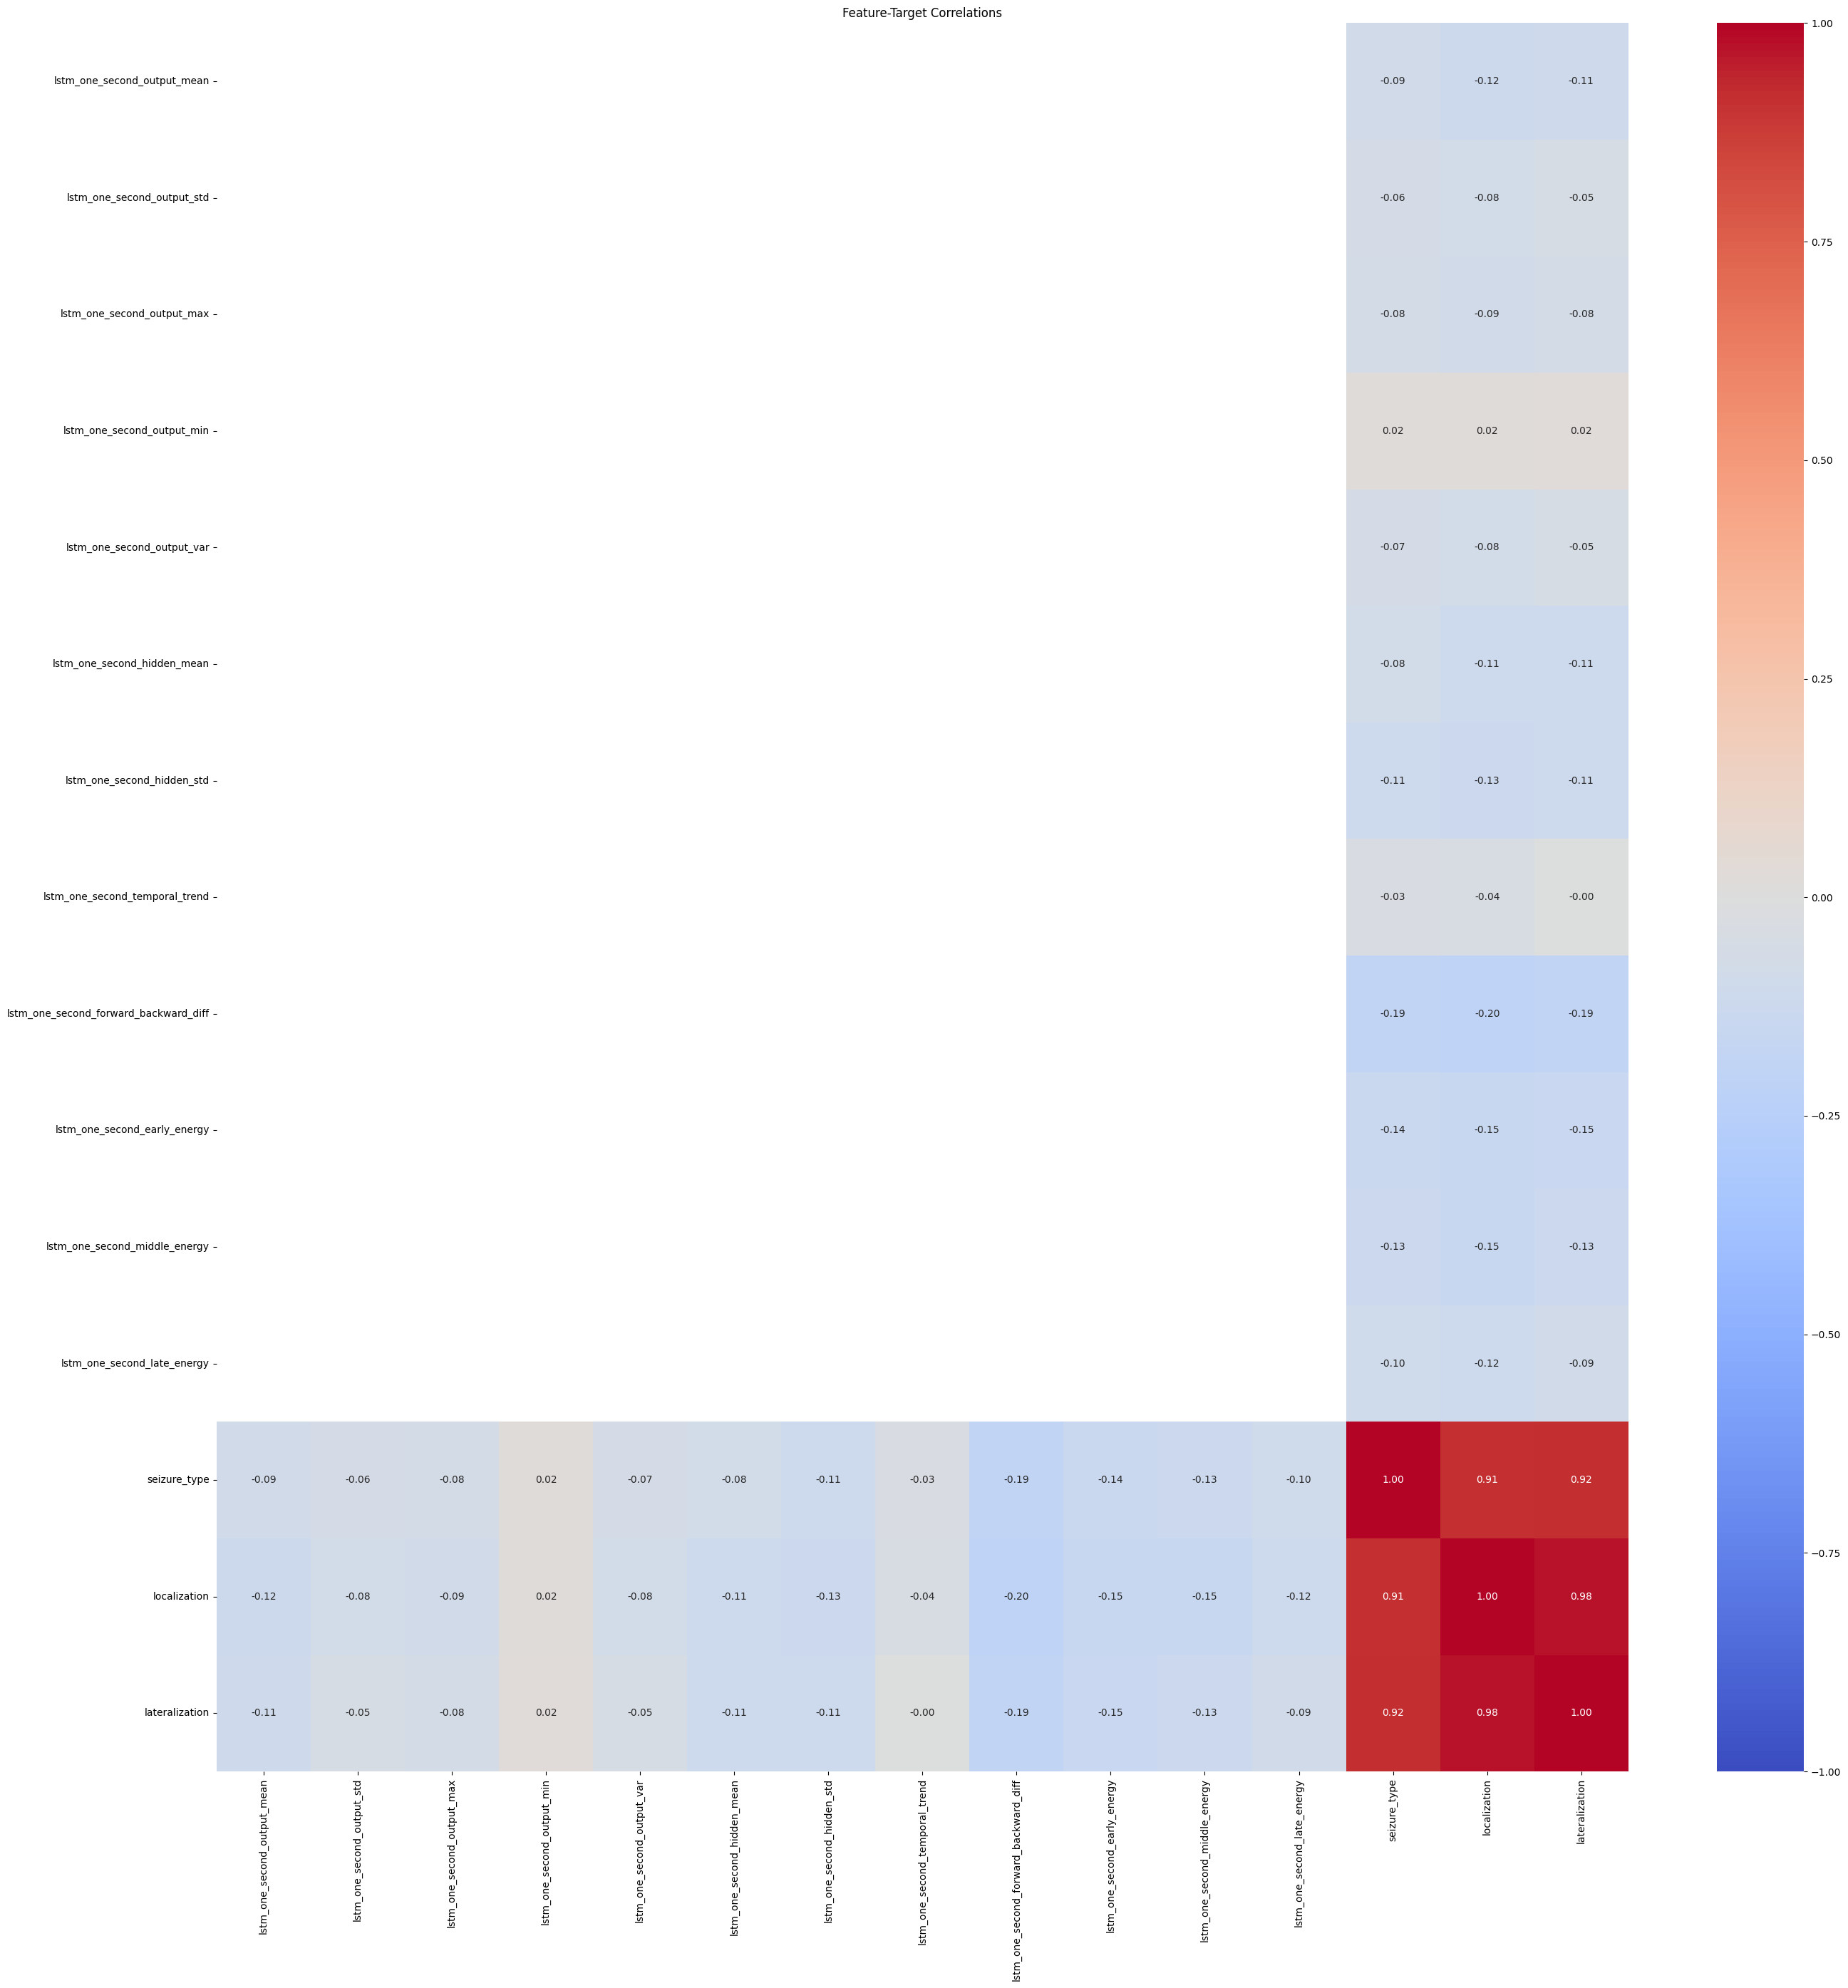


Correlations with targets (sorted):

seizure_type correlations:
  lateralization: 0.916
  localization: 0.914
  lstm_one_second_forward_backward_diff: -0.189
  lstm_one_second_early_energy: -0.136
  lstm_one_second_middle_energy: -0.130
  lstm_one_second_hidden_std: -0.115
  lstm_one_second_late_energy: -0.096
  lstm_one_second_output_mean: -0.088
  lstm_one_second_hidden_mean: -0.083
  lstm_one_second_output_max: -0.076
  lstm_one_second_output_var: -0.066
  lstm_one_second_output_std: -0.065
  lstm_one_second_temporal_trend: -0.032
  lstm_one_second_output_min: 0.023

localization correlations:
  lateralization: 0.976
  seizure_type: 0.914
  lstm_one_second_forward_backward_diff: -0.205
  lstm_one_second_early_energy: -0.152
  lstm_one_second_middle_energy: -0.150
  lstm_one_second_hidden_std: -0.131
  lstm_one_second_output_mean: -0.119
  lstm_one_second_late_energy: -0.116
  lstm_one_second_hidden_mean: -0.114
  lstm_one_second_output_max: -0.088
  lstm_one_second_output_var: -0.0

In [55]:
features_to_keep, features_to_remove, key_features = plot_correlation_matrix(encoded_df, plot_output_path)